# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import seaborn as sns
import itertools
import warnings

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb

warnings.filterwarnings("ignore", message=".*force_all_finite.*was renamed to 'ensure_all_finite'.*")

# Import Dataset

The Dataset with the following columns is imported

used variables:
- Total vehicles sold (Target)
    - Company car tax rate (%)
    - Google  Home charging (G)
    - Consumer confidence (E)
    - Gasoline (Euro95) - Average price (F)





In [2]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\AVG_Gas.csv")
df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)
display(df.head())

Time Period (T)  Home charging (G)  Electric car (G)  Hybrid electric (G)  \
0      2007-01-01                  0                 1                    0   
1      2007-02-01                  0                 0                    0   
2      2007-03-01                  0                 0                    0   
3      2007-04-01                  0                 0                    0   
4      2007-05-01                  0                 2                    0   

   Company car tax rate (%)  Consumer confidence (E)  \
0                        22                     20.0   
1                        22                     20.0   
2                        22                     20.0   
3                        22                     20.0   
4                        22                     18.0   

   Economic climate perception (E)  Willingness to buy (E)  \
0                             37.0                     9.0   
1                             37.0                     9.0   
2                             37.0                     9.0   
3                             37.0                     9.0   
4                             32.0                     9.0   

   Major purchases sentiment (E)  Gasoline (Euro95) - Average price (F)  \
0                            8.0                               1.303032   
1                            8.0                               1.325357   
2                            8.0                               1.379032   
3                            8.0                               1.426500   
4                            7.4                               1.466516   

   Diesel - Average price (F)  Total vehicles sold (Target)  
0                    0.970000                            31  
1                    0.990000                            39  
2                    1.006323                           123  
3                    1.030600                            62  
4                    1.032323                            84

# 1. Plot all data 

Following the steps for producing forcasts for time series data from Forecasting: Principles and Practice, the Pythonic Way, will be broken down into the following steps:

A structured process for producing forecasts:

1. Prepare the data (cleaning, formatting)

2. Visualize to identify patterns

3. pecify a model

4. Train the model

5. Evaluate performance

6. Generate forecasts

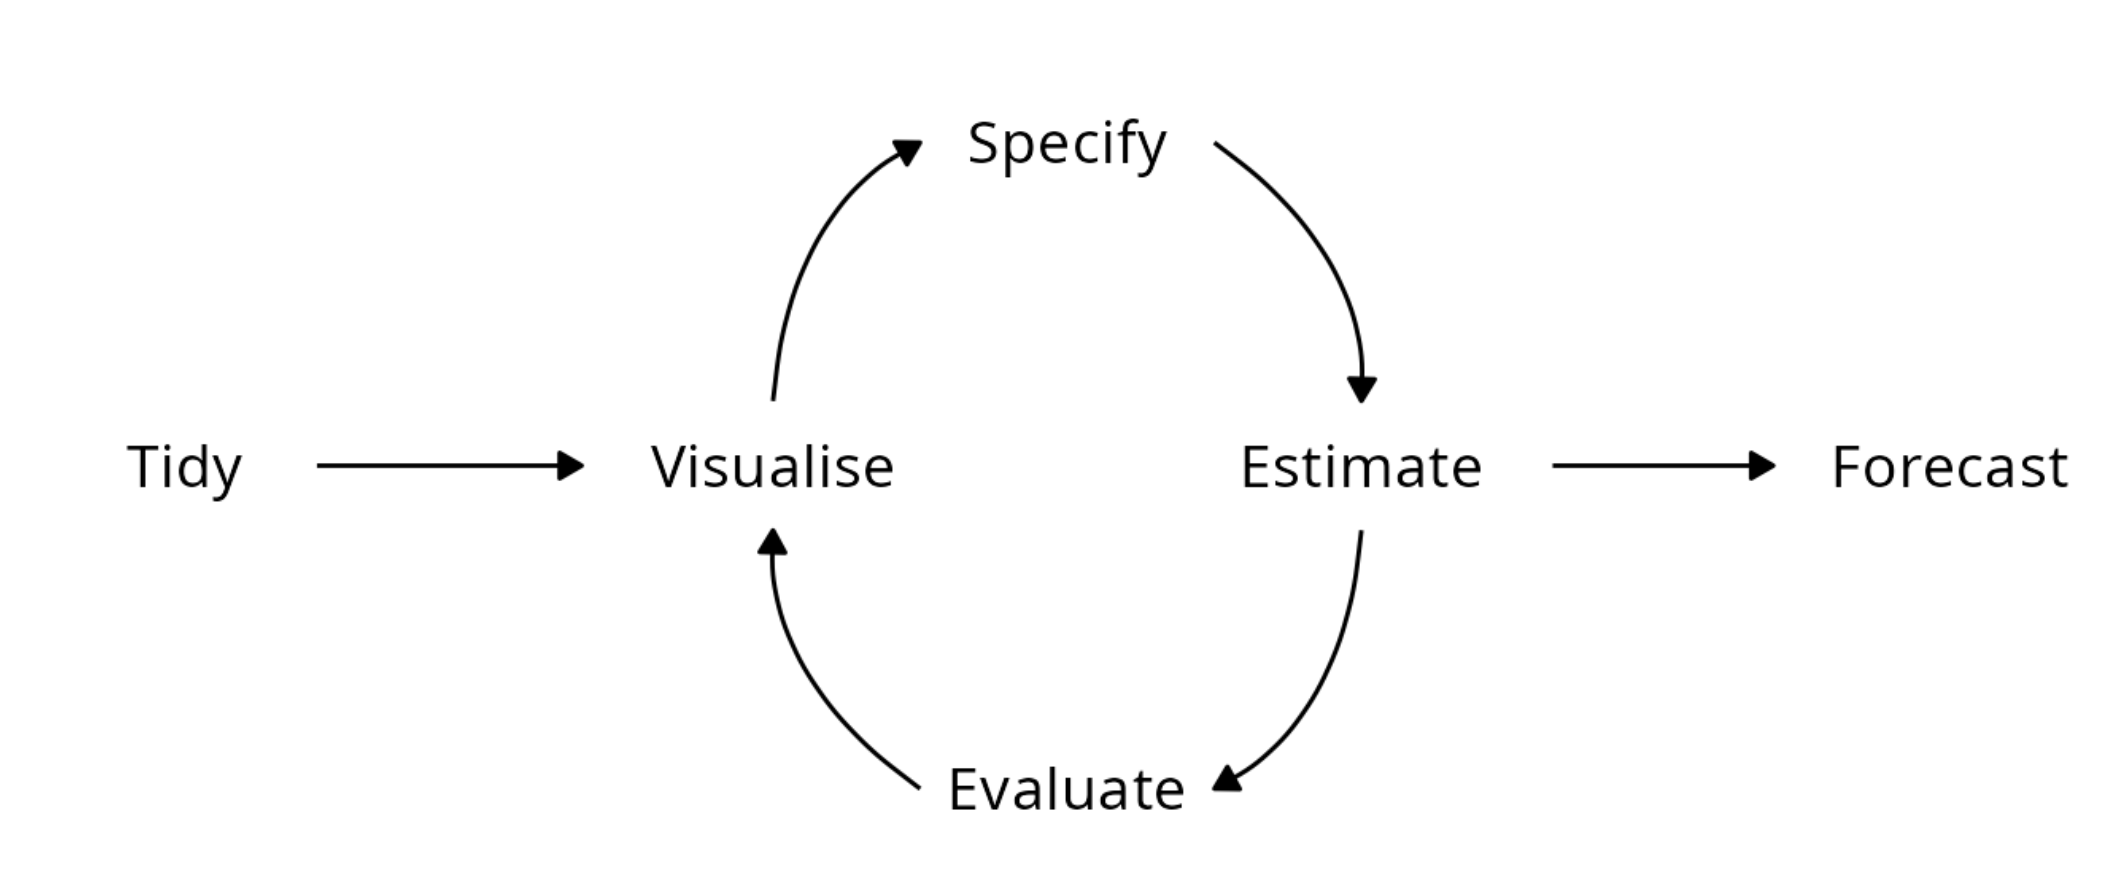



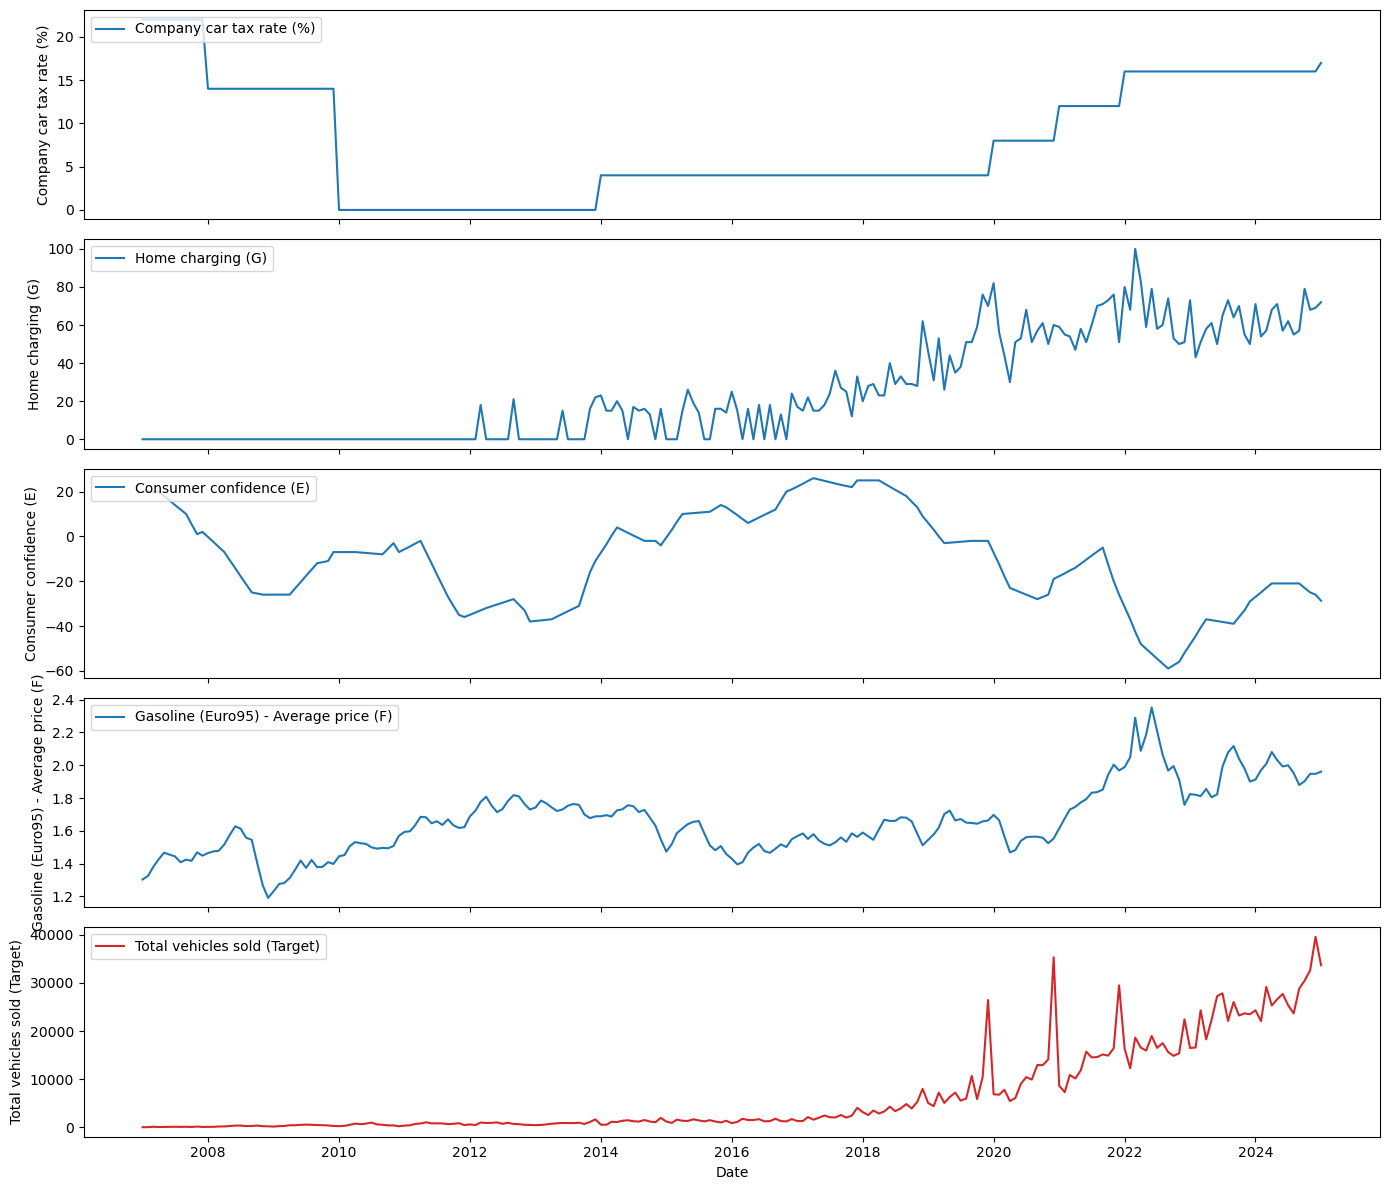

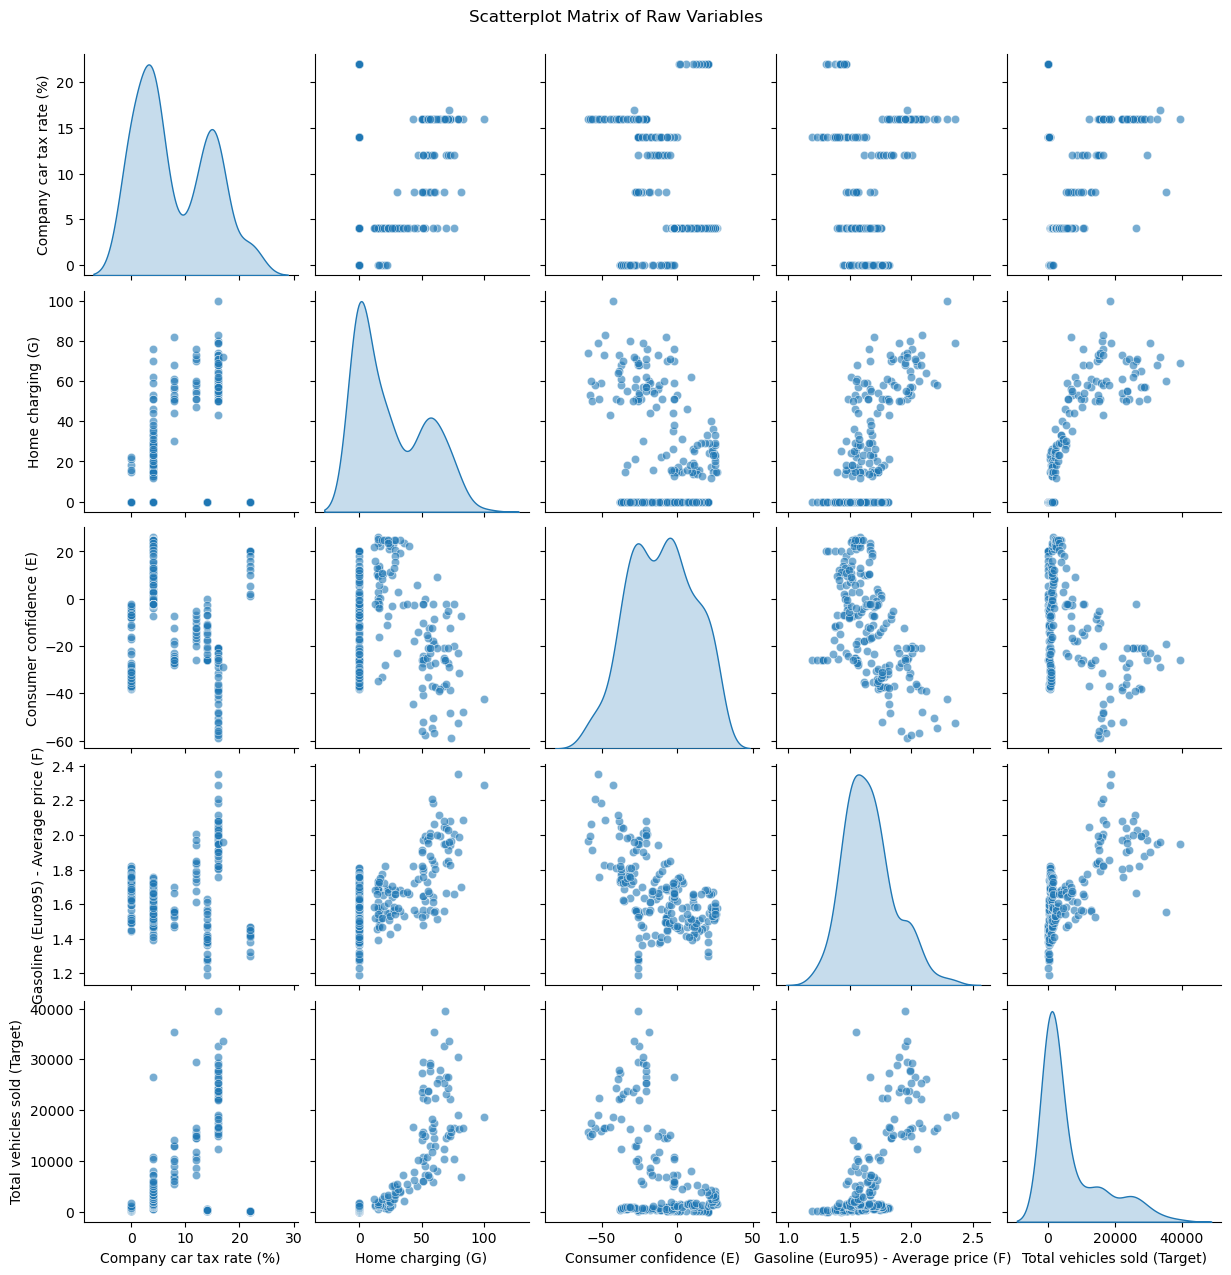

In [36]:
import seaborn as sns

# Define features and target
features = ['Company car tax rate (%)', 'Home charging (G)', 'Consumer confidence (E)', 'Gasoline (Euro95) - Average price (F)']
target = 'Total vehicles sold (Target)'

fig, axs = plt.subplots(len(features) + 1, 1, figsize=(14, 12), sharex=True)

for i, col in enumerate(features):
    axs[i].plot(df["Time Period (T)"], df[col], label=col)
    axs[i].set_ylabel(col)
    axs[i].legend(loc="upper left")

axs[-1].plot(df["Time Period (T)"], df[target], label=target, color='tab:red')
axs[-1].set_ylabel(target)
axs[-1].set_xlabel("Date")
axs[-1].legend(loc="upper left")

plt.tight_layout()
plt.show()

# Scatterplot matrix (pairplot) for all features and target
sns.pairplot(df[features + [target]], diag_kind="kde", plot_kws={'alpha':0.6})
plt.suptitle("Scatterplot Matrix of Raw Variables", y=1.02)
plt.show()

Company car tax rate (%): lambda=0.3553071918642989, shift=1
Home charging (G): lambda=0.1026320662583565, shift=1
Consumer confidence (E): lambda=0.9074223886617425, shift=60.0
Gasoline (Euro95) - Average price (F): lambda=-0.8394601069903194, shift=0
Total vehicles sold (Target): lambda=-0.002079636725042893, shift=0


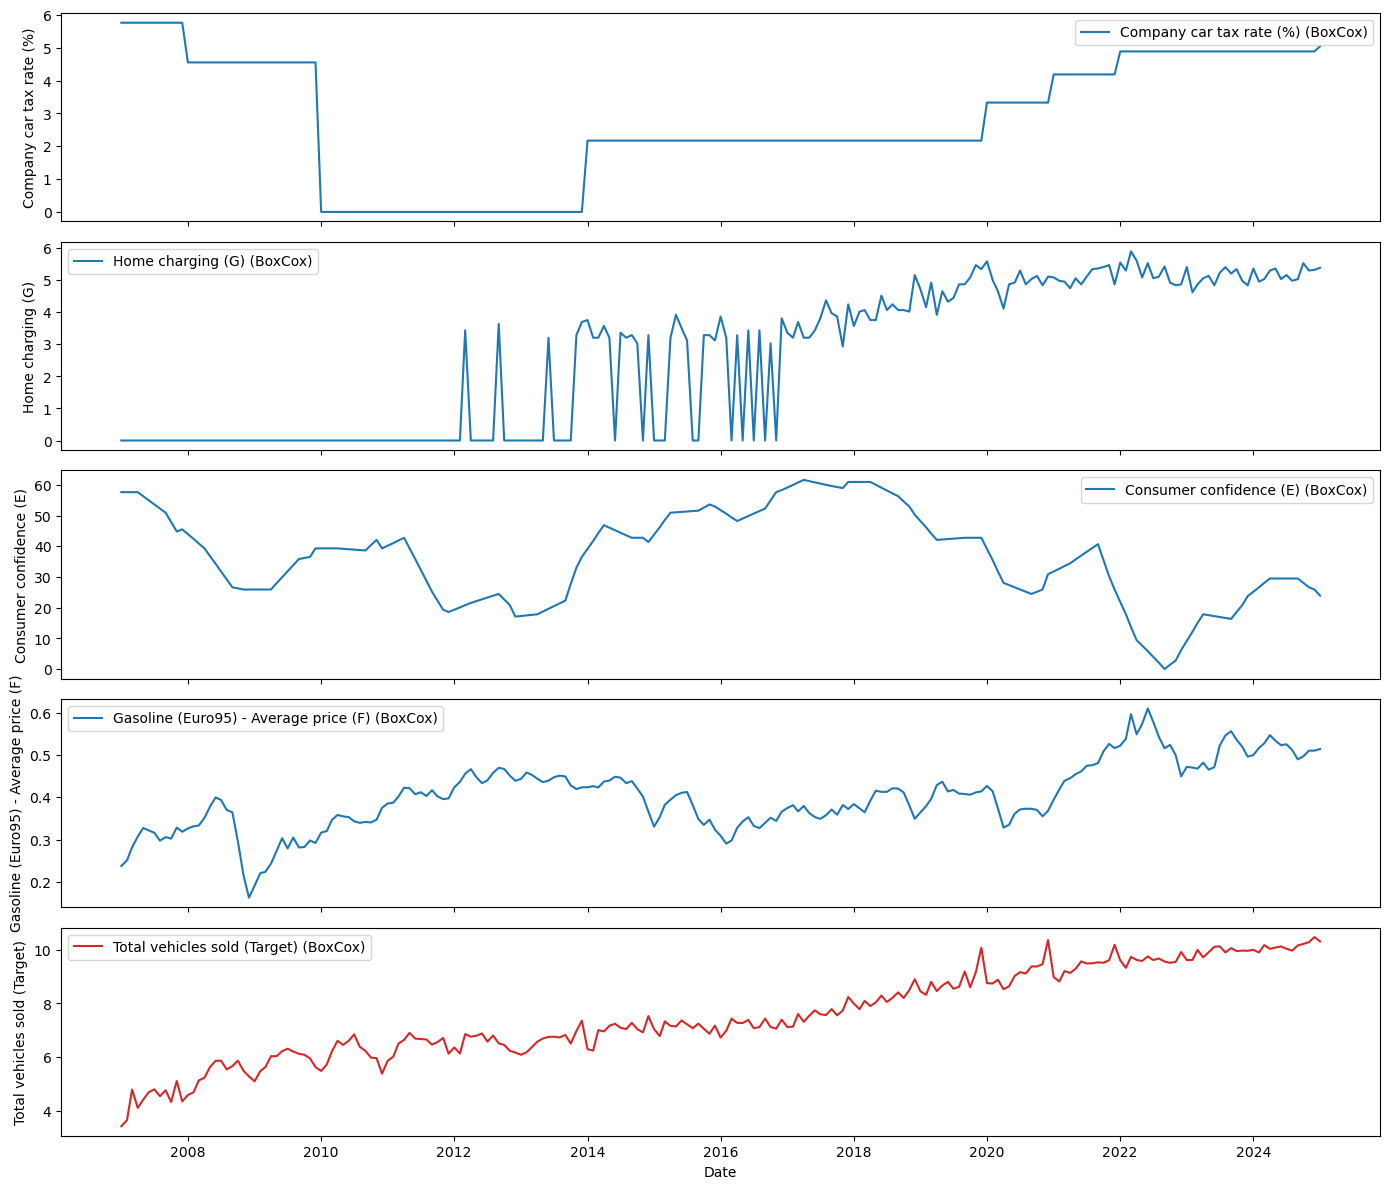

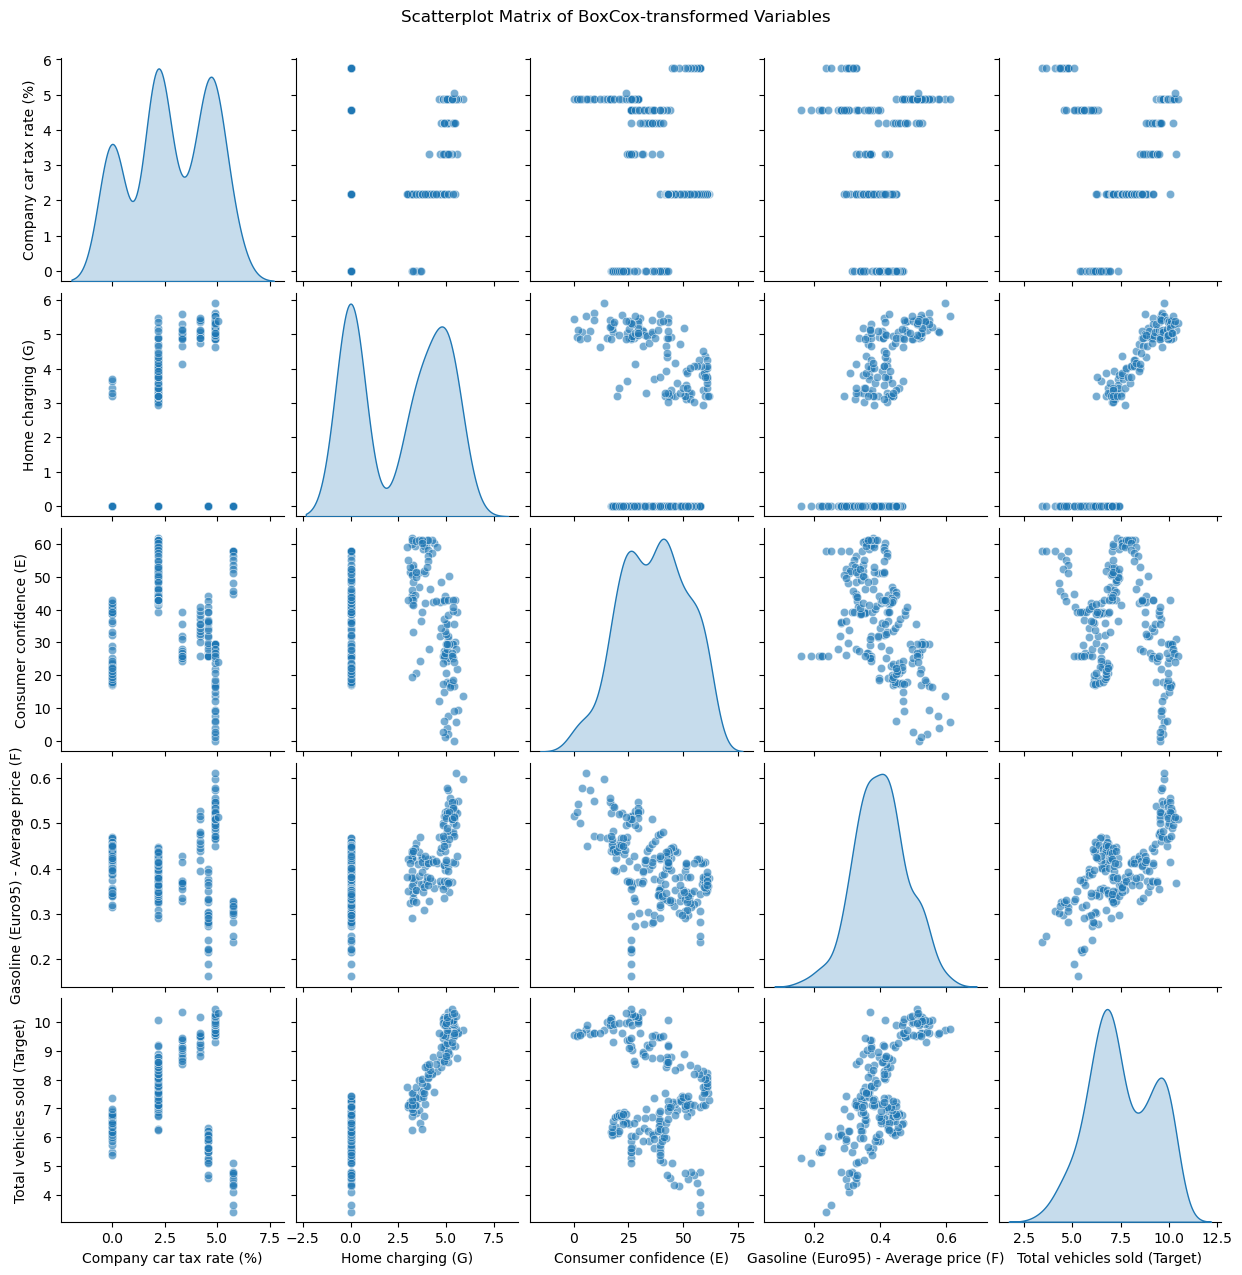

In [4]:
from scipy.stats import boxcox
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


features = ['Company car tax rate (%)', 'Home charging (G)', 'Consumer confidence (E)', 'Gasoline (Euro95) - Average price (F)']
target = 'Total vehicles sold (Target)'
# Find optimal lambda and shift for each feature and target on the whole dataset
boxcox_all = {}
boxcox_lambdas_all = {}

for col in features + [target]:
    series = df[col]
    min_val = series.min()
    if min_val <= 0:
        shift = -min_val + 1
        series_shifted = series + shift
    else:
        shift = 0
        series_shifted = series
    transformed, lam = boxcox(series_shifted)
    boxcox_all[col] = transformed
    boxcox_lambdas_all[col] = (lam, shift)
    print(f"{col}: lambda={lam}, shift={shift}")

# Plot BoxCox-transformed data for all features and target

fig, axs = plt.subplots(len(features) + 1, 1, figsize=(14, 12), sharex=True)
for i, col in enumerate(features):
    axs[i].plot(df["Time Period (T)"], boxcox_all[col], label=f"{col} (BoxCox)")
    axs[i].set_ylabel(col)
    axs[i].legend()
axs[-1].plot(df["Time Period (T)"], boxcox_all[target], label=f"{target} (BoxCox)", color='tab:red')
axs[-1].set_ylabel(target)
axs[-1].set_xlabel("Date")
axs[-1].legend()
plt.tight_layout()
plt.show()

### Deze plot ook doen voor boxcox! liefst wel enkel op train

# Create a dataframe with BoxCox-transformed features and target
bc_df = pd.DataFrame({col: boxcox_all[col] for col in features + [target]})

# Scatterplot matrix (pairplot)
sns.pairplot(bc_df, diag_kind="kde", plot_kws={'alpha':0.6})
plt.suptitle("Scatterplot Matrix of BoxCox-transformed Variables", y=1.02)
plt.show()


# 1. Apply train/val/test split

In [5]:
# Define features and target
features = ['Company car tax rate (%)', 'Home charging (G)', 'Consumer confidence (E)', 'Gasoline (Euro95) - Average price (F)']
target = 'Total vehicles sold (Target)'

# Calculate split indices
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# Split the target
y = df[target]
y_train = y.iloc[:train_end]
y_val = y.iloc[train_end:val_end]
y_test = y.iloc[val_end:]

# Split each feature separately
companytax_train = df['Company car tax rate (%)'].iloc[:train_end]
companytax_val = df['Company car tax rate (%)'].iloc[train_end:val_end]
companytax_test = df['Company car tax rate (%)'].iloc[val_end:]

homechg_train = df['Home charging (G)'].iloc[:train_end]
homechg_val = df['Home charging (G)'].iloc[train_end:val_end]
homechg_test = df['Home charging (G)'].iloc[val_end:]

conf_train = df['Consumer confidence (E)'].iloc[:train_end]
conf_val = df['Consumer confidence (E)'].iloc[train_end:val_end]
conf_test = df['Consumer confidence (E)'].iloc[val_end:]

# Split gasoline price feature
gas_train = df['Gasoline (Euro95) - Average price (F)'].iloc[:train_end]
gas_val = df['Gasoline (Euro95) - Average price (F)'].iloc[train_end:val_end]
gas_test = df['Gasoline (Euro95) - Average price (F)'].iloc[val_end:]

# Print sizes
print(f"Train size: {len(y_train)}, Val size: {len(y_val)}, Test size: {len(y_test)}")


# Print each dataset
print("y_train:\n", y_train.head(), "\n")
print("y_val:\n", y_val.head(), "\n")
print("y_test:\n", y_test.head(), "\n")

print("companytax_train:\n", companytax_train.head(), "\n")
print("companytax_val:\n", companytax_val.head(), "\n")
print("companytax_test:\n", companytax_test.head(), "\n")

print("homechg_train:\n", homechg_train.head(), "\n")
print("homechg_val:\n", homechg_val.head(), "\n")
print("homechg_test:\n", homechg_test.head(), "\n")

print("conf_train:\n", conf_train.head(), "\n")
print("conf_val:\n", conf_val.head(), "\n")
print("conf_test:\n", conf_test.head(), "\n")

print("gas_train:\n", gas_train.head(), "\n")
print("gas_val:\n", gas_val.head(), "\n")
print("gas_test:\n", gas_test.head(), "\n")

# Show percentage of each split
print(f"Train: {len(y_train)/n:.1%}, Val: {len(y_val)/n:.1%}, Test: {len(y_test)/n:.1%}")



Train size: 173, Val size: 22, Test size: 22
y_train:
 0     31
1     39
2    123
3     62
4     84
Name: Total vehicles sold (Target), dtype: int64 

y_val:
 173    15736
174    14522
175    14615
176    15143
177    14904
Name: Total vehicles sold (Target), dtype: int64 

y_test:
 195    18281
196    22305
197    27262
198    27851
199    22109
Name: Total vehicles sold (Target), dtype: int64 

companytax_train:
 0    22
1    22
2    22
3    22
4    22
Name: Company car tax rate (%), dtype: int64 

companytax_val:
 173    12
174    12
175    12
176    12
177    12
Name: Company car tax rate (%), dtype: int64 

companytax_test:
 195    16
196    16
197    16
198    16
199    16
Name: Company car tax rate (%), dtype: int64 

homechg_train:
 0    0
1    0
2    0
3    0
4    0
Name: Home charging (G), dtype: int64 

homechg_val:
 173    51
174    60
175    70
176    71
177    73
Name: Home charging (G), dtype: int64 

homechg_test:
 195    58
196    61
197    50
198    65
199    73
Name:

#### Train

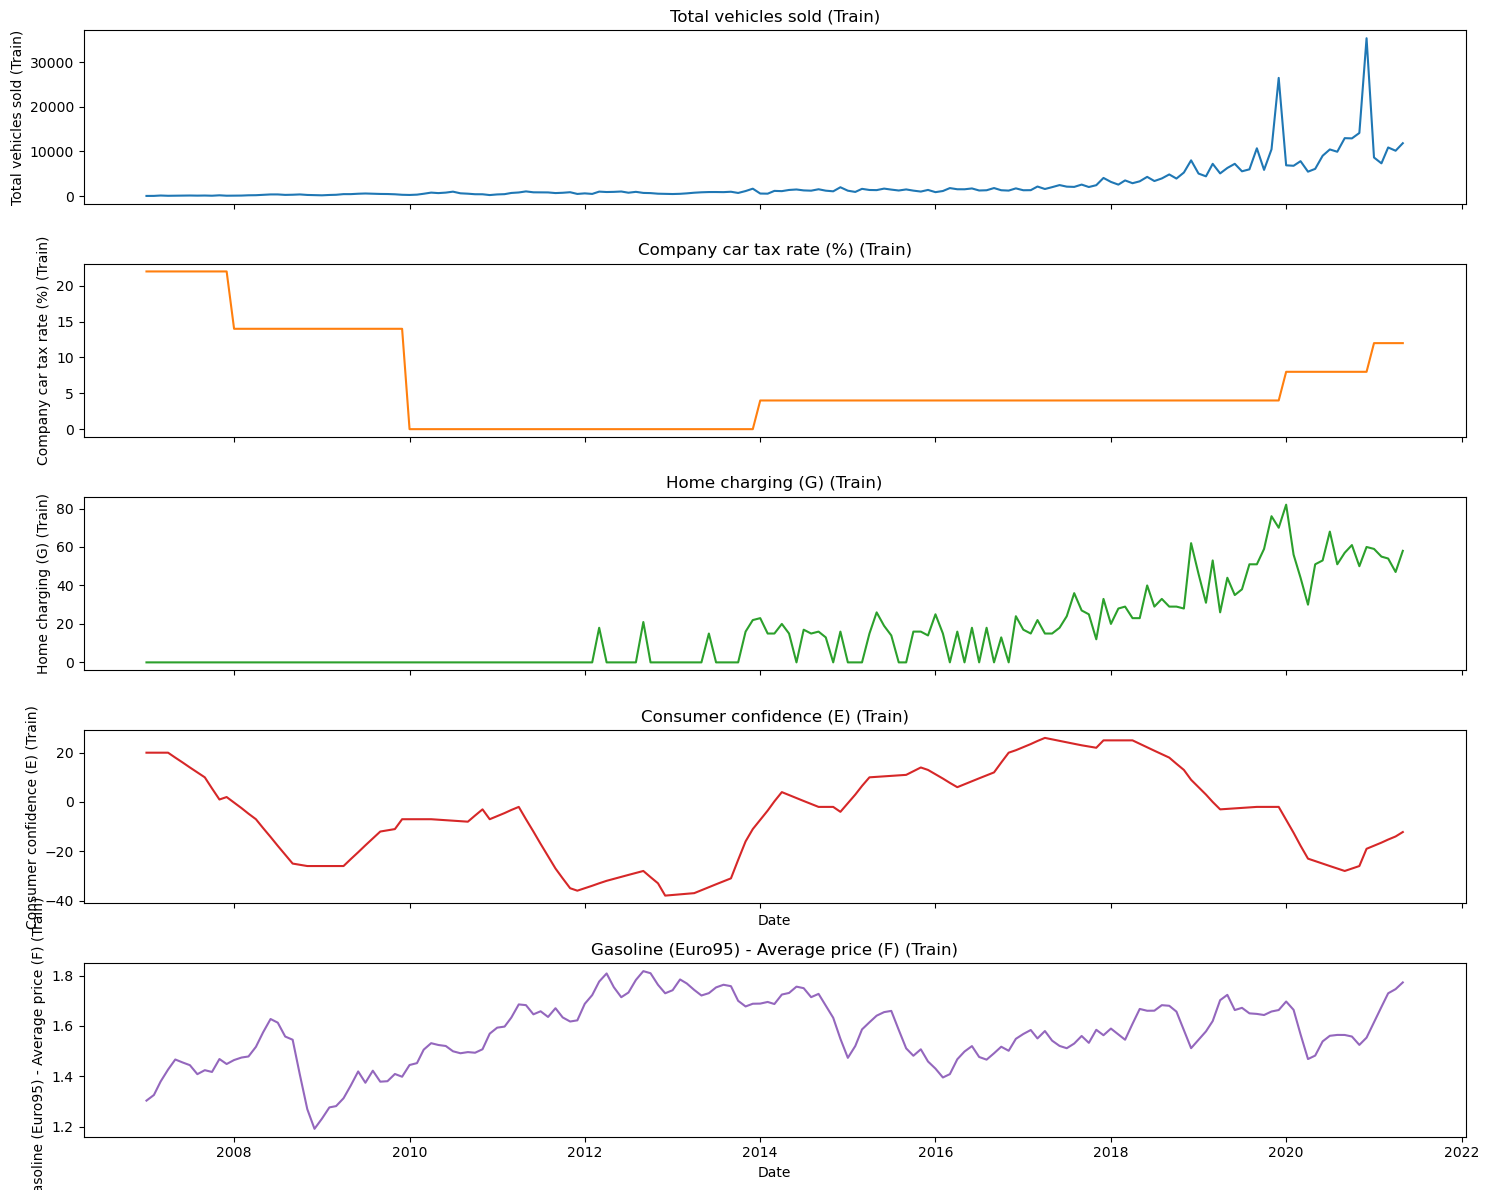

In [6]:
fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

date_train = df["Time Period (T)"][:len(y_train)]

axs[0].plot(date_train, y_train, color='tab:blue')
axs[0].set_ylabel('Total vehicles sold (Train)')
axs[0].set_title('Total vehicles sold (Train)')

axs[1].plot(date_train, companytax_train, color='tab:orange')
axs[1].set_ylabel('Company car tax rate (%) (Train)')
axs[1].set_title('Company car tax rate (%) (Train)')

axs[2].plot(date_train, homechg_train, color='tab:green')
axs[2].set_ylabel('Home charging (G) (Train)')
axs[2].set_title('Home charging (G) (Train)')

axs[3].plot(date_train, conf_train, color='tab:red')
axs[3].set_ylabel('Consumer confidence (E) (Train)')
axs[3].set_title('Consumer confidence (E) (Train)')
axs[3].set_xlabel('Date')


axs[4].plot(date_train, gas_train, color='tab:purple')
axs[4].set_ylabel('Gasoline (Euro95) - Average price (F) (Train)')
axs[4].set_title('Gasoline (Euro95) - Average price (F) (Train)')
axs[4].set_xlabel('Date')



plt.tight_layout()
plt.show()




Company car tax rate (%): λ = 0.3553, shift = 1
Home charging (G): λ = 0.1026, shift = 1
Consumer confidence (E): λ = 0.9074, shift = 60.0
Gasoline (Euro95) - Average price (F): λ = -0.8395, shift = 0
Total vehicles sold (Target): λ = -0.0021, shift = 0


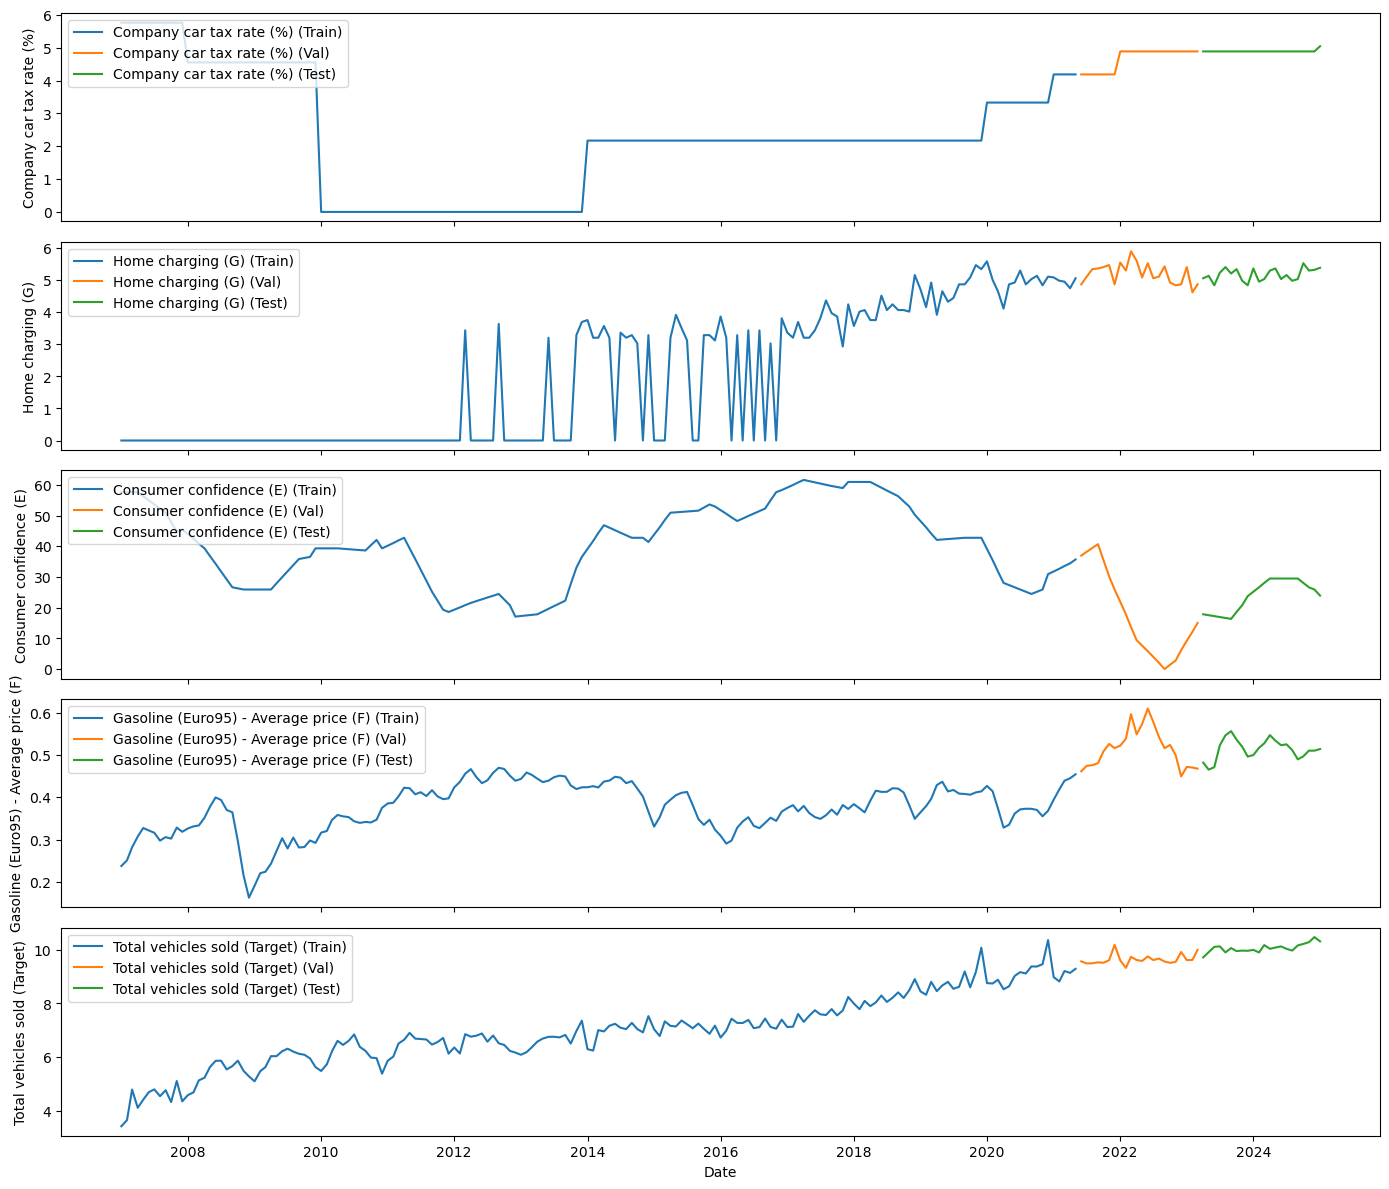

In [7]:
from scipy.stats import boxcox
import numpy as np
import matplotlib.pyplot as plt

# Splits instellen (80/10/10)
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# Opslag
boxcox_all = {}
boxcox_lambdas_all = {}

# Bereken BoxCox over de hele dataset (met correcte shift)
for col in features + [target]:
    series = df[col]
    min_val = series.min()
    if min_val <= 0:
        shift = -min_val + 1
        series_shifted = series + shift
    else:
        shift = 0
        series_shifted = series
    transformed, lam = boxcox(series_shifted)
    boxcox_all[col] = transformed
    boxcox_lambdas_all[col] = (lam, shift)
    print(f"{col}: λ = {lam:.4f}, shift = {shift}")

# Plot per split with date on x-axis
fig, axs = plt.subplots(len(features) + 1, 1, figsize=(14, 12), sharex=True)
for i, col in enumerate(features):
    axs[i].plot(df["Time Period (T)"][:train_end], boxcox_all[col][:train_end], label=f"{col} (Train)", color='tab:blue')
    axs[i].plot(df["Time Period (T)"][train_end:val_end], boxcox_all[col][train_end:val_end], label=f"{col} (Val)", color='tab:orange')
    axs[i].plot(df["Time Period (T)"][val_end:], boxcox_all[col][val_end:], label=f"{col} (Test)", color='tab:green')
    axs[i].set_ylabel(col)
    axs[i].legend(loc="upper left")

# Target plot
axs[-1].plot(df["Time Period (T)"][:train_end], boxcox_all[target][:train_end], label=f"{target} (Train)", color='tab:blue')
axs[-1].plot(df["Time Period (T)"][train_end:val_end], boxcox_all[target][train_end:val_end], label=f"{target} (Val)", color='tab:orange')
axs[-1].plot(df["Time Period (T)"][val_end:], boxcox_all[target][val_end:], label=f"{target} (Test)", color='tab:green')
axs[-1].set_ylabel(target)
axs[-1].set_xlabel("Date")
axs[-1].legend(loc="upper left")

plt.tight_layout()
plt.show()





# 3. run stationary tests

After plotting and splitting the data its time for staionality tests. 

Since Arima models rely on past autocorrelations to make predictions, they assume stationality in the data.

A stationary time series is one whose statistical properties do not depend on the time at which the series is observed. observing the previous plots, we can see non stationality in the data by some upward trends and seasonality. 

Visually, stationary series tend to look flat and horizontal, possibly with random fluctuations or irregular cycles, but without consistent upward/downward trends or recurring patterns.

There are a few tests to check for stationarity, the most common ones are:
- **Augmented Dickey-Fuller (ADF) test**: Tests the null hypothesis that a unit root is present in the time series, indicating non-stationarity. A low p-value (typically < 0.05) suggests that the series is stationary.
- **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**: Tests the null hypothesis that a time series is stationary around a deterministic trend. A high p-value (typically > 0.05) suggests stationarity.
plotting the ACF and PACF plots can also help to identify stationarity.

ADF focuses on detecting a unit root (non-stationarity) under the null hypothesis.

KPSS assumes stationarity under the null hypothesis.
because 




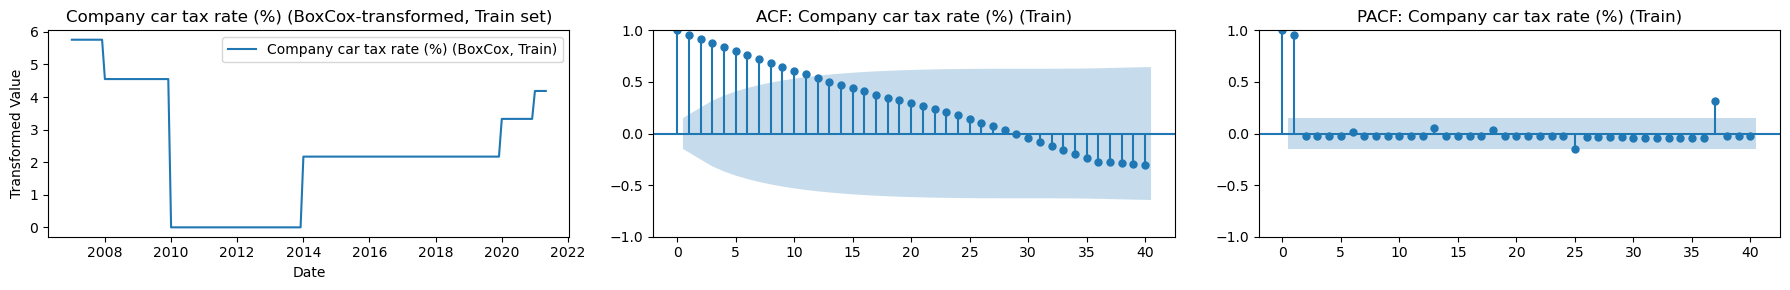

==== Company car tax rate (%) ====
ADF Statistic: -1.9616509753433216
ADF p-value: 0.3036366851664807
ADF Critical Value (1%): -3.4690
ADF Critical Value (5%): -2.8785
ADF Critical Value (10%): -2.5758
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 0.3745620074363245
KPSS p-value: 0.0881198243808946
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



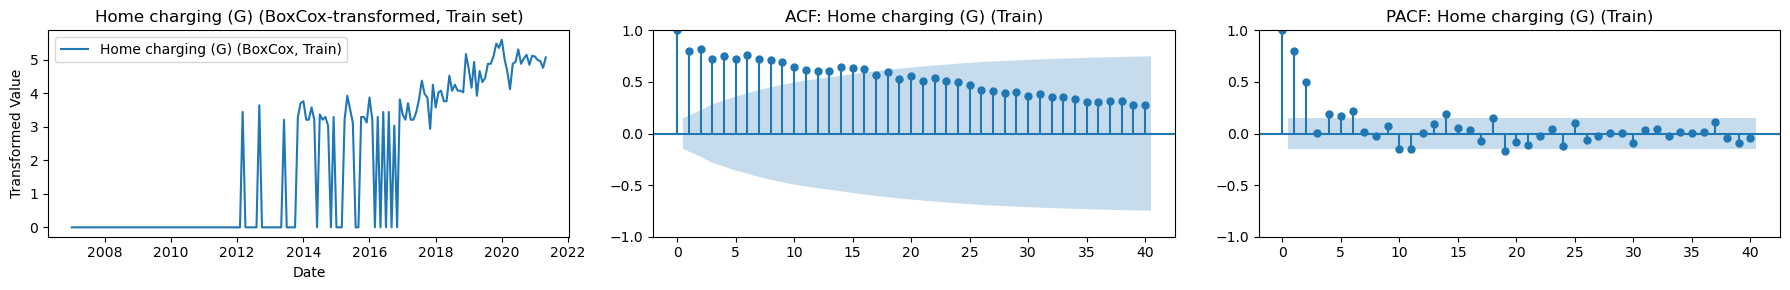

C:\Users\dylan\AppData\Local\Temp\ipykernel_38576\490514745.py:29: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train_bc, regression='c', nlags="auto")


==== Home charging (G) ====
ADF Statistic: -0.20937322979102604
ADF p-value: 0.9373950918228283
ADF Critical Value (1%): -3.4722
ADF Critical Value (5%): -2.8799
ADF Critical Value (10%): -2.5766
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 1.8545194253954822
KPSS p-value: 0.01
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).



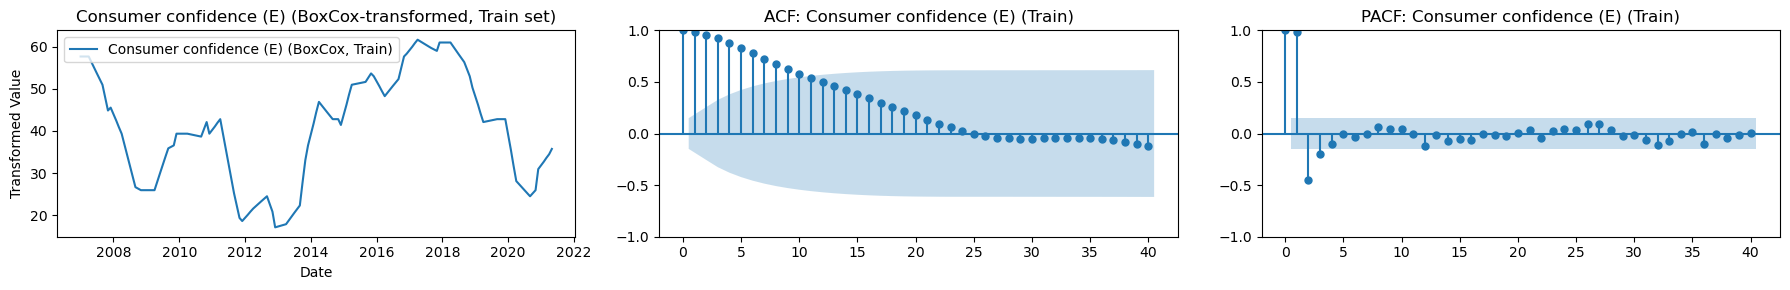

C:\Users\dylan\AppData\Local\Temp\ipykernel_38576\490514745.py:29: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(train_bc, regression='c', nlags="auto")


==== Consumer confidence (E) ====
ADF Statistic: -2.3510691792521663
ADF p-value: 0.1560254463294088
ADF Critical Value (1%): -3.4692
ADF Critical Value (5%): -2.8786
ADF Critical Value (10%): -2.5759
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 0.3260610689932099
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



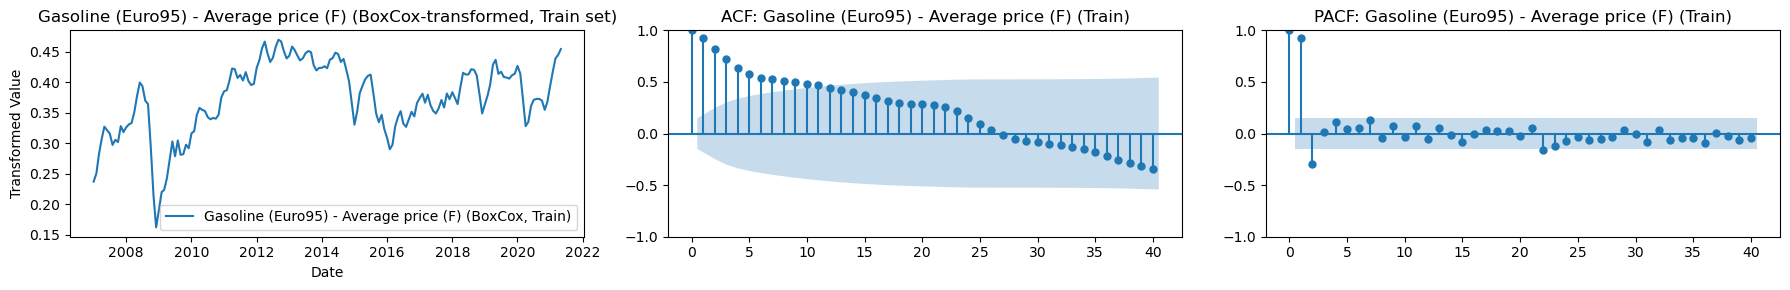

==== Gasoline (Euro95) - Average price (F) ====
ADF Statistic: -3.429561331934728
ADF p-value: 0.009991471463935241
ADF Critical Value (1%): -3.4692
ADF Critical Value (5%): -2.8786
ADF Critical Value (10%): -2.5759
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.5550652860343227
KPSS p-value: 0.02926457521749488
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).



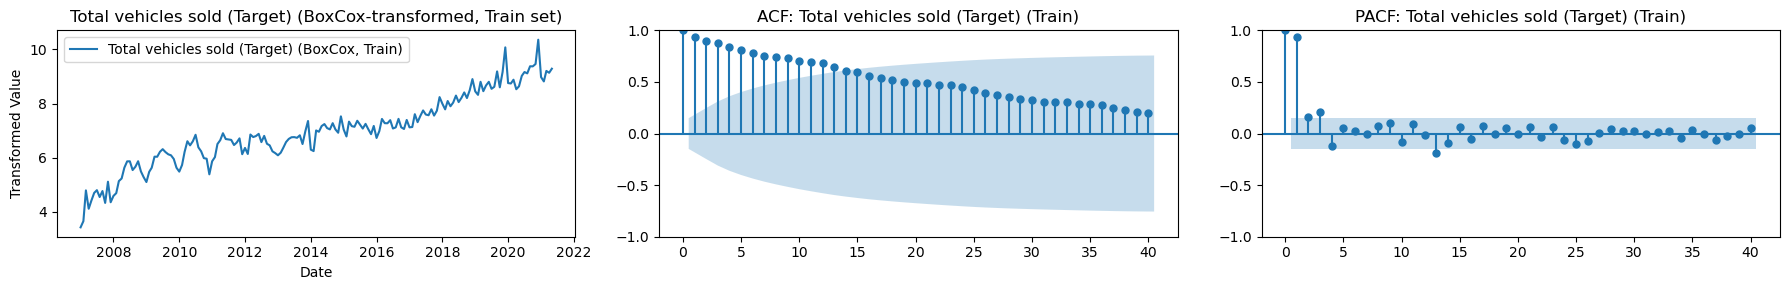

==== Total vehicles sold (Target) ====
ADF Statistic: -0.2734144213478023
ADF p-value: 0.929186159504631
ADF Critical Value (1%): -3.4722
ADF Critical Value (5%): -2.8799
ADF Critical Value (10%): -2.5766
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 1.8854846327709538
KPSS p-value: 0.01
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).



C:\Users\dylan\AppData\Local\Temp\ipykernel_38576\490514745.py:29: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train_bc, regression='c', nlags="auto")


In [8]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

results = {}

# Loop over features and target
for col in features + [target]:
    # Get BoxCox-transformed train split
    train_bc = boxcox_all[col][:len(y_train)]
    train_dates = df["Time Period (T)"][:len(y_train)]  # Get corresponding dates

    # Plot time series and ACF/PACF side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 3))
    axes[0].plot(train_dates, train_bc, label=f"{col} (BoxCox, Train)")
    axes[0].set_title(f"{col} (BoxCox-transformed, Train set)")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Transformed Value")
    axes[0].legend()
    plot_acf(train_bc, ax=axes[1], lags=40)
    axes[1].set_title(f"ACF: {col} (Train)")
    plot_pacf(train_bc, ax=axes[2], lags=40, method='ywm')
    axes[2].set_title(f"PACF: {col} (Train)")
    plt.tight_layout()
    plt.show()
    
    # ADF test
    adf_result = adfuller(train_bc)
    # KPSS test
    kpss_result = kpss(train_bc, regression='c', nlags="auto")
    
    results[col] = {
        "ADF Statistic": adf_result[0],
        "ADF p-value": adf_result[1],
        "ADF Critical Values": adf_result[4],
        "KPSS Statistic": kpss_result[0],
        "KPSS p-value": kpss_result[1],
        "KPSS Critical Values": kpss_result[3]
    }
    
    print(f"\033[1m==== {col} ====\033[0m")
    print("\033[1mADF Statistic:\033[0m", adf_result[0])
    print("\033[1mADF p-value:\033[0m", adf_result[1])
    for key, value in adf_result[4].items():
        print(f"\033[1mADF Critical Value ({key}):\033[0m {value:.4f}")
    if adf_result[1] < 0.05:
        print("\033[1mADF: The series is likely stationary (reject H0).\033[0m")
    else:
        print("\033[1mADF: The series is likely non-stationary (fail to reject H0).\033[0m")
    print("\033[1mKPSS Statistic:\033[0m", kpss_result[0])
    print("\033[1mKPSS p-value:\033[0m", kpss_result[1])
    for key, value in kpss_result[3].items():
        print(f"\033[1mKPSS Critical Value ({key}):\033[0m {value:.4f}")
    if kpss_result[1] < 0.05:
        print("\033[1mKPSS: The series is likely non-stationary (reject H0).\033[0m")
    else:
        print("\033[1mKPSS: The series is likely stationary (fail to reject H0).\033[0m")
    print()

#### old

In [9]:
# from statsmodels.tsa.stattools import adfuller, kpss

# results = {}

# # Loop over features and target
# for col in features + [target]:
#     # Get BoxCox-transformed train split
#     train_bc = boxcox_all[col][:len(y_train)]
#     train_dates = df["Time Period (T)"][:len(y_train)]  # Get corresponding dates

#     # Plot
#     plt.figure(figsize=(12, 3))
#     plt.plot(train_dates, train_bc, label=f"{col} (BoxCox, Train)")
#     plt.title(f"{col} (BoxCox-transformed, Train set)")
#     plt.xlabel("Date")
#     plt.ylabel("Transformed Value")
#     plt.legend()
#     plt.show()
    
#     # ADF test
#     adf_result = adfuller(train_bc)
#     # KPSS test
#     kpss_result = kpss(train_bc, regression='c', nlags="auto")
    
#     results[col] = {
#         "ADF Statistic": adf_result[0],
#         "ADF p-value": adf_result[1],
#         "ADF Critical Values": adf_result[4],
#         "KPSS Statistic": kpss_result[0],
#         "KPSS p-value": kpss_result[1],
#         "KPSS Critical Values": kpss_result[3]
#     }
    

    
#     print(f"\033[1m==== {col} ====\033[0m")
#     print("\033[1mADF Statistic:\033[0m", adf_result[0])
#     print("\033[1mADF p-value:\033[0m", adf_result[1])
#     for key, value in adf_result[4].items():
#         print(f"\033[1mADF Critical Value ({key}):\033[0m {value:.4f}")
#     if adf_result[1] < 0.05:
#         print("\033[1mADF: The series is likely stationary (reject H0).\033[0m")
#     else:
#         print("\033[1mADF: The series is likely non-stationary (fail to reject H0).\033[0m")
#     print("\033[1mKPSS Statistic:\033[0m", kpss_result[0])
#     print("\033[1mKPSS p-value:\033[0m", kpss_result[1])
#     for key, value in kpss_result[3].items():
#         print(f"\033[1mKPSS Critical Value ({key}):\033[0m {value:.4f}")
#     if kpss_result[1] < 0.05:
#         print("\033[1mKPSS: The series is likely non-stationary (reject H0).\033[0m")
#     else:
#         print("\033[1mKPSS: The series is likely stationary (fail to reject H0).\033[0m")
#     print()

# 4. Apply First/second order differencing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


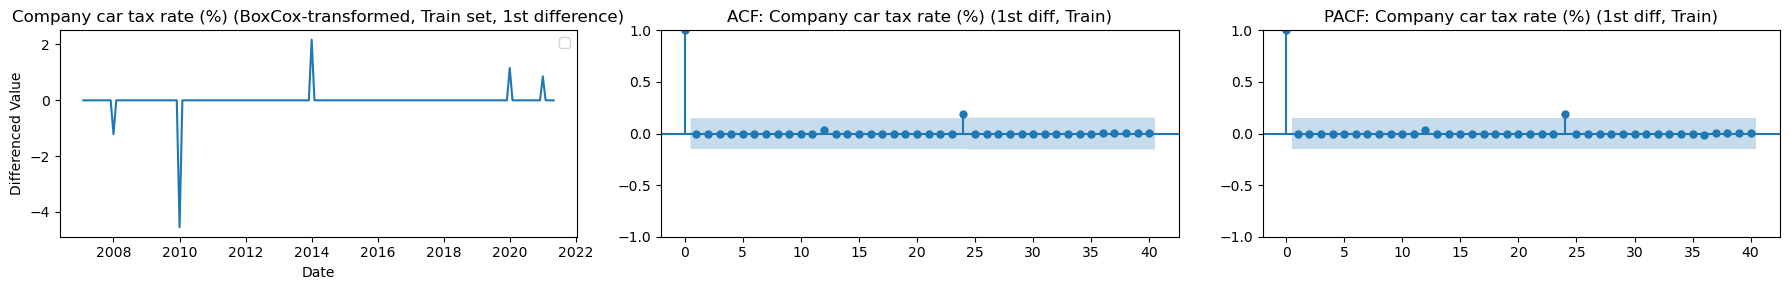

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


==== Company car tax rate (%) (1st diff) ====
ADF Statistic: -13.006500690837173
ADF p-value: 2.6210848840177814e-24
ADF Critical Value (1%): -3.4692
ADF Critical Value (5%): -2.8786
ADF Critical Value (10%): -2.5759
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.3598835944545371
KPSS p-value: 0.09444672652821676
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).


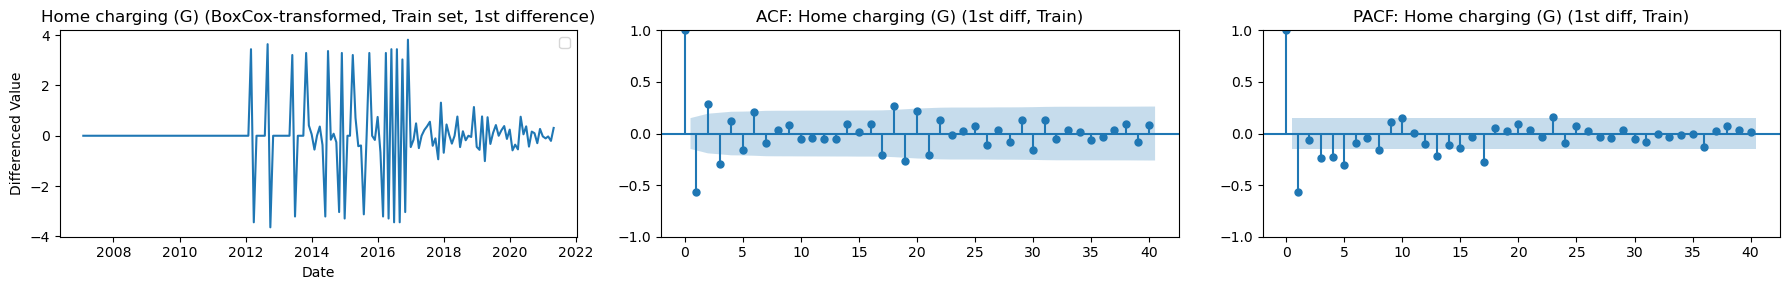

C:\Users\dylan\AppData\Local\Temp\ipykernel_38576\2086692949.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


==== Home charging (G) (1st diff) ====
ADF Statistic: -5.432745462872665
ADF p-value: 2.8901002355923257e-06
ADF Critical Value (1%): -3.4727
ADF Critical Value (5%): -2.8801
ADF Critical Value (10%): -2.5767
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.12832711943021022
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).


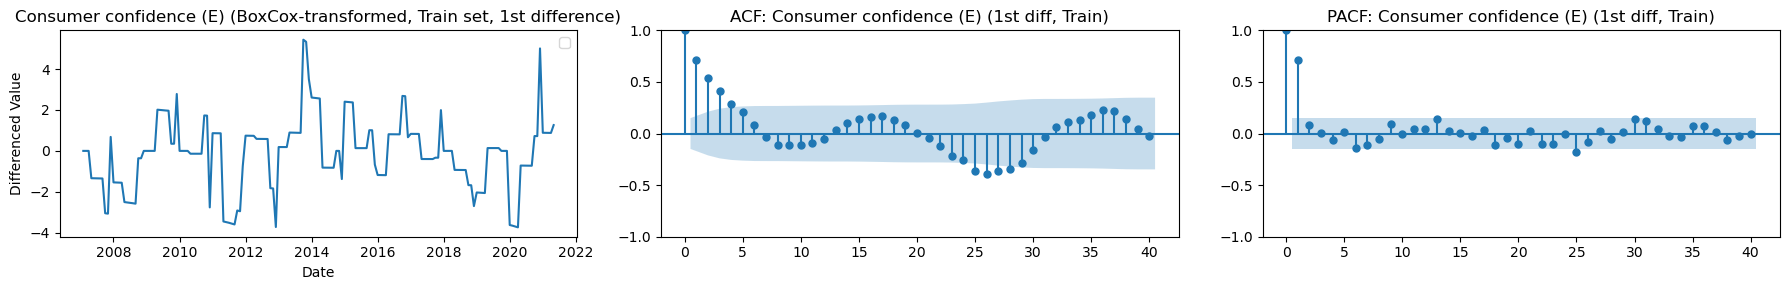

C:\Users\dylan\AppData\Local\Temp\ipykernel_38576\2086692949.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


==== Consumer confidence (E) (1st diff) ====
ADF Statistic: -5.320846040060335
ADF p-value: 4.9566881976562114e-06
ADF Critical Value (1%): -3.4692
ADF Critical Value (5%): -2.8786
ADF Critical Value (10%): -2.5759
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.13959754802959143
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).


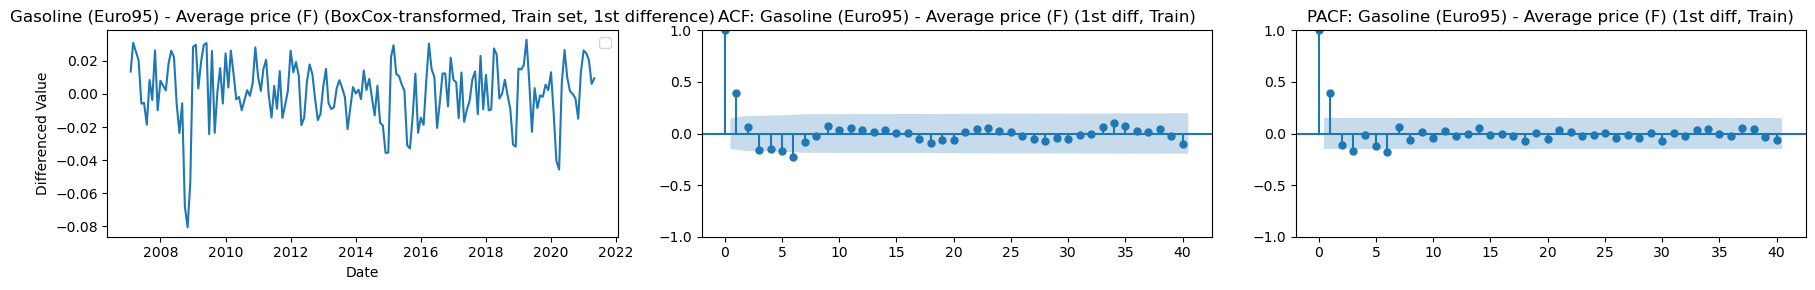

C:\Users\dylan\AppData\Local\Temp\ipykernel_38576\2086692949.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


==== Gasoline (Euro95) - Average price (F) (1st diff) ====
ADF Statistic: -7.24295525059855
ADF p-value: 1.863648224339432e-10
ADF Critical Value (1%): -3.4704
ADF Critical Value (5%): -2.8791
ADF Critical Value (10%): -2.5761
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.08683442785440895
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).


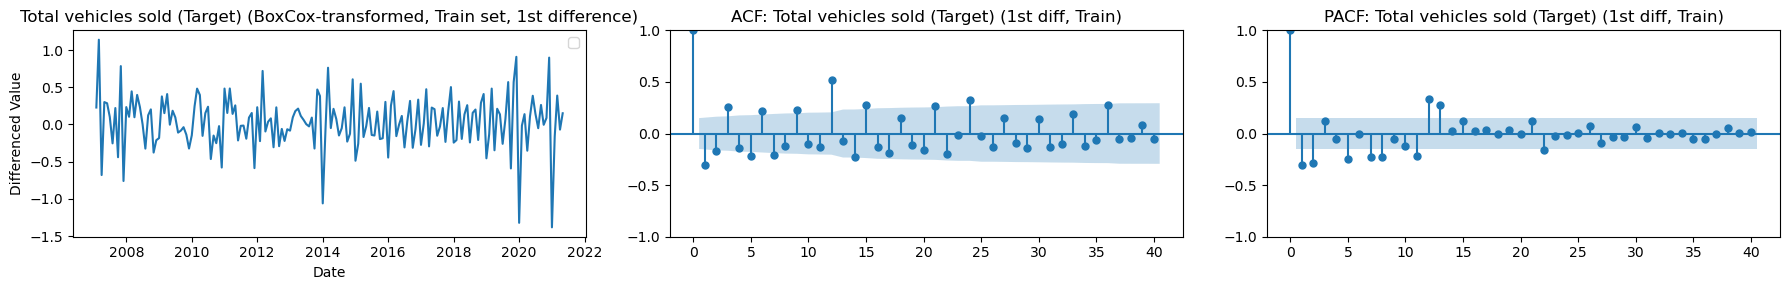

==== Total vehicles sold (Target) (1st diff) ====
ADF Statistic: -3.482309674926358
ADF p-value: 0.008453213503776685
ADF Critical Value (1%): -3.4722
ADF Critical Value (5%): -2.8799
ADF Critical Value (10%): -2.5766
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.07044683885481265
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



C:\Users\dylan\AppData\Local\Temp\ipykernel_38576\2086692949.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")


In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Apply first difference to BoxCox-transformed train split for all features and target
diff_results = {}

for col in features + [target]:
    train_bc = boxcox_all[col][:len(y_train)]
    train_bc_diff = np.diff(train_bc, n=1)
    diff_results[col] = train_bc_diff

    # Plot differenced series + ACF/PACF side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 3))
    axes[0].plot(df["Time Period (T)"][1:len(y_train)], train_bc_diff),# label=f"{col} (BoxCox, Train, 1st diff)")
    axes[0].set_title(f"{col} (BoxCox-transformed, Train set, 1st difference)")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Differenced Value")
    axes[0].legend()
    plot_acf(train_bc_diff, ax=axes[1], lags=40)
    axes[1].set_title(f"ACF: {col} (1st diff, Train)")
    plot_pacf(train_bc_diff, ax=axes[2], lags=40, method='ywm')
    axes[2].set_title(f"PACF: {col} (1st diff, Train)")
    plt.tight_layout()
    plt.show()

    # ADF test
    adf_result_diff = adfuller(train_bc_diff)
    # KPSS test
    kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")

    print(f"\033[1m==== {col} (1st diff) ====\033[0m")
    print("ADF Statistic:", adf_result_diff[0])
    print("ADF p-value:", adf_result_diff[1])
    for key, value in adf_result_diff[4].items():
        print(f"ADF Critical Value ({key}): {value:.4f}")
    if adf_result_diff[1] < 0.05:
        print("\033[1mADF: The series is likely stationary (reject H0).\033[0m")
    else:
        print("\033[1mADF: The series is likely non-stationary (fail to reject H0).\033[0m")
    print("KPSS Statistic:", kpss_result_diff[0])
    print("KPSS p-value:", kpss_result_diff[1])
    for key, value in kpss_result_diff[3].items():
        print(f"KPSS Critical Value ({key}): {value:.4f}")
    if kpss_result_diff[1] < 0.05:
        print("\033[1mKPSS: The series is likely non-stationary (reject H0).\033[0m")
    else:
         print("\033[1mKPSS: The series is likely stationary (fail to reject H0).\033[0m")
print()

#### All 4 variabls and the target ar stationairy after BoxCox +first difference.

In [11]:
# # Apply first difference to BoxCox-transformed train split for all features and target
# diff_results = {}

# for col in features + [target]:
#     train_bc = boxcox_all[col][:len(y_train)]
#     train_bc_diff = np.diff(train_bc, n=1)
#     diff_results[col] = train_bc_diff

#     # Plot differenced series with date on x-axis
#     plt.figure(figsize=(12, 3))
#     plt.plot(df["Time Period (T)"][1:len(y_train)], train_bc_diff, label=f"{col} (BoxCox, Train, 1st diff)")
#     plt.title(f"{col} (BoxCox-transformed, Train set, 1st difference)")
#     plt.xlabel("Date")
#     plt.ylabel("Differenced Value")
#     plt.legend()
#     plt.show()

#     # ADF test
#     adf_result_diff = adfuller(train_bc_diff)
#     # KPSS test
#     kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")

#     print(f"\033[1m==== {col} (1st diff) ====\033[0m")
#     print("ADF Statistic:", adf_result_diff[0])
#     print("ADF p-value:", adf_result_diff[1])
#     for key, value in adf_result_diff[4].items():
#         print(f"ADF Critical Value ({key}): {value:.4f}")
#     if adf_result_diff[1] < 0.05:
#         print("\033[1mADF: The series is likely stationary (reject H0).\033[0m")
#     else:
#         print("\033[1mADF: The series is likely non-stationary (fail to reject H0).\033[0m")
#     print("KPSS Statistic:", kpss_result_diff[0])
#     print("KPSS p-value:", kpss_result_diff[1])
#     for key, value in kpss_result_diff[3].items():
#         print(f"KPSS Critical Value ({key}): {value:.4f}")
#     if kpss_result_diff[1] < 0.05:
#         print("\033[1mKPSS: The series is likely non-stationary (reject H0).\033[0m")
#     else:
#          print("\033[1mKPSS: The series is likely stationary (fail to reject H0).\033[0m")
# print()

#### Plotslater weglaten (dataleakage)

In [12]:
# # First differencing for BoxCox-transformed val and test splits for all features and target
# diff_val_results = {}
# diff_test_results = {}

# for col in features + [target]:
#     # Validation split
#     val_bc = boxcox_all[col][train_end:val_end]
#     val_bc_diff = np.diff(val_bc, n=1)
#     diff_val_results[col] = val_bc_diff

#     plt.figure(figsize=(12, 3))
#     plt.plot(df["Time Period (T)"][train_end+1:val_end], val_bc_diff, label=f"{col} (BoxCox, Val, 1st diff)")
#     plt.title(f"{col} (BoxCox-transformed, Val set, 1st difference)")
#     plt.xlabel("Date")
#     plt.ylabel("Differenced Value")
#     plt.legend()
#     plt.show()

#     print(f"==== {col} (Val, 1st diff) ====")
#     print(val_bc_diff[:10], "...")  # print first 10 values
#     print()

#     # Test split
#     test_bc = boxcox_all[col][val_end:]
#     test_bc_diff = np.diff(test_bc, n=1)
#     diff_test_results[col] = test_bc_diff

#     plt.figure(figsize=(12, 3))
#     plt.plot(test_bc_diff, label=f"{col} (BoxCox, Test, 1st diff)")
#     plt.title(f"{col} (BoxCox-transformed, Test set, 1st difference)")
#     plt.xlabel("Index")
#     plt.ylabel("Differenced Value")
#     plt.legend()
#     plt.show()

#     print(f"==== {col} (Test, 1st diff) ====")
#     print(test_bc_diff[:10], "...")  # print first 10 values
#     print()

## 4a Fit the model for target value

First up auto arima will be used to fit the model for the target value.
Using auto_arima gives  a fast, starting point. It automatically scans a wide range of (p, d, q) and seasonal orders using information criteria (AICc, BIC), so i don’t have to write dozens of loops yourself. This initial model often captures the dominant autocorrelation and differencing structure.

for this seasonal i choose for 3,6 and 12 as seasonal periods, because the data is monthly and has a yearly seasonality.

d will stay on zere since its already defined.

In [13]:
import pmdarima as pm
target_diff = diff_results[target]

# Mogelijke seizoenslengtes (pas aan indien gewenst)
seasonalities = [3, 6, 12]
best_aic = float('inf')
best_model = None
best_m = None

for m in seasonalities:
    print(f"\n=== Probeer SARIMA met seasonality m={m} ===")
    try:
        model = pm.auto_arima(
            y=target_diff,
            d=0,  # al gedifferentieerd
            seasonal=True,
            m=m,
            stepwise=True,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            max_p=5, max_q=5,
            max_d=0,
            max_P=2, max_Q=2,  # seizoenscomponenten
            information_criterion='aic'
        )
        print(f"m={m}: SARIMA order={model.order}, seasonal_order={model.seasonal_order}, AIC={model.aic():.2f}")
        if model.aic() < best_aic:
            best_aic = model.aic()
            best_model = model
            best_m = m
    except Exception as e:
        print(f"m={m}: Error: {e}")

if best_model is not None:
    print(f"\nBeste SARIMA model: m={best_m}, order={best_model.order}, seasonal_order={best_model.seasonal_order}, AIC={best_aic:.2f}")
else:
    print("Geen geschikt SARIMA model gevonden.")


=== Probeer SARIMA met seasonality m=3 ===
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[3] intercept   : AIC=90.108, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[3] intercept   : AIC=136.565, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[3] intercept   : AIC=114.595, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[3] intercept   : AIC=109.219, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[3]             : AIC=136.139, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[3] intercept   : AIC=73.325, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[3] intercept   : AIC=90.806, Time=0.21 sec
 ARIMA(2,0,2)(0,0,2)[3] intercept   : AIC=72.507, Time=0.37 sec
 ARIMA(2,0,2)(1,0,2)[3] intercept   : AIC=72.943, Time=0.54 sec
 ARIMA(1,0,2)(0,0,2)[3] intercept   : AIC=99.230, Time=0.34 sec
 ARIMA(2,0,1)(0,0,2)[3] intercept   : AIC=97.416, Time=0.28 sec
 ARIMA(1,0,1)(0,0,2)[3] intercept   : AIC=97.252, Time=0.22 sec
 ARIMA(2,0,2)(0,0,2)[3]             : AIC=84.224, Time=0.27 sec

Best model:  ARIMA(2,0,2)(0,0,2)[3] intercept
Total fit time: 3.124 seconds


> looking at the auto_arima results, the best model is SARIMAX(0, 0, 1)(1, 0, 1, 12) with an AIC of 150.5 and BIC of 158.2 lets plot evaluate it on the validation set next to determen the predictablity.


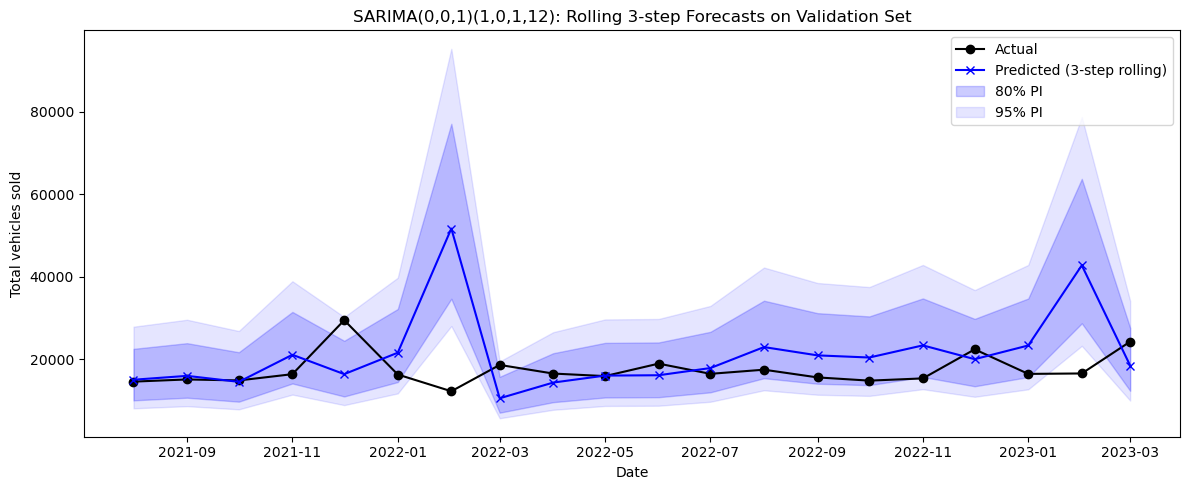

Validation RMSE (3-step rolling): 11806.73
Validation MAPE (3-step rolling): 45.40%
Last fitted SARIMA model AIC: 92.78
Last fitted SARIMA model BIC: 105.51


In [ ]:
# --- Walk-forward (rolling) validation for 3-step-ahead forecasts with prediction intervals ---
history = list(boxcox_all[target][:train_end])  # start with train set
val_bc = boxcox_all[target][train_end:val_end]  # validation set (BoxCox-transformed)
horizon = 3  # 3-step ahead
predictions_bc = []
conf_int_80 = []
conf_int_95 = []

for t in range(len(val_bc) - horizon + 1):
    # Fit model on all history up to t
    model = SARIMAX(
        history,
        order=(0, 0, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    
    # Recursive 3-step forecast with intervals
    temp_history = history.copy()
    for step in range(horizon):
        idx = t + step
        res = fitted_model.get_forecast(steps=1)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history.append(yhat)
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update history with actual for next rolling window
    history.append(val_bc[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]

# Inverse transform intervals
conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

# Plot actual vs predicted (rolling 3-step) with intervals
plt.figure(figsize=(12, 5))
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.plot(x_dates, actuals, label='Actual', marker='o', color='black')
plt.plot(x_dates, val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x', color='blue')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(0,0,1)(1,0,1,12): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# Print AIC and BIC of last fitted model in rolling validation
print(f"Last fitted SARIMA model AIC: {fitted_model.aic:.2f}")
print(f"Last fitted SARIMA model BIC: {fitted_model.bic:.2f}")

looking at the plot the predicted line follows the actual line quite well, with some deviations. The 80% and 95% prediction intervals are  quite wide, indicating that there is a lot of uncertainty in the predictions. This is expected, as the model is only using past values to make predictions and does not take into account any future information. also conscidering the 11806 rsme and 45% mape the prediction is still better than flipping a coin, but not very accurate. 

#### No 80/95% prediction intervals

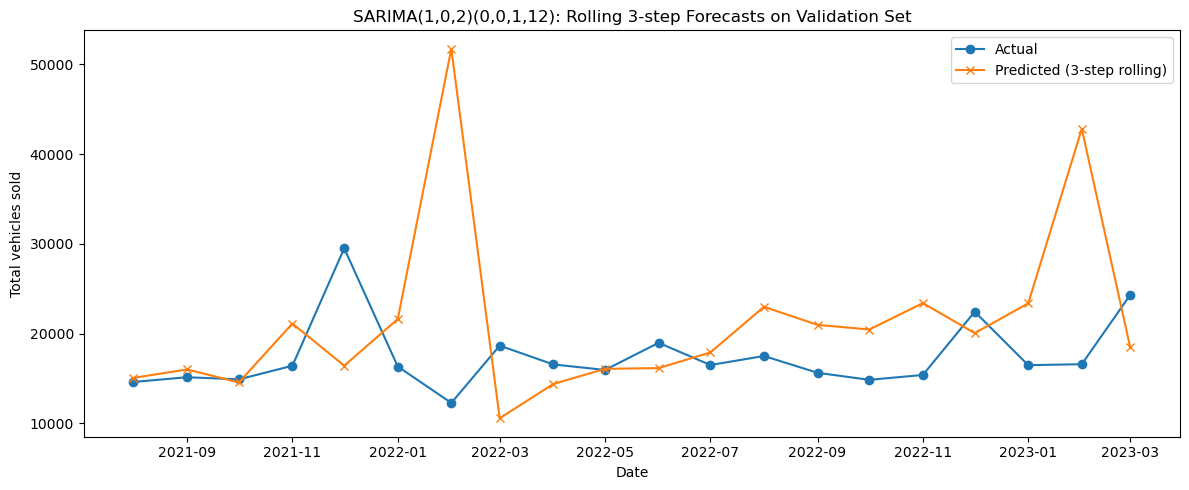

Validation RMSE (3-step rolling): 11806.73
Validation MAPE (3-step rolling): 45.40%
Last fitted SARIMA model AIC: 92.78
Last fitted SARIMA model BIC: 105.51


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # --- Walk-forward (rolling) validation for 3-step-ahead forecasts ---
# history = list(boxcox_all[target][:train_end])  # start with train set
# val_bc = boxcox_all[target][train_end:val_end]  # validation set (BoxCox-transformed)
# horizon = 3  # 3-step ahead
# predictions_bc = []

# for t in range(len(val_bc) - horizon + 1):
#     # Fit model on all history up to t
#     model = SARIMAX(
#         history,
#         order=(0, 0, 1),
#         seasonal_order=(1, 0, 1, 12),
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
#     fitted_model = model.fit(disp=False)
    
#     # Recursive 3-step forecast
#     temp_history = history.copy()
#     for step in range(horizon):
#         idx = t + step
#         yhat = fitted_model.forecast(steps=1)[0]
#         temp_history.append(yhat)
#     predictions_bc.append(yhat)  # Only keep the 3rd step prediction

#     # Update history with actual for next rolling window
#     history.append(val_bc[t])

# # Inverse BoxCox transform
# lam, shift = boxcox_lambdas_all[target]
# def inv_boxcox(y, lam):
#     if lam == 0:
#         return np.exp(y)
#     else:
#         return np.power(lam * y + 1, 1/lam)

# val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
# actuals = y_val.values[horizon-1:]

# # Plot actual vs predicted (rolling 3-step)
# plt.figure(figsize=(12, 5))
# plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], actuals, label='Actual', marker='o')
# plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x')
# plt.title('SARIMA(1,0,2)(0,0,1,12): Rolling 3-step Forecasts on Validation Set')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Calculate RMSE and MAPE for rolling 3-step
# rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
# mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
# print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
# print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# # Print AIC and BIC of last fitted model in rolling validation
# print(f"Last fitted SARIMA model AIC: {fitted_model.aic:.2f}")
# print(f"Last fitted SARIMA model BIC: {fitted_model.bic:.2f}")

### Manual tuning

for the manually tuning of the model, i will use the following steps:
1. ill look at the ACF and PACF plots to determine the order of the AR and MA terms.
2. build from the auto_arima model, i will try to improve the model by changing the order of the AR and MA terms, and the seasonal order.

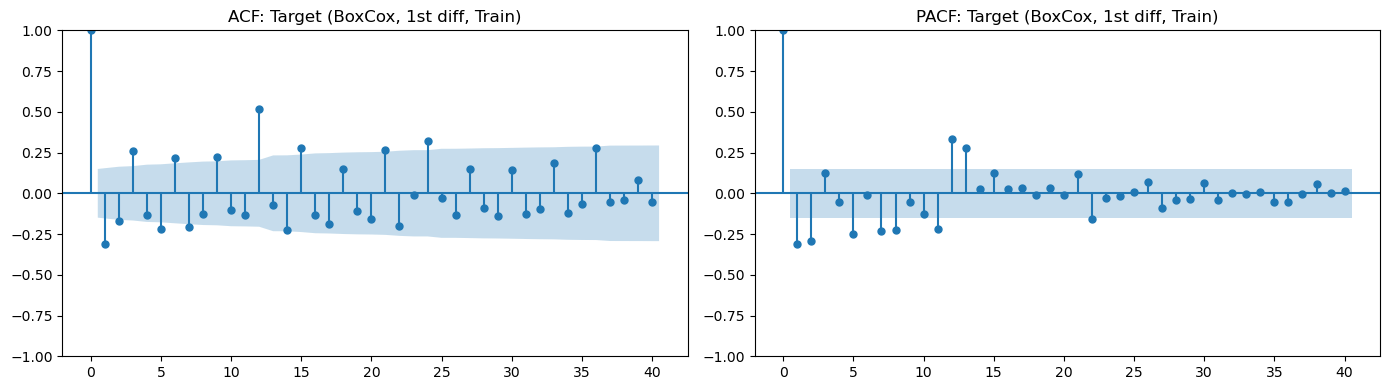

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use the BoxCox-transformed, first-differenced target from the training set
target_diff = diff_results[target]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(target_diff, ax=axes[0], lags=40)
axes[0].set_title('ACF: Target (BoxCox, 1st diff, Train)')
plot_pacf(target_diff, ax=axes[1], lags=40, method='ywm')
axes[1].set_title('PACF: Target (BoxCox, 1st diff, Train)')
plt.tight_layout()
plt.show()

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


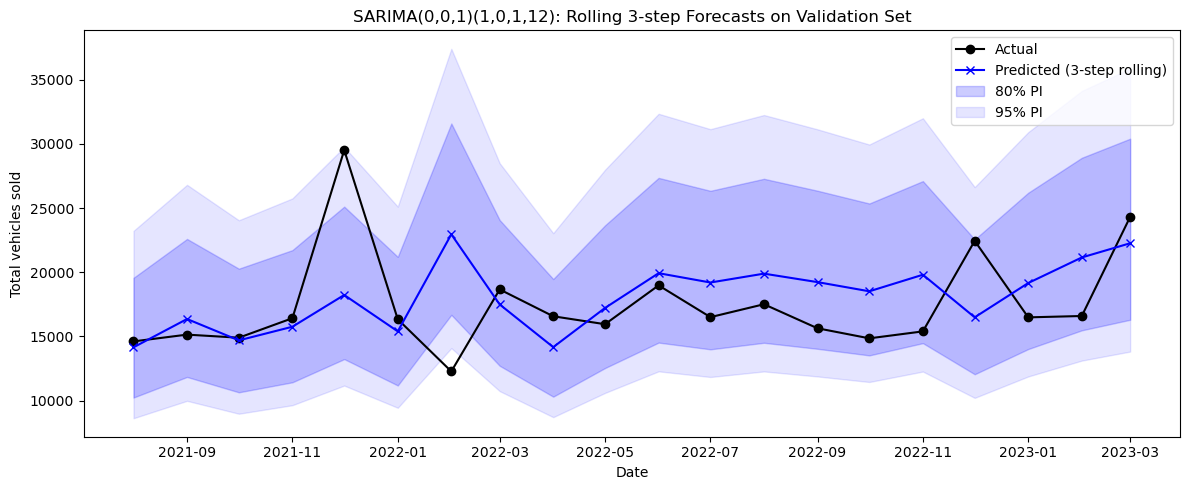

Validation RMSE (3-step rolling): 4359.91
Validation MAPE (3-step rolling): 18.31%
Last fitted SARIMA model AIC: 9.07
Last fitted SARIMA model BIC: 24.95


In [17]:
# --- Walk-forward (rolling) validation for 3-step-ahead forecasts with prediction intervals ---
history = list(boxcox_all[target][:train_end])  # start with train set
val_bc = boxcox_all[target][train_end:val_end]  # validation set (BoxCox-transformed)
horizon = 3  # 3-step ahead
predictions_bc = []
conf_int_80 = []
conf_int_95 = []

for t in range(len(val_bc) - horizon + 1):
    # Fit model on all history up to t
    model = SARIMAX(
        history,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    
    # Recursive 3-step forecast with intervals
    temp_history = history.copy()
    for step in range(horizon):
        idx = t + step
        res = fitted_model.get_forecast(steps=1)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history.append(yhat)
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update history with actual for next rolling window
    history.append(val_bc[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]

# Inverse transform intervals
conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

# Plot actual vs predicted (rolling 3-step) with intervals
plt.figure(figsize=(12, 5))
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.plot(x_dates, actuals, label='Actual', marker='o', color='black')
plt.plot(x_dates, val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x', color='blue')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(0,0,1)(1,0,1,12): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# Print AIC and BIC of last fitted model in rolling validation
print(f"Last fitted SARIMA model AIC: {fitted_model.aic:.2f}")
print(f"Last fitted SARIMA model BIC: {fitted_model.bic:.2f}")

#### 1. test...

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


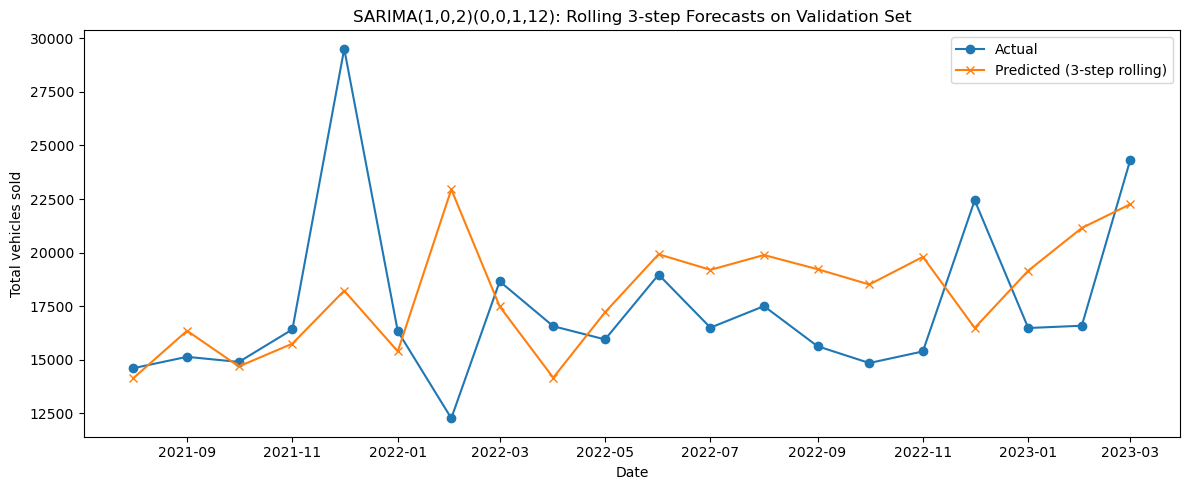

Validation RMSE (3-step rolling): 4359.91
Validation MAPE (3-step rolling): 18.31%
Last fitted SARIMA model AIC: 9.07
Last fitted SARIMA model BIC: 24.95


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Walk-forward (rolling) validation for 3-step-ahead forecasts ---
history = list(boxcox_all[target][:train_end])  # start with train set
val_bc = boxcox_all[target][train_end:val_end]  # validation set (BoxCox-transformed)
horizon = 3  # 3-step ahead
predictions_bc = []

for t in range(len(val_bc) - horizon + 1):
    # Fit model on all history up to t
    model = SARIMAX(
        history,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    
    # Recursive 3-step forecast
    temp_history = history.copy()
    for step in range(horizon):
        idx = t + step
        yhat = fitted_model.forecast(steps=1)[0]
        temp_history.append(yhat)
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction

    # Update history with actual for next rolling window
    history.append(val_bc[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]

# Plot actual vs predicted (rolling 3-step)
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x')
plt.title('SARIMA(1,0,2)(0,0,1,12): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# Print AIC and BIC of last fitted model in rolling validation
print(f"Last fitted SARIMA model AIC: {fitted_model.aic:.2f}")
print(f"Last fitted SARIMA model BIC: {fitted_model.bic:.2f}")

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


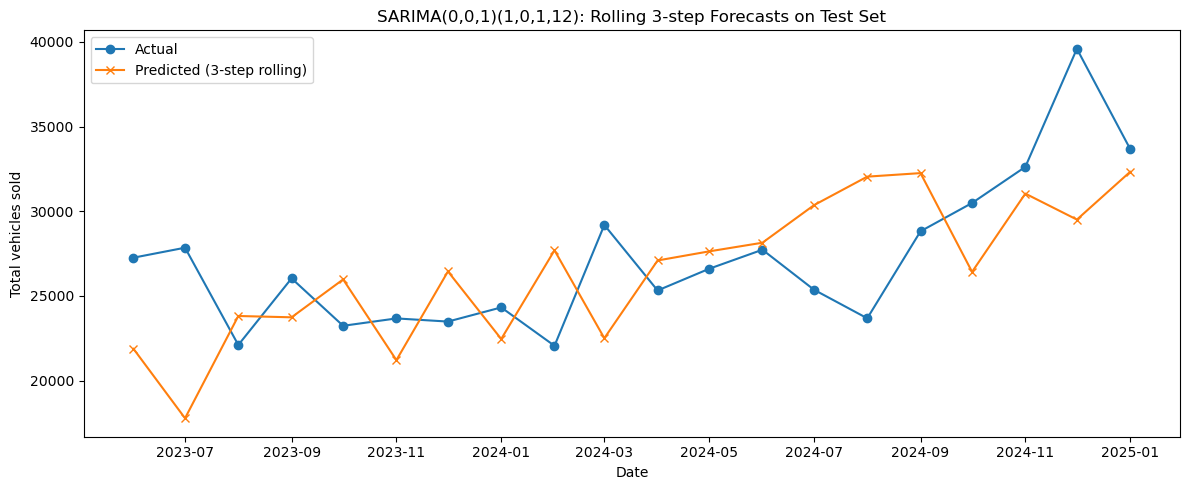

Test RMSE (3-step rolling): 4870.21
Test MAPE (3-step rolling): 14.51%


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Walk-forward (rolling) validation for 3-step-ahead forecasts on TEST set ---
history = list(boxcox_all[target][:val_end])  # start with train+val set
test_bc = boxcox_all[target][val_end:]  # test set (BoxCox-transformed)
horizon = 3  # 3-step ahead
predictions_bc = []

for t in range(len(test_bc) - horizon + 1):
    # Fit model on all history up to t
    model = SARIMAX(
        history,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    
    # Recursive 3-step forecast
    temp_history = history.copy()
    for step in range(horizon):
        idx = t + step
        yhat = fitted_model.forecast(steps=1)[0]
        temp_history.append(yhat)
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction

    # Update history with actual for next rolling window
    history.append(test_bc[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

test_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_test.values[horizon-1:]

# Plot actual vs predicted (rolling 3-step)
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][val_end+horizon-1:], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][val_end+horizon-1:], test_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x')
plt.title('SARIMA(0,0,1)(1,0,1,12): Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, test_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, test_forecast_orig_rolling)
print(f"Test RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Test MAPE (3-step rolling): {mape_rolling:.2%}")

#### lstm

c:\Users\dylan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


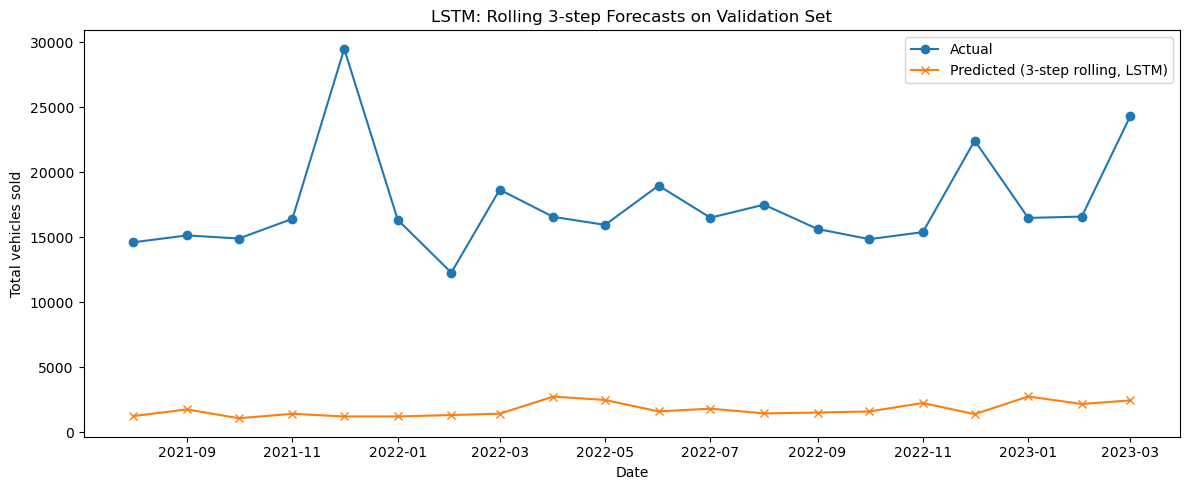

Validation RMSE (3-step rolling, LSTM): 16187.68
Validation MAPE (3-step rolling, LSTM): 89.71%


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- Helper: create lagged features for LSTM ---
def make_lstm_sequences(series, n_lags, horizon):
    X, y = [], []
    for i in range(len(series) - n_lags - horizon + 1):
        X.append(series[i:i+n_lags])
        y.append(series[i+n_lags+horizon-1])  # 3rd step ahead
    return np.array(X), np.array(y)

# Parameters
n_lags = 12  # Use 12 lags (1 year) as input
horizon = 3  # 3-step ahead

# Prepare data
train_bc = boxcox_all[target][:train_end]
val_bc = boxcox_all[target][train_end:val_end]

# Rolling 3-step-ahead forecast
predictions_bc = []
history = list(train_bc)

for t in range(len(val_bc) - horizon + 1):
    # Prepare training sequences from current history
    X_train, y_train = make_lstm_sequences(np.array(history), n_lags, horizon)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Build and fit LSTM (small model for fast rolling fit)
    model = Sequential([
        LSTM(16, input_shape=(n_lags, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=20, batch_size=8, verbose=0)

    # Recursive 3-step forecast
    temp_hist = history.copy()
    for step in range(horizon):
        x_input = np.array(temp_hist[-n_lags:]).reshape((1, n_lags, 1))
        yhat = model.predict(x_input, verbose=0)[0, 0]
        temp_hist.append(yhat)
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction

    # Update history with actual for next rolling window
    history.append(val_bc[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]

# Plot actual vs predicted (rolling 3-step)
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], val_forecast_orig_rolling, label='Predicted (3-step rolling, LSTM)', marker='x')
plt.title('LSTM: Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling, LSTM): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling, LSTM): {mape_rolling:.2%}")

### Gasoline price 

Optimal lags sorted by AIC:
Lag: 6, AIC: 121.18, BIC: 127.39
Lag: 2, AIC: 121.89, BIC: 128.15
Lag: 5, AIC: 122.57, BIC: 128.79
Lag: 4, AIC: 123.32, BIC: 129.55
Lag: 3, AIC: 123.74, BIC: 129.99
Lag: 1, AIC: 125.88, BIC: 132.15

Optimal lags sorted by BIC:
Lag: 6, AIC: 121.18, BIC: 127.39


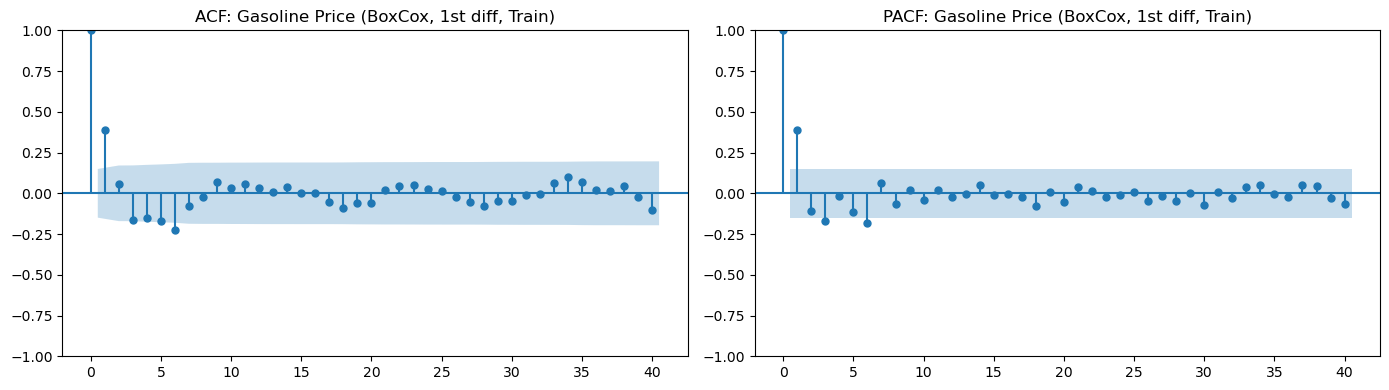

Lag: 2, AIC: 121.89, BIC: 128.15


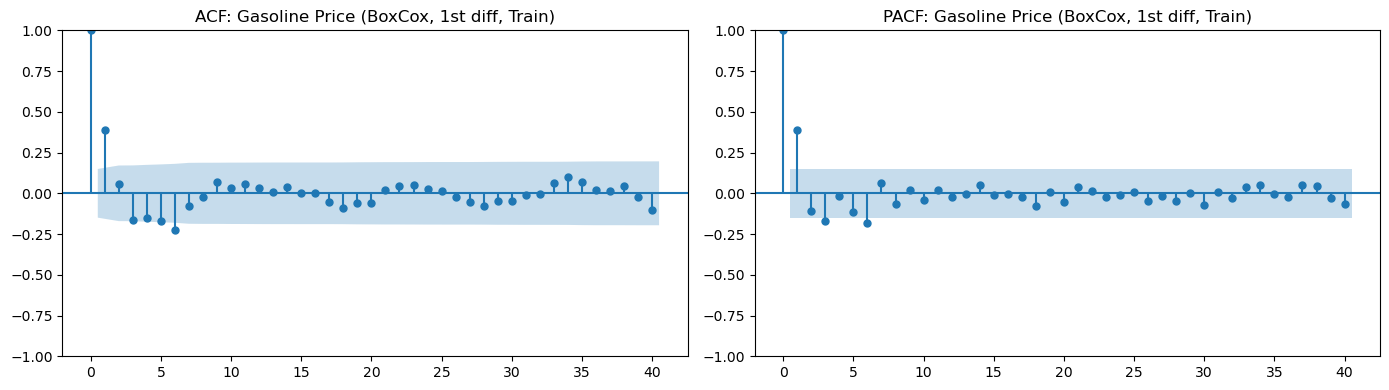

Lag: 5, AIC: 122.57, BIC: 128.79


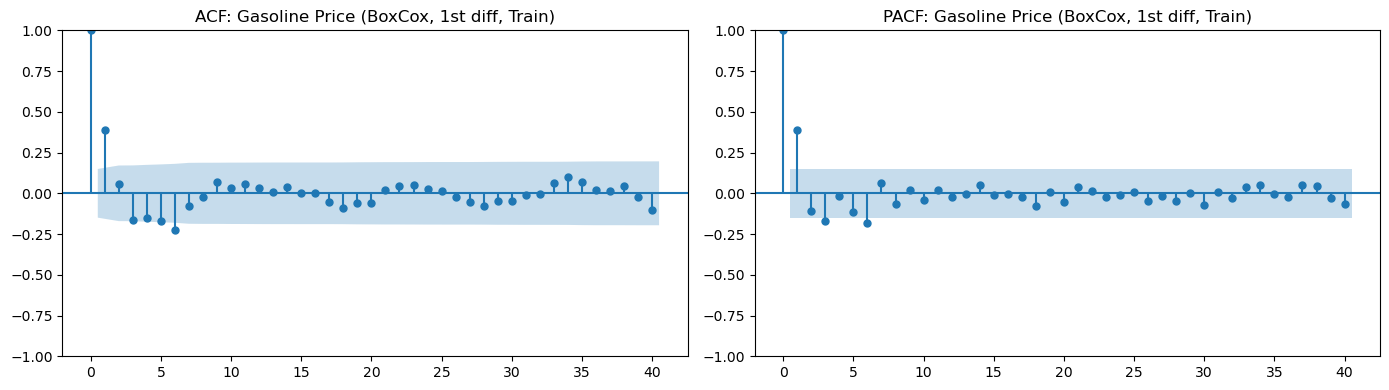

Lag: 4, AIC: 123.32, BIC: 129.55


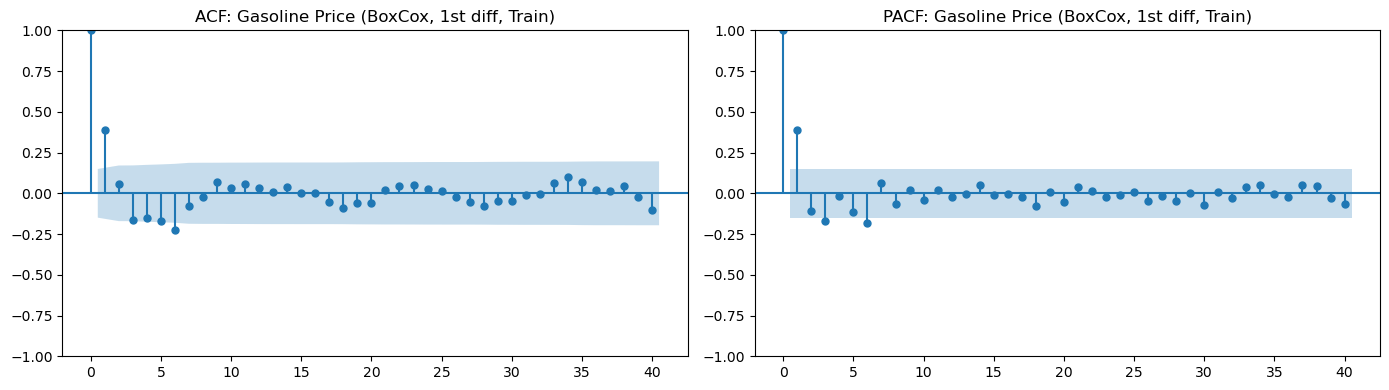

Lag: 3, AIC: 123.74, BIC: 129.99


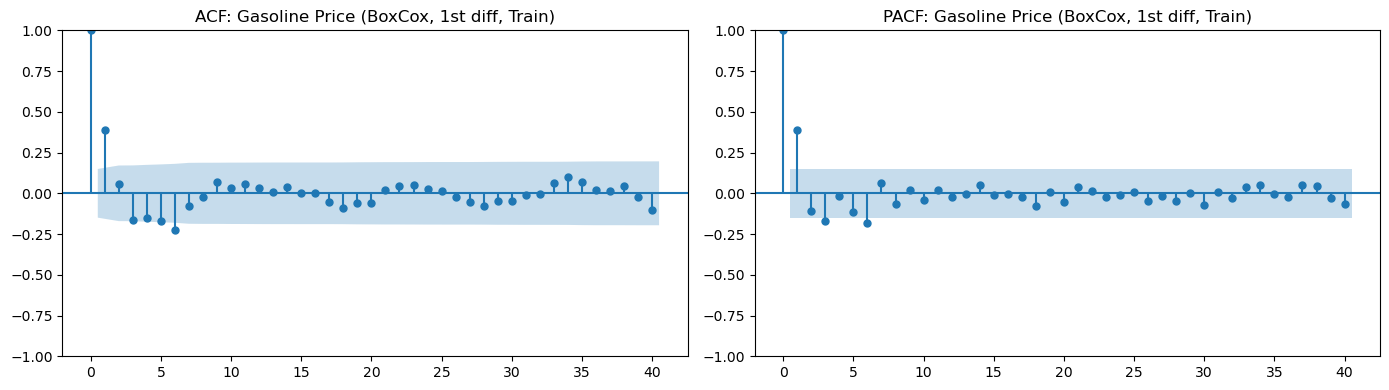

Lag: 1, AIC: 125.88, BIC: 132.15


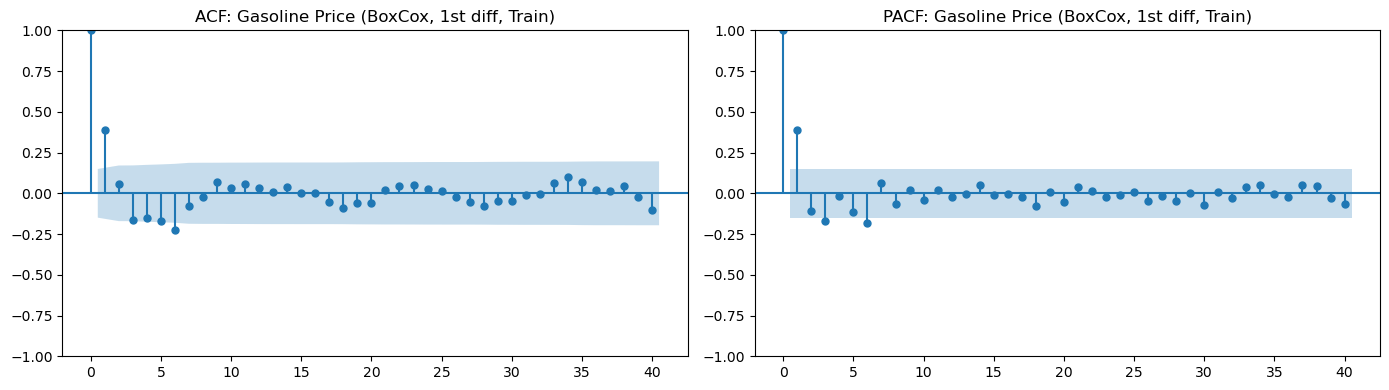

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm

# Prepare exogenous variable: use BoxCox-transformed, 1st-differenced train split for 'Gasoline (Euro95) - Average price (F)'
exog_feature = diff_results['Gasoline (Euro95) - Average price (F)']
target_diff = diff_results[target]

# Try lags 1 to 6 for exogenous variable
max_lag = 6
aic_bic_results = []

for lag in range(1, max_lag + 1):
    # Lag exogenous variable (align with target_diff)
    exog_lagged = np.roll(exog_feature, lag)
    exog_lagged[:lag] = np.nan  # first 'lag' values are invalid
    valid_idx = ~np.isnan(exog_lagged)
    y_valid = target_diff[valid_idx]
    exog_valid = exog_lagged[valid_idx].reshape(-1, 1)
    
    # Fit SARIMAX (ARIMA(0,0,0) since already differenced, no AR/MA terms)
    model = sm.tsa.SARIMAX(
        y_valid,
        order=(0, 0, 0),
        exog=exog_valid,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    aic_bic_results.append({
        'lag': lag,
        'AIC': res.aic,
        'BIC': res.bic
    })

# Sort by AIC and BIC
aic_sorted = sorted(aic_bic_results, key=lambda x: x['AIC'])
bic_sorted = sorted(aic_bic_results, key=lambda x: x['BIC'])

print("Optimal lags sorted by AIC:")
for r in aic_sorted:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

print("\nOptimal lags sorted by BIC:")
for r in bic_sorted:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

    # Plot ACF and PACF for the BoxCox-transformed, 1st-differenced gasoline price (train split)
    gas_bc_diff = diff_results['Gasoline (Euro95) - Average price (F)']

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plot_acf(gas_bc_diff, ax=plt.gca(), lags=40)
    plt.title('ACF: Gasoline Price (BoxCox, 1st diff, Train)')

    plt.subplot(1, 2, 2)
    plot_pacf(gas_bc_diff, ax=plt.gca(), lags=40, method='ywm')
    plt.title('PACF: Gasoline Price (BoxCox, 1st diff, Train)')

    plt.tight_layout()
    plt.show()


#### 3 step with interval

In [58]:
print(type(val_y))

<class 'numpy.ndarray'>


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available

Rolling 3-step RMSE: 3797.68
Rolling 3-step MAPE: 15.54%


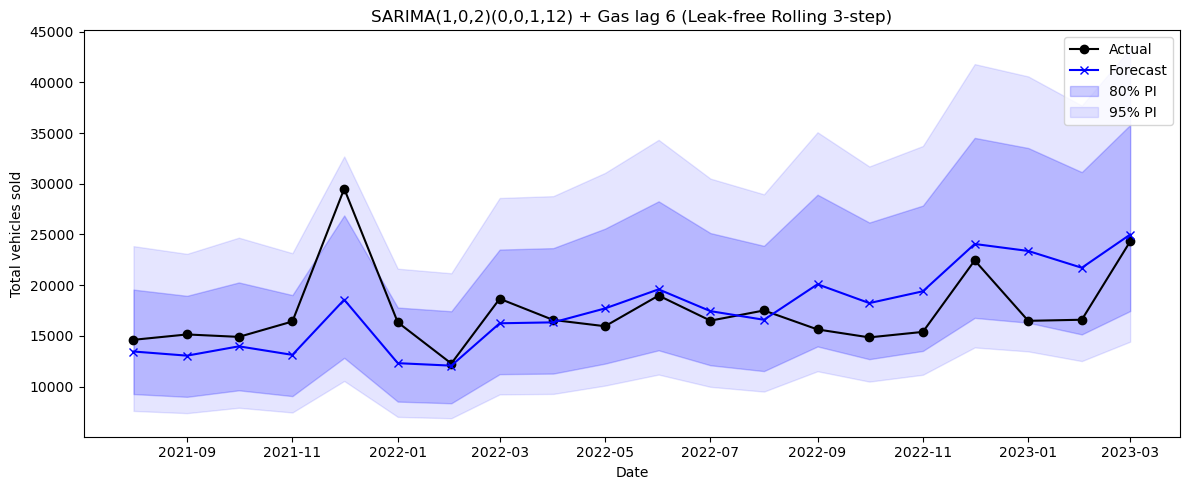

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ─── 1. Prepare data ───────────────────────────────────────────────────────────
gas_bc    = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc = boxcox_all[target]

# history = train up to but **not including** the validation window
history_y   = list(target_bc[:train_end])
history_gas = list(gas_bc[:train_end])

# hold-out slices
val_y   = target_bc[train_end:val_end]
val_gas = gas_bc[   train_end:val_end]

horizon = 3     # 3-step ahead
lag     = 6     # chosen exogenous lag

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # 2a) Build a DataFrame of history + lagged gas
    df_hist = pd.DataFrame({
        'y'  : history_y,
        'gas': history_gas
    })
    df_hist['gas_lag6'] = df_hist['gas'].shift(lag)
    df_hist = df_hist.dropna()

    y_hist    = df_hist['y']
    exog_hist = df_hist['gas_lag6'].values.reshape(-1, 1)

    # 2b) Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog             = exog_hist,
        order            = (1, 0, 2),
        seasonal_order   = (0, 0, 1, 12),
        enforce_stationarity   = False,
        enforce_invertibility   = False
    )
    fitted = model.fit(disp=False)

    # 2c) Construct future exogenous inputs **only** from history_gas
    #     for each of the next `horizon` steps
    gas_future_lags = [
        history_gas[-lag + (i+1)]
        for i in range(horizon)
    ]
    exog_future = np.array(gas_future_lags).reshape(horizon, 1)

    # 2d) Multi-step forecast with exog
    fc = fitted.get_forecast(steps=horizon, exog=exog_future)

    # pull out the 3rd step’s point forecast + intervals
    yhat      = fc.predicted_mean.iloc[-1]
    ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
    ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

    predictions_bc.append(yhat)
    conf_int_80.append((ci80, ci80_u))
    conf_int_95.append((ci95, ci95_u))

    # 2e) Now that we’ve “observed” time t, append the actuals to history
    history_y.append(val_y[t])
    history_gas.append(val_gas[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]

# intervals
ci80_arr = np.array(conf_int_80)
ci95_arr = np.array(conf_int_95)

ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# metrics
rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
mape = mean_absolute_percentage_error(actuals, pred_orig)

print(f"Rolling 3-step RMSE: {rmse:.2f}")
print(f"Rolling 3-step MAPE: {mape:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

plt.figure(figsize=(12,5))
plt.plot(   x_dates, actuals,    marker='o', color='black', label='Actual')
plt.plot(   x_dates, pred_orig, marker='x', color='blue',  label='Forecast')
plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Gas lag 6 (Leak-free Rolling 3-step)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available

Rolling 3-step RMSE: 3797.68
Rolling 3-step MAPE: 15.54%


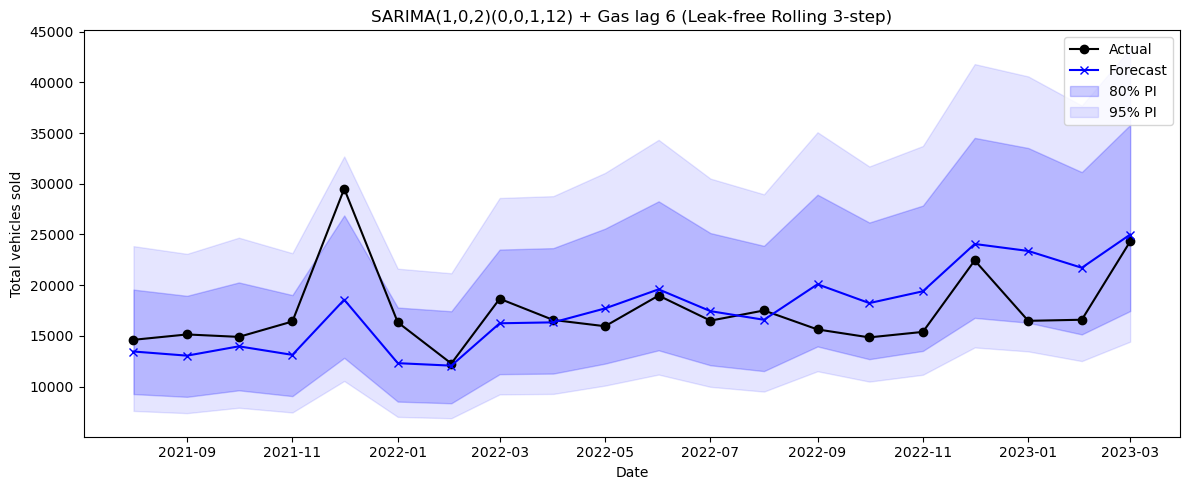

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ─── 1. Prepare data ───────────────────────────────────────────────────────────
gas_bc    = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc = boxcox_all[target]

# history = train up to but **not including** the validation window
history_y   = list(target_bc[:train_end])
history_gas = list(gas_bc[:train_end])

# hold-out slices
val_y   = target_bc[train_end:val_end]
val_gas = gas_bc[   train_end:val_end]

horizon = 3     # 3-step ahead
lag     = 6     # chosen exogenous lag

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # 2a) Build a DataFrame of history + lagged gas
    df_hist = pd.DataFrame({
        'y'  : history_y,
        'gas': history_gas
    })
    df_hist['gas_lag6'] = df_hist['gas'].shift(lag)
    df_hist = df_hist.dropna()

    y_hist    = df_hist['y']
    exog_hist = df_hist['gas_lag6'].values.reshape(-1, 1)

    # 2b) Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog             = exog_hist,
        order            = (1, 0, 2),
        seasonal_order   = (0, 0, 1, 12),
        enforce_stationarity   = False,
        enforce_invertibility   = False
    )
    fitted = model.fit(disp=False)

    # 2c) Construct future exogenous inputs **only** from history_gas
    #     for each of the next `horizon` steps
    gas_future_lags = [
        history_gas[-lag + (i+1)]
        for i in range(horizon)
    ]
    exog_future = np.array(gas_future_lags).reshape(horizon, 1)

    # 2d) Multi-step forecast with exog
    fc = fitted.get_forecast(steps=horizon, exog=exog_future)

    # pull out the 3rd step’s point forecast + intervals
    yhat      = fc.predicted_mean.iloc[-1]
    ci80, ci80_u = fc.conf_int(alpha=0.20).iloc[-1].values
    ci95, ci95_u = fc.conf_int(alpha=0.05).iloc[-1].values

    predictions_bc.append(yhat)
    conf_int_80.append((ci80, ci80_u))
    conf_int_95.append((ci95, ci95_u))

    # 2e) Now that we’ve “observed” time t, append the actuals to history
    history_y.append(val_y[t])
    history_gas.append(val_gas[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]

# intervals
ci80_arr = np.array(conf_int_80)
ci95_arr = np.array(conf_int_95)

ci80_lower = inv_boxcox(ci80_arr[:,0], lam) - shift
ci80_upper = inv_boxcox(ci80_arr[:,1], lam) - shift
ci95_lower = inv_boxcox(ci95_arr[:,0], lam) - shift
ci95_upper = inv_boxcox(ci95_arr[:,1], lam) - shift

# metrics
rmse = np.sqrt(mean_squared_error(actuals, pred_orig))
mape = mean_absolute_percentage_error(actuals, pred_orig)

print(f"Rolling 3-step RMSE: {rmse:.2f}")
print(f"Rolling 3-step MAPE: {mape:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]

plt.figure(figsize=(12,5))
plt.plot(   x_dates, actuals,    marker='o', color='black', label='Actual')
plt.plot(   x_dates, pred_orig, marker='x', color='blue',  label='Forecast')
plt.fill_between(x_dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Gas lag 6 (Leak-free Rolling 3-step)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()


In [50]:
type(fc.predicted_mean)
fc.predicted_mean.index
fc.conf_int(alpha=0.20).shape

(3, 2)

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

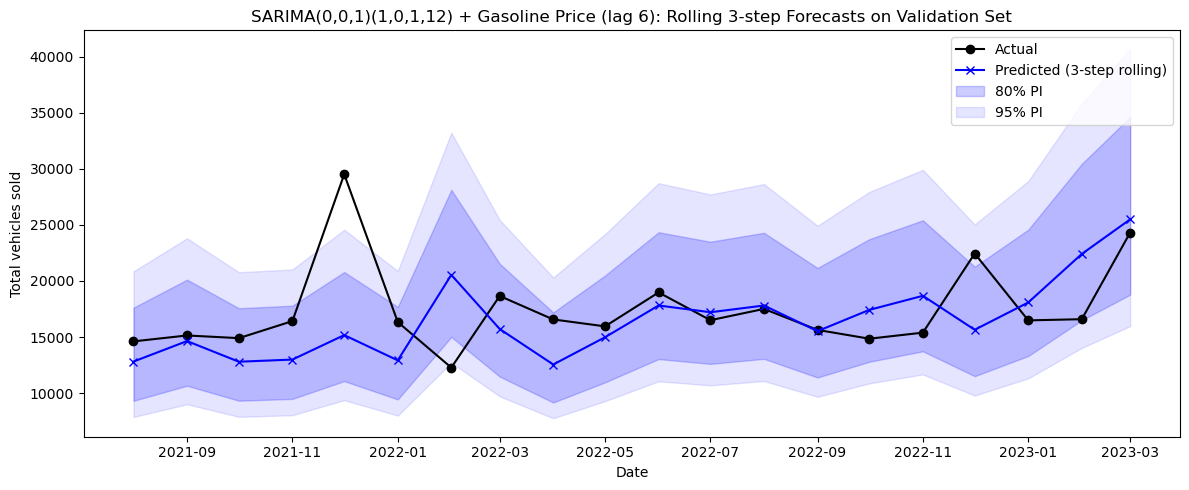

Validation RMSE (3-step rolling): 4658.33
Validation MAPE (3-step rolling): 18.24%
Last fitted SARIMA model AIC: 4.92
Last fitted SARIMA model BIC: 23.77


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use BoxCox-transformed target and exogenous variable (gasoline price)
gas_bc = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc = boxcox_all[target]

history_y = list(target_bc[:train_end])
history_gas = list(gas_bc[:train_end])
val_bc = target_bc[train_end:val_end]
val_gas = gas_bc[train_end:val_end]

horizon = 3  # 3-step ahead
predictions_bc = []
conf_int_80 = []
conf_int_95 = []

for t in range(len(val_bc) - horizon + 1):
    # Prepare lagged exogenous for current history (lag 6)
    gas_hist = np.array(history_gas)
    gas_hist_lag6 = np.roll(gas_hist, 6)
    gas_hist_lag6[:6] = np.nan
    y_hist = np.array(history_y)[6:]
    gas_hist_lag6 = gas_hist_lag6[6:]
    
    # Fit model on all history up to t
    model = SARIMAX(
        y_hist,
        exog=gas_hist_lag6.reshape(-1, 1),
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    
    # Recursive 3-step forecast with intervals
    temp_history_y = history_y.copy()
    temp_history_gas = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        gas_exog_full = np.concatenate([np.array(temp_history_gas)[-6:], [val_gas[idx]]])
        gas_exog_lag6 = np.roll(gas_exog_full, 6)[6:]
        exog_next = gas_exog_lag6.reshape(-1, 1)
        res = fitted_model.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_gas.append(val_gas[idx])
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update history with actuals for next rolling window
    history_y.append(val_bc[t])
    history_gas.append(val_gas[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]

# Inverse transform intervals
conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

# Plot actual vs predicted (rolling 3-step) with intervals
plt.figure(figsize=(12, 5))
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.plot(x_dates, actuals, label='Actual', marker='o', color='black')
plt.plot(x_dates, val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x', color='blue')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Gasoline Price (lag 6): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# Print AIC and BIC of last fitted model in rolling validation
print(f"Last fitted SARIMA model AIC: {fitted_model.aic:.2f}")
print(f"Last fitted SARIMA model BIC: {fitted_model.bic:.2f}")

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

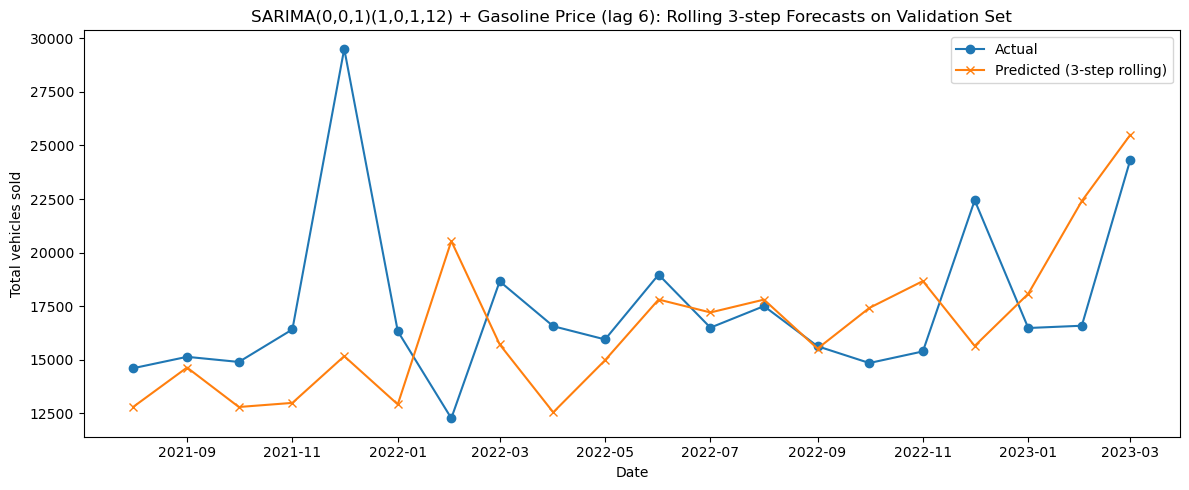

Validation RMSE (3-step rolling): 4658.33
Validation MAPE (3-step rolling): 18.24%


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use BoxCox-transformed target and exogenous variable (gasoline price)
gas_bc = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc = boxcox_all[target]

history_y = list(target_bc[:train_end])
history_gas = list(gas_bc[:train_end])
val_bc = target_bc[train_end:val_end]
val_gas = gas_bc[train_end:val_end]

horizon = 3  # 3-step ahead
predictions_bc = []

for t in range(len(val_bc) - horizon + 1):
    # Prepare lagged exogenous for current history (lag 6)
    gas_hist = np.array(history_gas)
    gas_hist_lag6 = np.roll(gas_hist, 6)
    gas_hist_lag6[:6] = np.nan
    y_hist = np.array(history_y)[6:]
    gas_hist_lag6 = gas_hist_lag6[6:]
    
    # Fit model on all history up to t
    model = SARIMAX(
        y_hist,
        exog=gas_hist_lag6.reshape(-1, 1),
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    
    # Recursive 3-step forecast
    temp_history_y = history_y.copy()
    temp_history_gas = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        gas_exog_full = np.concatenate([np.array(temp_history_gas)[-6:], [val_gas[idx]]])
        gas_exog_lag6 = np.roll(gas_exog_full, 6)[6:]
        exog_next = gas_exog_lag6.reshape(-1, 1)
        yhat = fitted_model.forecast(steps=1, exog=exog_next)[0]
        temp_history_y.append(yhat)
        temp_history_gas.append(val_gas[idx])
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction

    # Update history with actuals for next rolling window
    history_y.append(val_bc[t])
    history_gas.append(val_gas[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]

# Plot actual vs predicted (rolling 3-step)
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Gasoline Price (lag 6): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

#### 1 step

In [24]:
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Use BoxCox-transformed target and exogenous variable
# gas_bc = boxcox_all['Gasoline (Euro95) - Average price (F)']
# target_bc = boxcox_all[target]

# history_y = list(target_bc[:train_end])
# history_gas = list(gas_bc[:train_end])
# val_bc = target_bc[train_end:val_end]
# val_gas = gas_bc[train_end:val_end]

# predictions_bc = []

# for t in range(len(val_bc)):
#     # Prepare lagged exogenous for current history
#     gas_hist = np.array(history_gas)
#     gas_hist_lag6 = np.roll(gas_hist, 6)
#     gas_hist_lag6[:6] = np.nan
#     y_hist = np.array(history_y)[6:]
#     gas_hist_lag6 = gas_hist_lag6[6:]
    
#     # Fit model on all history up to t
#     model = SARIMAX(
#         y_hist,
#         exog=gas_hist_lag6.reshape(-1, 1),
#         order=(1, 0, 1),
#         seasonal_order=(1, 0, 1, 12),
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
#     fitted_model = model.fit(disp=False)
    
#     # Prepare exogenous for next step (lag 6)
#     # Use last 6 from history + current val_gas
#     gas_exog_full = np.concatenate([gas_hist[-6:], [val_gas[t]]])
#     gas_exog_lag6 = np.roll(gas_exog_full, 6)[6:]
    
#     yhat = fitted_model.forecast(steps=1, exog=gas_exog_lag6.reshape(-1, 1))[0]
#     predictions_bc.append(yhat)
    
#     # Update history
#     history_y.append(val_bc[t])
#     history_gas.append(val_gas[t])

# # Inverse BoxCox transform
# lam, shift = boxcox_lambdas_all[target]
# def inv_boxcox(y, lam):
#     if lam == 0:
#         return np.exp(y)
#     else:
#         return np.power(lam * y + 1, 1/lam)

# val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
# actuals = y_val.values

# # Plot actual vs predicted (rolling)
# plt.figure(figsize=(12, 5))
# plt.plot(df["Time Period (T)"][train_end:val_end], actuals, label='Actual', marker='o')
# plt.plot(df["Time Period (T)"][train_end:val_end], val_forecast_orig_rolling, label='Predicted (rolling)', marker='x')
# plt.title('SARIMA(0,0,1)(1,0,1,12) + Gasoline Price (lag 6): Rolling 1-step Forecasts on Validation Set')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Calculate RMSE and MAPE for rolling
# rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
# mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
# print(f"Validation RMSE (rolling): {rmse_rolling:.2f}")
# print(f"Validation MAPE (rolling): {mape_rolling:.2%}")

### Company car tax rate (%)

In [25]:
import statsmodels.api as sm

# Prepare exogenous variable: use BoxCox-transformed, 1st-differenced train split for 'Company car tax rate (%)'
exog_feature = diff_results['Company car tax rate (%)']
target_diff = diff_results[target]

# Try lags 1 to 6 for exogenous variable
max_lag = 6
aic_bic_results = []

for lag in range(1, max_lag + 1):
    # Lag exogenous variable (align with target_diff)
    exog_lagged = np.roll(exog_feature, lag)
    exog_lagged[:lag] = np.nan  # first 'lag' values are invalid
    valid_idx = ~np.isnan(exog_lagged)
    y_valid = target_diff[valid_idx]
    exog_valid = exog_lagged[valid_idx].reshape(-1, 1)
    
    # Fit SARIMAX (ARIMA(0,0,0) since already differenced, no AR/MA terms)
    model = sm.tsa.SARIMAX(
        y_valid,
        order=(0, 0, 0),
        exog=exog_valid,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    aic_bic_results.append({
        'lag': lag,
        'AIC': res.aic,
        'BIC': res.bic
    })

# Sort by AIC and BIC
aic_sorted = sorted(aic_bic_results, key=lambda x: x['AIC'])
bic_sorted = sorted(aic_bic_results, key=lambda x: x['BIC'])

print("Optimal lags sorted by AIC:")
for r in aic_sorted:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

print("\nOptimal lags sorted by BIC:")
for r in bic_sorted:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

Optimal lags sorted by AIC:
Lag: 3, AIC: 121.97, BIC: 128.22
Lag: 6, AIC: 122.87, BIC: 129.08
Lag: 4, AIC: 123.14, BIC: 129.37
Lag: 5, AIC: 123.54, BIC: 129.77
Lag: 2, AIC: 124.15, BIC: 130.41
Lag: 1, AIC: 127.14, BIC: 133.42

Optimal lags sorted by BIC:
Lag: 3, AIC: 121.97, BIC: 128.22
Lag: 6, AIC: 122.87, BIC: 129.08
Lag: 4, AIC: 123.14, BIC: 129.37
Lag: 5, AIC: 123.54, BIC: 129.77
Lag: 2, AIC: 124.15, BIC: 130.41
Lag: 1, AIC: 127.14, BIC: 133.42


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


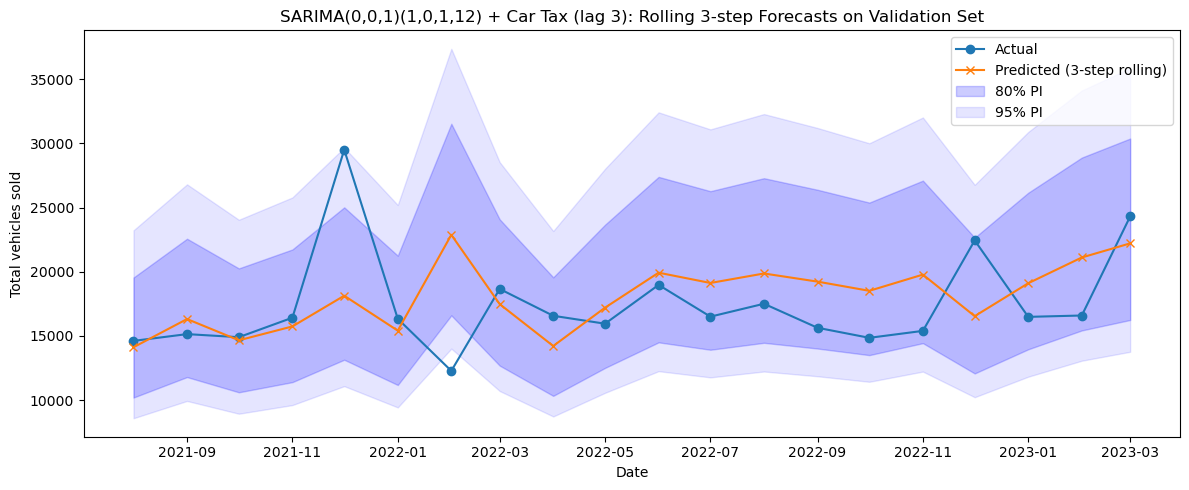

Validation RMSE (3-step rolling): 4351.58
Validation MAPE (3-step rolling): 18.22%


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# BoxCox-transformed target and exogenous variable
car_tax_bc = boxcox_all['Company car tax rate (%)']
target_bc = boxcox_all[target]

history_y = list(target_bc[:train_end])
history_tax = list(car_tax_bc[:train_end])
val_bc = target_bc[train_end:val_end]
val_tax = car_tax_bc[train_end:val_end]

horizon = 3
predictions_bc = []
conf_int_80 = []
conf_int_95 = []

for t in range(len(val_bc) - horizon + 1):
    # Prepare lagged exogenous for current history (lag 3)
    tax_hist = np.array(history_tax)
    tax_hist_lag3 = np.roll(tax_hist, 3)
    tax_hist_lag3[:3] = np.nan
    y_hist = np.array(history_y)[3:]
    tax_hist_lag3 = tax_hist_lag3[3:]

    # Fit model on all history up to t
    model = SARIMAX(
        y_hist,
        exog=tax_hist_lag3.reshape(-1, 1),
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y = history_y.copy()
    temp_history_tax = history_tax.copy()
    for step in range(horizon):
        idx = t + step
        tax_exog_full = np.concatenate([np.array(temp_history_tax)[-3:], [val_tax[idx]]])
        tax_exog_lag3 = np.roll(tax_exog_full, 3)[3:]
        exog_next = tax_exog_lag3.reshape(-1, 1)
        res = fitted_model.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_tax.append(val_tax[idx])
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update history with actuals for next rolling window
    history_y.append(val_bc[t])
    history_tax.append(val_tax[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]

# Inverse transform intervals
conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

# Plot actual vs predicted (rolling 3-step) with intervals
plt.figure(figsize=(12, 5))
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Car Tax (lag 3): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

#### 1 step (Delete)

In [27]:
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Use BoxCox-transformed target and exogenous variable (car tax)
# car_tax_bc = boxcox_all['Company car tax rate (%)']
# target_bc = boxcox_all[target]

# history_y = list(target_bc[:train_end])
# history_tax = list(car_tax_bc[:train_end])
# val_bc = target_bc[train_end:val_end]
# val_tax = car_tax_bc[train_end:val_end]

# predictions_bc = []

# for t in range(len(val_bc)):
#     # Prepare lagged exogenous for current history (lag 3)
#     tax_hist = np.array(history_tax)
#     tax_hist_lag3 = np.roll(tax_hist, 3)
#     tax_hist_lag3[:3] = np.nan
#     y_hist = np.array(history_y)[3:]
#     tax_hist_lag3 = tax_hist_lag3[3:]
    
#     # Fit model on all history up to t
#     model = SARIMAX(
#         y_hist,
#         exog=tax_hist_lag3.reshape(-1, 1),
#         order=(0, 0, 1),
#         seasonal_order=(1, 0, 1, 12),
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
#     fitted_model = model.fit(disp=False)
    
#     # Prepare exogenous for next step (lag 3)
#     # Use last 3 from history + current val_tax
#     tax_exog_full = np.concatenate([tax_hist[-3:], [val_tax[t]]])
#     tax_exog_lag3 = np.roll(tax_exog_full, 3)[3:]
    
#     yhat = fitted_model.forecast(steps=1, exog=tax_exog_lag3.reshape(-1, 1))[0]
#     predictions_bc.append(yhat)
    
#     # Update history
#     history_y.append(val_bc[t])
#     history_tax.append(val_tax[t])

# # Inverse BoxCox transform
# lam, shift = boxcox_lambdas_all[target]
# def inv_boxcox(y, lam):
#     if lam == 0:
#         return np.exp(y)
#     else:
#         return np.power(lam * y + 1, 1/lam)

# val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
# actuals = y_val.values

# # Plot actual vs predicted (rolling)
# plt.figure(figsize=(12, 5))
# plt.plot(df["Time Period (T)"][train_end:val_end], actuals, label='Actual', marker='o')
# plt.plot(df["Time Period (T)"][train_end:val_end], val_forecast_orig_rolling, label='Predicted (rolling)', marker='x')
# plt.title('SARIMA(0,0,1)(1,0,1,12) + Car Tax (lag 3): Rolling 1-step Forecasts on Validation Set')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Calculate RMSE and MAPE for rolling
# rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
# mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
# print(f"Validation RMSE (rolling): {rmse_rolling:.2f}")
# print(f"Validation MAPE (rolling): {mape_rolling:.2%}")

### Google Home Charging

In [28]:
import statsmodels.api as sm

# Use BoxCox-transformed, 1st-differenced train split for 'Home charging (G)'
exog_feature = diff_results['Home charging (G)']
target_diff = diff_results[target]

# Try lags 1 to 6 for exogenous variable
max_lag = 6

aic_bic_results_homechg = []

for lag in range(1, max_lag + 1):
    # Lag exogenous variable (align with target_diff)
    exog_lagged = np.roll(exog_feature, lag)
    exog_lagged[:lag] = np.nan  # first 'lag' values are invalid
    valid_idx = ~np.isnan(exog_lagged)
    y_valid = target_diff[valid_idx]
    exog_valid = exog_lagged[valid_idx].reshape(-1, 1)
    
    # Fit SARIMAX (ARIMA(0,0,0) since already differenced, no AR/MA terms)
    model = sm.tsa.SARIMAX(
        y_valid,
        order=(0, 0, 0),
        exog=exog_valid,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    aic_bic_results_homechg.append({
        'lag': lag,
        'AIC': res.aic,
        'BIC': res.bic
    })

# Sort by AIC and BIC
aic_sorted_homechg = sorted(aic_bic_results_homechg, key=lambda x: x['AIC'])
bic_sorted_homechg = sorted(aic_bic_results_homechg, key=lambda x: x['BIC'])

print("Optimal lags for Home charging (G) sorted by AIC:")
for r in aic_sorted_homechg:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

print("\nOptimal lags for Home charging (G) sorted by BIC:")
for r in bic_sorted_homechg:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

Optimal lags for Home charging (G) sorted by AIC:
Lag: 5, AIC: 120.82, BIC: 127.04
Lag: 4, AIC: 121.93, BIC: 128.17
Lag: 3, AIC: 123.11, BIC: 129.36
Lag: 6, AIC: 123.32, BIC: 129.54
Lag: 2, AIC: 124.16, BIC: 130.42
Lag: 1, AIC: 126.97, BIC: 133.25

Optimal lags for Home charging (G) sorted by BIC:
Lag: 5, AIC: 120.82, BIC: 127.04
Lag: 4, AIC: 121.93, BIC: 128.17
Lag: 3, AIC: 123.11, BIC: 129.36
Lag: 6, AIC: 123.32, BIC: 129.54
Lag: 2, AIC: 124.16, BIC: 130.42
Lag: 1, AIC: 126.97, BIC: 133.25


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

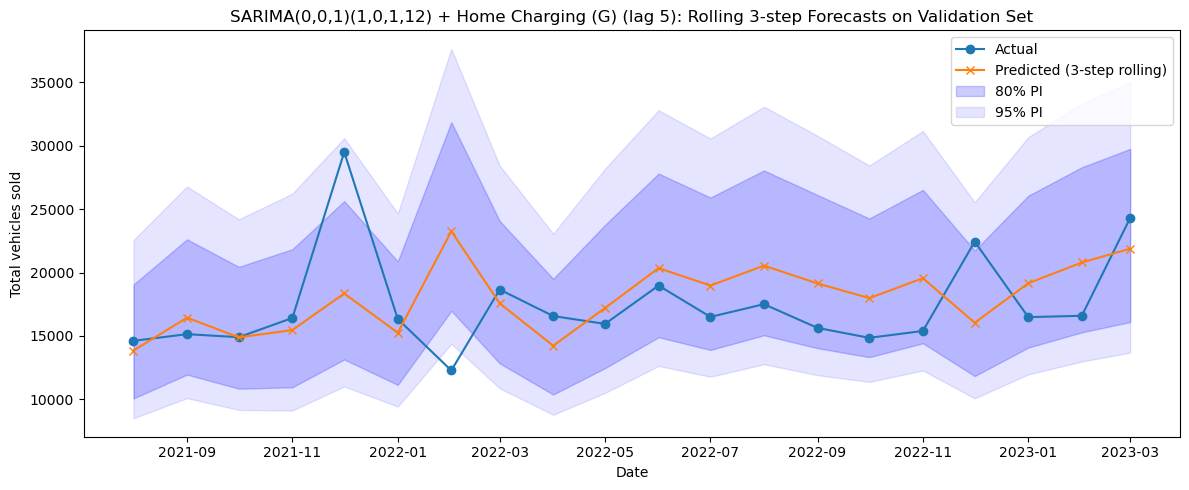

Validation RMSE (3-step rolling): 4393.56
Validation MAPE (3-step rolling): 18.58%


In [29]:
### 3 step

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use BoxCox-transformed target and exogenous variable (home charging)
homechg_bc = boxcox_all['Home charging (G)']
target_bc = boxcox_all[target]

history_y = list(target_bc[:train_end])
history_homechg = list(homechg_bc[:train_end])
val_bc = target_bc[train_end:val_end]
val_homechg = homechg_bc[train_end:val_end]

horizon = 3  # 3-step ahead
predictions_bc = []
conf_int_80 = []
conf_int_95 = []

for t in range(len(val_bc) - horizon + 1):
    # Prepare lagged exogenous for current history (lag 5)
    homechg_hist = np.array(history_homechg)
    homechg_hist_lag5 = np.roll(homechg_hist, 5)
    homechg_hist_lag5[:5] = np.nan
    y_hist = np.array(history_y)[5:]
    homechg_hist_lag5 = homechg_hist_lag5[5:]
    
    # Fit model on all history up to t
    model = SARIMAX(
        y_hist,
        exog=homechg_hist_lag5.reshape(-1, 1),
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    
    # Recursive 3-step forecast with intervals
    temp_history_y = history_y.copy()
    temp_history_homechg = history_homechg.copy()
    for step in range(horizon):
        idx = t + step
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-5:], [val_homechg[idx]]])
        homechg_exog_lag5 = np.roll(homechg_exog_full, 5)[5:]
        exog_next = homechg_exog_lag5.reshape(-1, 1)
        res = fitted_model.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_homechg.append(val_homechg[idx])
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update history with actuals for next rolling window
    history_y.append(val_bc[t])
    history_homechg.append(val_homechg[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]

# Inverse transform intervals
conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

# Plot actual vs predicted (rolling 3-step) with intervals
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(df["Time Period (T)"][train_end+horizon-1:val_end], ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(df["Time Period (T)"][train_end+horizon-1:val_end], ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Home Charging (G) (lag 5): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

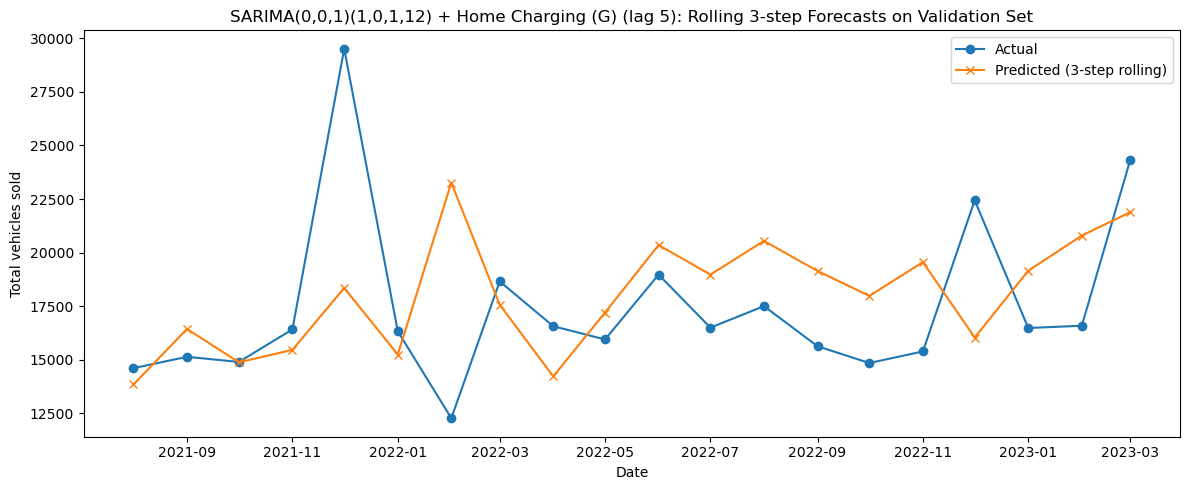

Validation RMSE (3-step rolling): 4393.56
Validation MAPE (3-step rolling): 18.58%


In [30]:
### 3 step

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use BoxCox-transformed target and exogenous variable (home charging)
homechg_bc = boxcox_all['Home charging (G)']
target_bc = boxcox_all[target]

history_y = list(target_bc[:train_end])
history_homechg = list(homechg_bc[:train_end])
val_bc = target_bc[train_end:val_end]
val_homechg = homechg_bc[train_end:val_end]

horizon = 3  # 3-step ahead
predictions_bc = []

for t in range(len(val_bc) - horizon + 1):
    # Prepare lagged exogenous for current history (lag 5)
    homechg_hist = np.array(history_homechg)
    homechg_hist_lag5 = np.roll(homechg_hist, 5)
    homechg_hist_lag5[:5] = np.nan
    y_hist = np.array(history_y)[5:]
    homechg_hist_lag5 = homechg_hist_lag5[5:]
    
    # Fit model on all history up to t
    model = SARIMAX(
        y_hist,
        exog=homechg_hist_lag5.reshape(-1, 1),
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    
    # Recursive 3-step forecast
    temp_history_y = history_y.copy()
    temp_history_homechg = history_homechg.copy()
    for step in range(horizon):
        idx = t + step
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-5:], [val_homechg[idx]]])
        homechg_exog_lag5 = np.roll(homechg_exog_full, 5)[5:]
        exog_next = homechg_exog_lag5.reshape(-1, 1)
        yhat = fitted_model.forecast(steps=1, exog=exog_next)[0]
        temp_history_y.append(yhat)
        temp_history_homechg.append(val_homechg[idx])
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction

    # Update history with actuals for next rolling window
    history_y.append(val_bc[t])
    history_homechg.append(val_homechg[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]

# Plot actual vs predicted (rolling 3-step)
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Home Charging (G) (lag 5): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

#### 1 step

In [31]:
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Use BoxCox-transformed target and exogenous variable (home charging)
# homechg_bc = boxcox_all['Home charging (G)']
# target_bc = boxcox_all[target]

# history_y = list(target_bc[:train_end])
# history_homechg = list(homechg_bc[:train_end])
# val_bc = target_bc[train_end:val_end]
# val_homechg = homechg_bc[train_end:val_end]

# predictions_bc = []

# for t in range(len(val_bc)):
#     # Prepare lagged exogenous for current history (lag 5)
#     homechg_hist = np.array(history_homechg)
#     homechg_hist_lag5 = np.roll(homechg_hist, 5)
#     homechg_hist_lag5[:5] = np.nan
#     y_hist = np.array(history_y)[5:]
#     homechg_hist_lag5 = homechg_hist_lag5[5:]
    
#     # Fit model on all history up to t
#     model = SARIMAX(
#         y_hist,
#         exog=homechg_hist_lag5.reshape(-1, 1),
#         order=(0, 0, 1),
#         seasonal_order=(1, 0, 1, 12),
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
#     fitted_model = model.fit(disp=False)
    
#     # Prepare exogenous for next step (lag 5)
#     # Use last 5 from history + current val_homechg
#     homechg_exog_full = np.concatenate([homechg_hist[-5:], [val_homechg[t]]])
#     homechg_exog_lag5 = np.roll(homechg_exog_full, 5)[5:]
    
#     yhat = fitted_model.forecast(steps=1, exog=homechg_exog_lag5.reshape(-1, 1))[0]
#     predictions_bc.append(yhat)
    
#     # Update history
#     history_y.append(val_bc[t])
#     history_homechg.append(val_homechg[t])

# # Inverse BoxCox transform
# lam, shift = boxcox_lambdas_all[target]
# def inv_boxcox(y, lam):
#     if lam == 0:
#         return np.exp(y)
#     else:
#         return np.power(lam * y + 1, 1/lam)

# val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
# actuals = y_val.values

# # Plot actual vs predicted (rolling)
# plt.figure(figsize=(12, 5))
# plt.plot(df["Time Period (T)"][train_end:val_end], actuals, label='Actual', marker='o')
# plt.plot(df["Time Period (T)"][train_end:val_end], val_forecast_orig_rolling, label='Predicted (rolling)', marker='x')
# plt.title('SARIMA(0,0,1)(1,0,1,12) + Home Charging (G) (lag 5): Rolling 1-step Forecasts on Validation Set')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Calculate RMSE and MAPE for rolling
# rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
# mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
# print(f"Validation RMSE (rolling): {rmse_rolling:.2f}")
# print(f"Validation MAPE (rolling): {mape_rolling:.2%}")

### Consumer confidence (E)

In [32]:
import statsmodels.api as sm

# Use BoxCox-transformed, 1st-differenced train split for 'Consumer confidence (E)'
exog_feature_conf = np.diff(boxcox_all['Consumer confidence (E)'][:train_end], n=1)
target_diff = train_bc_diff

# Try lags 1 to 6 for exogenous variable
max_lag = 6

aic_bic_results_conf = []

for lag in range(1, max_lag + 1):
    # Lag exogenous variable (align with target_diff)
    exog_lagged = np.roll(exog_feature_conf, lag)
    exog_lagged[:lag] = np.nan  # first 'lag' values are invalid
    valid_idx = ~np.isnan(exog_lagged)
    y_valid = target_diff[valid_idx]
    exog_valid = exog_lagged[valid_idx].reshape(-1, 1)
    
    # Fit SARIMAX (ARIMA(0,0,0) since already differenced, no AR/MA terms)
    model = sm.tsa.SARIMAX(
        y_valid,
        order=(0, 0, 0),
        exog=exog_valid,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    aic_bic_results_conf.append({
        'lag': lag,
        'AIC': res.aic,
        'BIC': res.bic
    })

# Sort by AIC and BIC
aic_sorted_conf = sorted(aic_bic_results_conf, key=lambda x: x['AIC'])
bic_sorted_conf = sorted(aic_bic_results_conf, key=lambda x: x['BIC'])

print("Optimal lags for Consumer confidence (E) sorted by AIC:")
for r in aic_sorted_conf:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

print("\nOptimal lags for Consumer confidence (E) sorted by BIC:")
for r in bic_sorted_conf:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

Optimal lags for Consumer confidence (E) sorted by AIC:
Lag: 6, AIC: 123.13, BIC: 129.34
Lag: 4, AIC: 123.38, BIC: 129.62
Lag: 3, AIC: 123.44, BIC: 129.69
Lag: 5, AIC: 123.55, BIC: 129.78
Lag: 2, AIC: 124.23, BIC: 130.49
Lag: 1, AIC: 127.64, BIC: 133.92

Optimal lags for Consumer confidence (E) sorted by BIC:
Lag: 6, AIC: 123.13, BIC: 129.34
Lag: 4, AIC: 123.38, BIC: 129.62
Lag: 3, AIC: 123.44, BIC: 129.69
Lag: 5, AIC: 123.55, BIC: 129.78
Lag: 2, AIC: 124.23, BIC: 130.49
Lag: 1, AIC: 127.64, BIC: 133.92


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


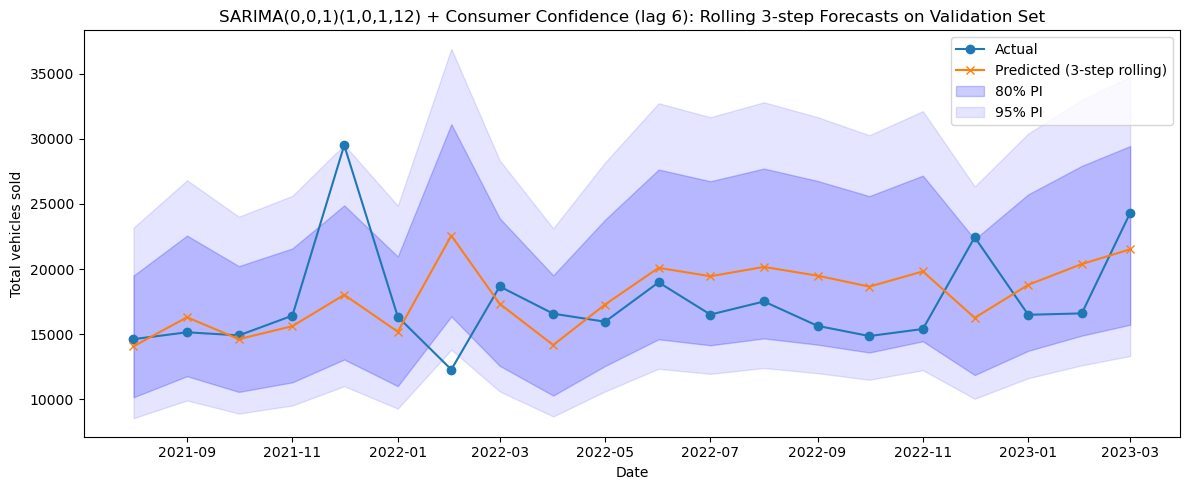

Validation RMSE (3-step rolling): 4372.28
Validation MAPE (3-step rolling): 18.58%


In [34]:
# Summary:
# This code performs rolling 3-step-ahead forecasts on the validation set using a SARIMA model with an exogenous variable
# (Consumer confidence, lagged by 6). For each rolling window, the model is fit on all available history, and a recursive
# 3-step forecast is made. Only the 3rd step prediction is kept for evaluation. The predictions are inverse BoxCox transformed,
# plotted against actuals, and RMSE/MAPE are computed, including 80% and 95% prediction intervals.

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Get BoxCox-transformed series for target and exogenous variable
conf_bc = boxcox_all['Consumer confidence (E)']
target_bc = boxcox_all[target]

# Prepare rolling history lists for target and exogenous variable (train split)
history_y = list(target_bc[:train_end])
history_conf = list(conf_bc[:train_end])

# Validation split for target and exogenous variable
val_bc = target_bc[train_end:val_end]
val_conf = conf_bc[train_end:val_end]

horizon = 3  # Number of steps ahead to forecast
predictions_bc = []
conf_int_80 = []
conf_int_95 = []

# Rolling window: for each possible 3-step-ahead forecast in validation set
for t in range(len(val_bc) - horizon + 1):
    # Prepare lagged exogenous variable (lag 6) for current history
    conf_hist = np.array(history_conf)
    conf_hist_lag6 = np.roll(conf_hist, 6)
    conf_hist_lag6[:6] = np.nan  # First 6 values invalid due to lag
    y_hist = np.array(history_y)[6:]  # Align target with lagged exog
    conf_hist_lag6 = conf_hist_lag6[6:]

    # Fit SARIMA model on all available history up to t
    model = SARIMAX(
        y_hist,
        exog=conf_hist_lag6.reshape(-1, 1),
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)

    # Recursive 3-step forecast: update temp histories with predicted values
    temp_history_y = history_y.copy()
    temp_history_conf = history_conf.copy()
    for step in range(horizon):
        idx = t + step
        # Prepare lagged exogenous for next step (lag 6)
        conf_exog_full = np.concatenate([np.array(temp_history_conf)[-6:], [val_conf[idx]]])
        conf_exog_lag6 = np.roll(conf_exog_full, 6)[6:]
        exog_next = conf_exog_lag6.reshape(-1, 1)
        res = fitted_model.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_conf.append(val_conf[idx])
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next rolling window
    history_y.append(val_bc[t])
    history_conf.append(val_conf[t])

# Inverse BoxCox transform for predictions
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]  # Align actuals with 3rd step predictions

# Inverse transform intervals
conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

# Plot actual vs predicted (rolling 3-step) with intervals
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(df["Time Period (T)"][train_end+horizon-1:val_end], ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(df["Time Period (T)"][train_end+horizon-1:val_end], ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Consumer Confidence (lag 6): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step forecasts
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

In [ ]:
# Summary:
# This code performs rolling 3-step-ahead forecasts on the validation set using a SARIMA model with an exogenous variable
# (Consumer confidence, lagged by 6). For each rolling window, the model is fit on all available history, and a recursive
# 3-step forecast is made. Only the 3rd step prediction is kept for evaluation. The predictions are inverse BoxCox transformed,
# plotted against actuals, and RMSE/MAPE are computed.

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Get BoxCox-transformed series for target and exogenous variable
conf_bc = boxcox_all['Consumer confidence (E)']
target_bc = boxcox_all[target]

# Prepare rolling history lists for target and exogenous variable (train split)
history_y = list(target_bc[:train_end])
history_conf = list(conf_bc[:train_end])

# Validation split for target and exogenous variable
val_bc = target_bc[train_end:val_end]
val_conf = conf_bc[train_end:val_end]

horizon = 3  # Number of steps ahead to forecast
predictions_bc = []

# Rolling window: for each possible 3-step-ahead forecast in validation set
for t in range(len(val_bc) - horizon + 1):
    # Prepare lagged exogenous variable (lag 6) for current history
    conf_hist = np.array(history_conf)
    conf_hist_lag6 = np.roll(conf_hist, 6)
    conf_hist_lag6[:6] = np.nan  # First 6 values invalid due to lag
    y_hist = np.array(history_y)[6:]  # Align target with lagged exog
    conf_hist_lag6 = conf_hist_lag6[6:]

    # Fit SARIMA model on all available history up to t
    model = SARIMAX(
        y_hist,
        exog=conf_hist_lag6.reshape(-1, 1),
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)

    # Recursive 3-step forecast: update temp histories with predicted values
    temp_history_y = history_y.copy()
    temp_history_conf = history_conf.copy()
    for step in range(horizon):
        idx = t + step
        # Prepare lagged exogenous for next step (lag 6)
        conf_exog_full = np.concatenate([np.array(temp_history_conf)[-6:], [val_conf[idx]]])
        conf_exog_lag6 = np.roll(conf_exog_full, 6)[6:]
        exog_next = conf_exog_lag6.reshape(-1, 1)
        # Forecast next step
        yhat = fitted_model.forecast(steps=1, exog=exog_next)[0]
        # Update temp histories with prediction and exog for next recursion
        temp_history_y.append(yhat)
        temp_history_conf.append(val_conf[idx])
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction

    # Update rolling history with actuals for next rolling window
    history_y.append(val_bc[t])
    history_conf.append(val_conf[t])

# Inverse BoxCox transform for predictions
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]  # Align actuals with 3rd step predictions

# Plot actual vs predicted (rolling 3-step)
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Consumer Confidence (lag 6): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step forecasts
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

#### 1 step Delete

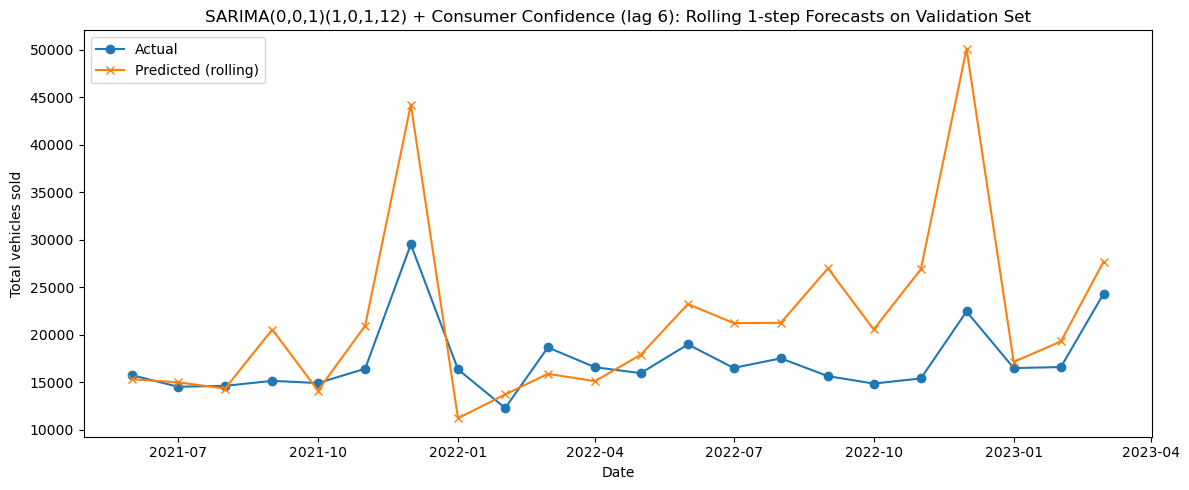

Validation RMSE (rolling): 8094.56
Validation MAPE (rolling): 28.21%


In [ ]:
# # Summary:
# # This code performs rolling 1-step-ahead forecasts on the validation set using a SARIMA model with an exogenous variable
# # (Consumer confidence, lagged by 6). For each rolling window, the model is fit on all available history, and a 1-step forecast is made.
# # The predictions are inverse BoxCox transformed, plotted against actuals, and RMSE/MAPE are computed.

# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Get BoxCox-transformed series for target and exogenous variable
# conf_bc = boxcox_all['Consumer confidence (E)']
# target_bc = boxcox_all[target]

# # Prepare rolling history lists for target and exogenous variable (train split)
# history_y = list(target_bc[:train_end])
# history_conf = list(conf_bc[:train_end])

# # Validation split for target and exogenous variable
# val_bc = target_bc[train_end:val_end]
# val_conf = conf_bc[train_end:val_end]

# predictions_bc = []

# # Rolling window: for each 1-step-ahead forecast in validation set
# for t in range(len(val_bc)):
#     # Prepare lagged exogenous variable (lag 6) for current history
#     conf_hist = np.array(history_conf)
#     conf_hist_lag6 = np.roll(conf_hist, 6)
#     conf_hist_lag6[:6] = np.nan  # First 6 values invalid due to lag
#     y_hist = np.array(history_y)[6:]  # Align target with lagged exog
#     conf_hist_lag6 = conf_hist_lag6[6:]

#     # Fit SARIMA model on all available history up to t
#     model = SARIMAX(
#         y_hist,
#         exog=conf_hist_lag6.reshape(-1, 1),
#         order=(0, 0, 1),
#         seasonal_order=(1, 0, 1, 12),
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
#     fitted_model = model.fit(disp=False)

#     # Prepare exogenous for next step (lag 6)
#     conf_exog_full = np.concatenate([conf_hist[-6:], [val_conf[t]]])
#     conf_exog_lag6 = np.roll(conf_exog_full, 6)[6:]
#     exog_next = conf_exog_lag6.reshape(-1, 1)
#     yhat = fitted_model.forecast(steps=1, exog=exog_next)[0]
#     predictions_bc.append(yhat)

#     # Update rolling history with actuals for next rolling window
#     history_y.append(val_bc[t])
#     history_conf.append(val_conf[t])

# # Inverse BoxCox transform for predictions
# lam, shift = boxcox_lambdas_all[target]
# def inv_boxcox(y, lam):
#     if lam == 0:
#         return np.exp(y)
#     else:
#         return np.power(lam * y + 1, 1/lam)

# val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
# actuals = y_val.values  # Align actuals with 1-step predictions

# # Plot actual vs predicted (rolling 1-step)
# plt.figure(figsize=(12, 5))
# plt.plot(df["Time Period (T)"][train_end:val_end], actuals, label='Actual', marker='o')
# plt.plot(df["Time Period (T)"][train_end:val_end], val_forecast_orig_rolling, label='Predicted (rolling)', marker='x')
# plt.title('SARIMA(0,0,1)(1,0,1,12) + Consumer Confidence (lag 6): Rolling 1-step Forecasts on Validation Set')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Calculate RMSE and MAPE for rolling 1-step forecasts
# rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
# mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
# print(f"Validation RMSE (rolling): {rmse_rolling:.2f}")
# print(f"Validation MAPE (rolling): {mape_rolling:.2%}")

### All features together/ turn this into top features together

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

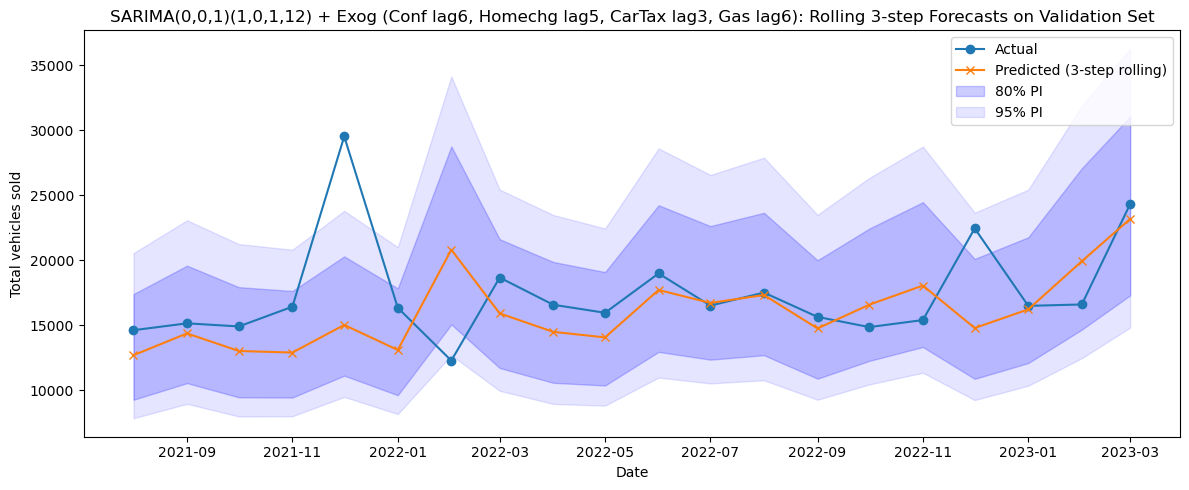

Validation RMSE (3-step rolling): 4541.29
Validation MAPE (3-step rolling): 16.70%


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# BoxCox-transformed features
conf_bc = boxcox_all['Consumer confidence (E)']
homechg_bc = boxcox_all['Home charging (G)']
car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc = boxcox_all[target]

history_y = list(target_bc[:train_end])
history_conf = list(conf_bc[:train_end])
history_homechg = list(homechg_bc[:train_end])
history_tax = list(car_tax_bc[:train_end])
history_gas = list(gas_bc[:train_end])

val_bc = target_bc[train_end:val_end]
val_conf = conf_bc[train_end:val_end]
val_homechg = homechg_bc[train_end:val_end]
val_tax = car_tax_bc[train_end:val_end]
val_gas = gas_bc[train_end:val_end]

horizon = 3
predictions_bc = []
conf_int_80 = []
conf_int_95 = []

for t in range(len(val_bc) - horizon + 1):
    # Prepare lagged exogenous for current history (lags: 6, 5, 3, 6)
    conf_hist = np.array(history_conf)
    homechg_hist = np.array(history_homechg)
    tax_hist = np.array(history_tax)
    gas_bc_hist = np.array(history_gas)
    
    conf_hist_lag6 = np.roll(conf_hist, 6)
    conf_hist_lag6[:6] = np.nan
    homechg_hist_lag5 = np.roll(homechg_hist, 5)
    homechg_hist_lag5[:5] = np.nan
    tax_hist_lag3 = np.roll(tax_hist, 3)
    tax_hist_lag3[:3] = np.nan
    gas_hist_lag6 = np.roll(gas_bc_hist, 6)
    gas_hist_lag6[:6] = np.nan

    # Align all (drop first 6)
    y_hist = np.array(history_y)[6:]
    conf_hist_lag6 = conf_hist_lag6[6:]
    homechg_hist_lag5 = homechg_hist_lag5[6:]
    tax_hist_lag3 = tax_hist_lag3[6:]
    gas_hist_lag6 = gas_hist_lag6[6:]
    exog_hist = np.column_stack([conf_hist_lag6, homechg_hist_lag5, tax_hist_lag3, gas_hist_lag6])
    
    # Fit model on all history up to t
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    
    # Recursive 3-step forecast with intervals
    temp_history_y = history_y.copy()
    temp_history_conf = history_conf.copy()
    temp_history_homechg = history_homechg.copy()
    temp_history_tax = history_tax.copy()
    temp_history_gas = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        conf_exog_full = np.concatenate([np.array(temp_history_conf)[-6:], [val_conf[idx]]])
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-5:], [val_homechg[idx]]])
        tax_exog_full = np.concatenate([np.array(temp_history_tax)[-3:], [val_tax[idx]]])
        gas_exog_full = np.concatenate([np.array(temp_history_gas)[-6:], [val_gas[idx]]])
        conf_exog_lag6 = np.roll(conf_exog_full, 6)[6:]
        homechg_exog_lag5 = np.roll(homechg_exog_full, 5)[5:]
        tax_exog_lag3 = np.roll(tax_exog_full, 3)[3:]
        gas_exog_lag6 = np.roll(gas_exog_full, 6)[6:]
        exog_next = np.column_stack([conf_exog_lag6, homechg_exog_lag5, tax_exog_lag3, gas_exog_lag6])
        res = fitted_model.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_conf.append(val_conf[idx])
        temp_history_homechg.append(val_homechg[idx])
        temp_history_tax.append(val_tax[idx])
        temp_history_gas.append(val_gas[idx])
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update history
    history_y.append(val_bc[t])
    history_conf.append(val_conf[t])
    history_homechg.append(val_homechg[t])
    history_tax.append(val_tax[t])
    history_gas.append(val_gas[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values[horizon-1:]

# Inverse transform intervals
conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

# Plot actual vs predicted (rolling 3-step) with intervals
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][train_end+horizon-1:val_end], val_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(df["Time Period (T)"][train_end+horizon-1:val_end], ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(df["Time Period (T)"][train_end+horizon-1:val_end], ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Exog (Conf lag6, Homechg lag5, CarTax lag3, Gas lag6): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

#### 1 step (Delete)

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

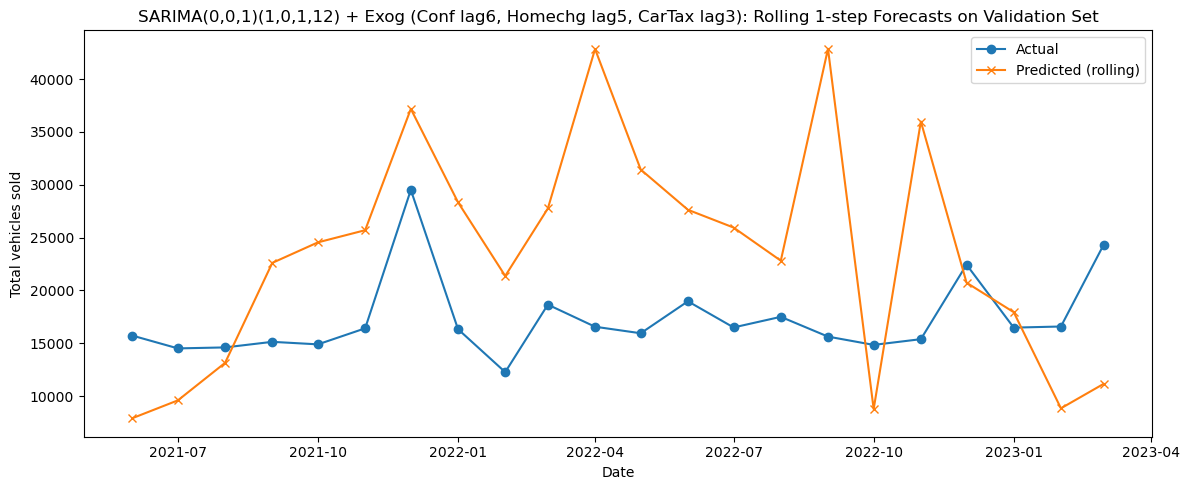

Validation RMSE (rolling): 12158.11
Validation MAPE (rolling): 60.95%


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # BoxCox-transformed features
# conf_bc = boxcox_all['Consumer confidence (E)']
# homechg_bc = boxcox_all['Home charging (G)']
# car_tax_bc = boxcox_all['Company car tax rate (%)']
# gas_bc = boxcox_all['Gasoline (Euro95) - Average price (F)']
# target_bc = boxcox_all[target]

# history_y = list(target_bc[:train_end])
# history_conf = list(conf_bc[:train_end])
# history_homechg = list(homechg_bc[:train_end])
# history_tax = list(car_tax_bc[:train_end])
# history_gas = list(gas_bc[:train_end])

# val_bc = target_bc[train_end:val_end]
# val_conf = conf_bc[train_end:val_end]
# val_homechg = homechg_bc[train_end:val_end]
# val_tax = car_tax_bc[train_end:val_end]
# val_gas = gas_bc[train_end:val_end]

# predictions_bc = []

# for t in range(len(val_bc)):
#     # Prepare lagged exogenous for current history (lags: 6, 5, 3)
#     conf_hist = np.array(history_conf)
#     homechg_hist = np.array(history_homechg)
#     tax_hist = np.array(history_tax)
#     gas_bc_hist = np.array(history_gas) 
    
#     conf_hist_lag6 = np.roll(conf_hist, 6)
#     conf_hist_lag6[:6] = np.nan
#     homechg_hist_lag5 = np.roll(homechg_hist, 5)
#     homechg_hist_lag5[:5] = np.nan
#     tax_hist_lag3 = np.roll(tax_hist, 3)
#     tax_hist_lag3[:3] = np.nan
#     gas_hist_lag6 = np.roll(gas_bc_hist, 6)
#     gas_hist_lag6[:6] = np.nan

#     # Align all (drop first 6)
#     y_hist = np.array(history_y)[6:]
#     conf_hist_lag6 = conf_hist_lag6[6:]
#     homechg_hist_lag5 = homechg_hist_lag5[6:]
#     tax_hist_lag3 = tax_hist_lag3[6:]
#     gas_hist_lag6 = gas_hist_lag6[6:]
#     exog_hist = np.column_stack([conf_hist_lag6, homechg_hist_lag5, tax_hist_lag3, gas_hist_lag6])
    
#     # Fit model on all history up to t
#     model = SARIMAX(
#         y_hist,
#         exog=exog_hist,
#         order=(0, 0, 1),
#         seasonal_order=(1, 0, 1, 12),
#         enforce_stationarity=False,
#         enforce_invertibility=False
#     )
#     fitted_model = model.fit(disp=False)
    
#     # Prepare exogenous for next step (use last lags from history + current val)
#     conf_exog_full = np.concatenate([conf_hist[-6:], [val_conf[t]]])
#     homechg_exog_full = np.concatenate([homechg_hist[-5:], [val_homechg[t]]])
#     tax_exog_full = np.concatenate([tax_hist[-3:], [val_tax[t]]])
#     gas_exog_full = np.concatenate([gas_bc_hist[-6:], [val_gas[t]]])

#     conf_exog_lag6 = np.roll(conf_exog_full, 6)[6:]
#     homechg_exog_lag5 = np.roll(homechg_exog_full, 5)[5:]
#     tax_exog_lag3 = np.roll(tax_exog_full, 3)[3:]
#     gas_exog_lag6 = np.roll(gas_exog_full, 6)[6:]

#     exog_next = np.column_stack([conf_exog_lag6, homechg_exog_lag5, tax_exog_lag3, gas_exog_lag6])
    
#     yhat = fitted_model.forecast(steps=1, exog=exog_next)[0]
#     predictions_bc.append(yhat)
    
#     # Update history
#     history_y.append(val_bc[t])
#     history_conf.append(val_conf[t])
#     history_homechg.append(val_homechg[t])
#     history_tax.append(val_tax[t])
#     history_gas.append(val_gas[t])

# # Inverse BoxCox transform
# lam, shift = boxcox_lambdas_all[target]
# def inv_boxcox(y, lam):
#     if lam == 0:
#         return np.exp(y)
#     else:
#         return np.power(lam * y + 1, 1/lam)

# val_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
# actuals = y_val.values

# # Plot actual vs predicted (rolling)
# plt.figure(figsize=(12, 5))
# plt.plot(df["Time Period (T)"][train_end:val_end], actuals, label='Actual', marker='o')
# plt.plot(df["Time Period (T)"][train_end:val_end], val_forecast_orig_rolling, label='Predicted (rolling)', marker='x')
# plt.title('SARIMA(0,0,1)(1,0,1,12) + Exog (Conf lag6, Homechg lag5, CarTax lag3): Rolling 1-step Forecasts on Validation Set')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Calculate RMSE and MAPE for rolling
# rmse_rolling = np.sqrt(mean_squared_error(actuals, val_forecast_orig_rolling))
# mape_rolling = mean_absolute_percentage_error(actuals, val_forecast_orig_rolling)
# print(f"Validation RMSE (rolling): {rmse_rolling:.2f}")
# print(f"Validation MAPE (rolling): {mape_rolling:.2%}")

# 6 Plot/evaluate with target value

### All features on test 


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

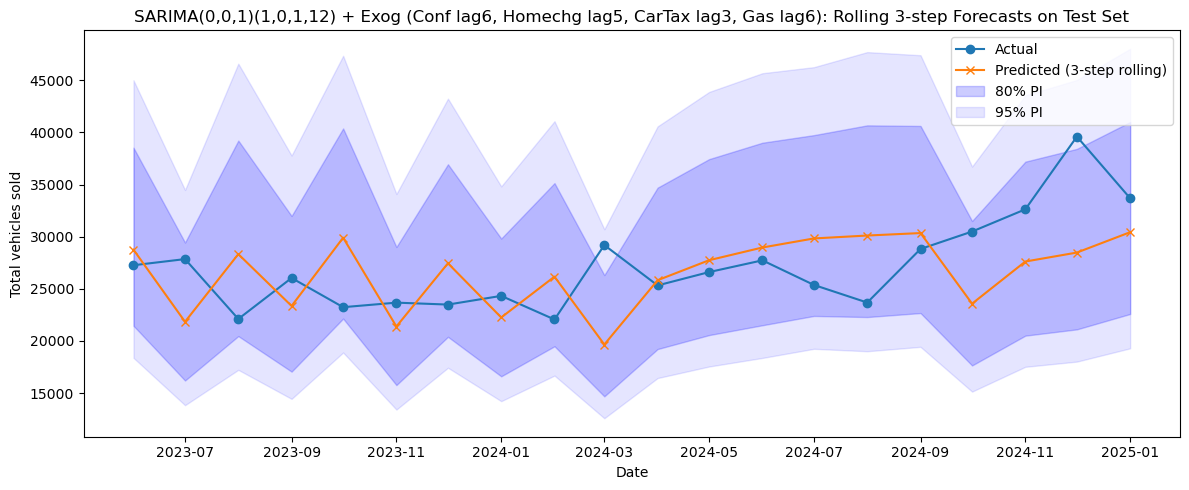

Test RMSE (3-step rolling): 5172.46
Test MAPE (3-step rolling): 15.84%


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# BoxCox-transformed features
conf_bc = boxcox_all['Consumer confidence (E)']
homechg_bc = boxcox_all['Home charging (G)']
car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc = boxcox_all[target]

# Use train+val as history, test as forecast set
history_y = list(target_bc[:val_end])
history_conf = list(conf_bc[:val_end])
history_homechg = list(homechg_bc[:val_end])
history_tax = list(car_tax_bc[:val_end])
history_gas = list(gas_bc[:val_end])

test_bc = target_bc[val_end:]
test_conf = conf_bc[val_end:]
test_homechg = homechg_bc[val_end:]
test_tax = car_tax_bc[val_end:]
test_gas = gas_bc[val_end:]

horizon = 3
predictions_bc = []
conf_int_80 = []
conf_int_95 = []

for t in range(len(test_bc) - horizon + 1):
    # Prepare lagged exogenous for current history (lags: 6, 5, 3, 6)
    conf_hist = np.array(history_conf)
    homechg_hist = np.array(history_homechg)
    tax_hist = np.array(history_tax)
    gas_bc_hist = np.array(history_gas)
    
    conf_hist_lag6 = np.roll(conf_hist, 6)
    conf_hist_lag6[:6] = np.nan
    homechg_hist_lag5 = np.roll(homechg_hist, 5)
    homechg_hist_lag5[:5] = np.nan
    tax_hist_lag3 = np.roll(tax_hist, 3)
    tax_hist_lag3[:3] = np.nan
    gas_hist_lag6 = np.roll(gas_bc_hist, 6)
    gas_hist_lag6[:6] = np.nan

    # Align all (drop first 6)
    y_hist = np.array(history_y)[6:]
    conf_hist_lag6 = conf_hist_lag6[6:]
    homechg_hist_lag5 = homechg_hist_lag5[6:]
    tax_hist_lag3 = tax_hist_lag3[6:]
    gas_hist_lag6 = gas_hist_lag6[6:]
    exog_hist = np.column_stack([conf_hist_lag6, homechg_hist_lag5, tax_hist_lag3, gas_hist_lag6])
    
    # Fit model on all history up to t
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    
    # Recursive 3-step forecast with intervals
    temp_history_y = history_y.copy()
    temp_history_conf = history_conf.copy()
    temp_history_homechg = history_homechg.copy()
    temp_history_tax = history_tax.copy()
    temp_history_gas = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        conf_exog_full = np.concatenate([np.array(temp_history_conf)[-6:], [test_conf[idx]]])
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-5:], [test_homechg[idx]]])
        tax_exog_full = np.concatenate([np.array(temp_history_tax)[-3:], [test_tax[idx]]])
        gas_exog_full = np.concatenate([np.array(temp_history_gas)[-6:], [test_gas[idx]]])
        conf_exog_lag6 = np.roll(conf_exog_full, 6)[6:]
        homechg_exog_lag5 = np.roll(homechg_exog_full, 5)[5:]
        tax_exog_lag3 = np.roll(tax_exog_full, 3)[3:]
        gas_exog_lag6 = np.roll(gas_exog_full, 6)[6:]
        exog_next = np.column_stack([conf_exog_lag6, homechg_exog_lag5, tax_exog_lag3, gas_exog_lag6])
        res = fitted_model.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_conf.append(test_conf[idx])
        temp_history_homechg.append(test_homechg[idx])
        temp_history_tax.append(test_tax[idx])
        temp_history_gas.append(test_gas[idx])
    predictions_bc.append(yhat)  # Only keep the 3rd step prediction
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update history
    history_y.append(test_bc[t])
    history_conf.append(test_conf[t])
    history_homechg.append(test_homechg[t])
    history_tax.append(test_tax[t])
    history_gas.append(test_gas[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

test_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_test.values[horizon-1:]

# Inverse transform intervals
conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

# Plot actual vs predicted (rolling 3-step) with intervals
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][val_end+horizon-1:], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][val_end+horizon-1:], test_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(df["Time Period (T)"][val_end+horizon-1:], ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(df["Time Period (T)"][val_end+horizon-1:], ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Exog (Conf lag6, Homechg lag5, CarTax lag3, Gas lag6): Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, test_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, test_forecast_orig_rolling)
print(f"Test RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Test MAPE (3-step rolling): {mape_rolling:.2%}")

MAPE values are all in a similar range (15–18%), which suggests no feature is dramatically improving or worsening the forecast.
RMSE for "All on test" is higher than for "All" on validation, which is expected due to test set uncertainty, but the drop in MAPE (to 15.84%) is a bit unusual—typically, RMSE and MAPE move together. This could be due to outliers or a shift in the test set distribution.
Adding exogenous features does not drastically improve RMSE/MAPE compared to baseline, which may indicate:
The target is mostly explained by its own lags.
Exogenous features are not strongly predictive, or lag choices could be further optimized.
No negative RMSE/MAPE or extreme values, so the model is numerically stable.

#### 1 step?

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


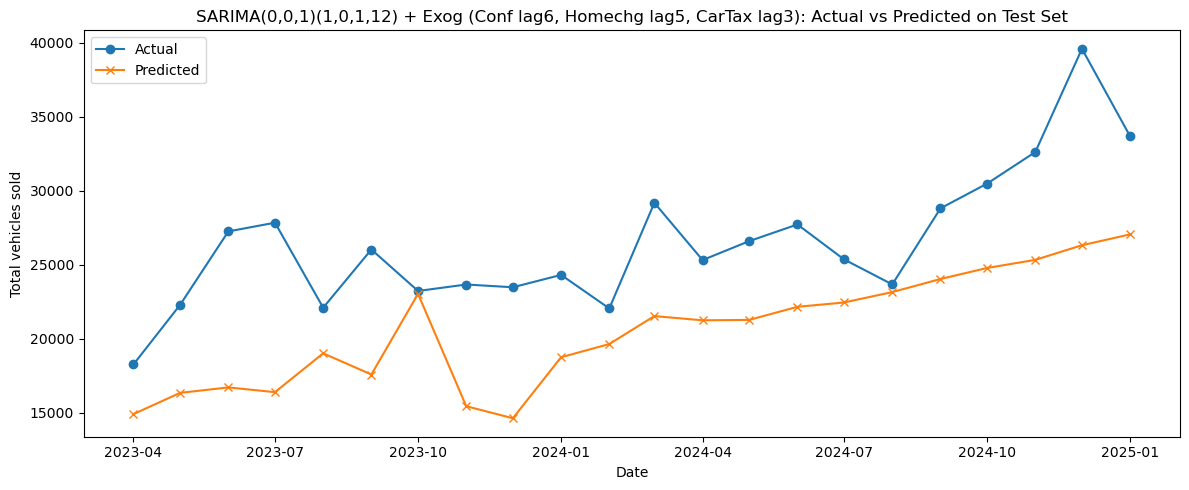

Test RMSE: 6819.04
Test MAPE: 22.04%


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Prepare exogenous variables: BoxCox-transformed, lagged by 6/5/3 (train/test split)
# conf_bc = boxcox_all['Consumer confidence (E)']
# homechg_bc = boxcox_all['Home charging (G)']
# car_tax_bc = boxcox_all['Company car tax rate (%)']

# # Train splits
# conf_train_exog = conf_bc[:train_end]
# homechg_train_exog = homechg_bc[:train_end]
# car_tax_train_exog = car_tax_bc[:train_end]

# # Apply lags
# conf_train_exog_lag6 = np.roll(conf_train_exog, 6)
# conf_train_exog_lag6[:6] = np.nan

# homechg_train_exog_lag5 = np.roll(homechg_train_exog, 5)
# homechg_train_exog_lag5[:5] = np.nan

# car_tax_train_exog_lag3 = np.roll(car_tax_train_exog, 3)
# car_tax_train_exog_lag3[:3] = np.nan

# # Align all exogenous variables and target (drop first 6 rows)
# y_train_bc = boxcox_all[target][:train_end][6:]
# conf_train_exog_lag6 = conf_train_exog_lag6[6:]
# homechg_train_exog_lag5 = homechg_train_exog_lag5[6:]
# car_tax_train_exog_lag3 = car_tax_train_exog_lag3[6:]

# exog_train = np.column_stack([conf_train_exog_lag6, homechg_train_exog_lag5, car_tax_train_exog_lag3])

# # Fit SARIMA with all exogenous features
# model = SARIMAX(
#     y_train_bc,
#     exog=exog_train,
#     order=(1, 0, 2),
#     seasonal_order=(0, 0, 1, 12),
#     enforce_stationarity=False,
#     enforce_invertibility=False
# )
# fitted_model = model.fit(disp=False)

# # Prepare test exog (use last lags from train + test)
# conf_test_exog_full = np.concatenate([conf_bc[train_end-6:train_end], conf_bc[train_end:]])
# homechg_test_exog_full = np.concatenate([homechg_bc[train_end-5:train_end], homechg_bc[train_end:]])
# car_tax_test_exog_full = np.concatenate([car_tax_bc[train_end-3:train_end], car_tax_bc[train_end:]])

# conf_test_exog_lag6 = np.roll(conf_test_exog_full, 6)[6:]
# homechg_test_exog_lag5 = np.roll(homechg_test_exog_full, 5)[5:]
# car_tax_test_exog_lag3 = np.roll(car_tax_test_exog_full, 3)[3:]

# # Only select test set indices
# n_test = len(y_test)
# exog_test = np.column_stack([
#     conf_test_exog_lag6[-n_test:],
#     homechg_test_exog_lag5[-n_test:],
#     car_tax_test_exog_lag3[-n_test:]
# ])

# # Forecast for test set
# test_forecast_bc = fitted_model.forecast(steps=n_test, exog=exog_test)

# # Inverse BoxCox transform
# lam, shift = boxcox_lambdas_all[target]
# def inv_boxcox(y, lam):
#     if lam == 0:
#         return np.exp(y)
#     else:
#         return np.power(lam * y + 1, 1/lam)

# test_forecast_orig = inv_boxcox(test_forecast_bc, lam) - shift

# # Actuals
# actuals = y_test.values

# # Plot actual vs predicted
# # Plot actual vs predicted
# plt.figure(figsize=(12, 5))
# plt.plot(df["Time Period (T)"][val_end:], actuals, label='Actual', marker='o')
# plt.plot(df["Time Period (T)"][val_end:], test_forecast_orig, label='Predicted', marker='x')
# plt.title('SARIMA(0,0,1)(1,0,1,12) + Exog (Conf lag6, Homechg lag5, CarTax lag3): Actual vs Predicted on Test Set')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Calculate RMSE and MAPE
# rmse = np.sqrt(mean_squared_error(actuals, test_forecast_orig))
# mape = mean_absolute_percentage_error(actuals, test_forecast_orig)
# print(f"Test RMSE: {rmse:.2f}")
# print(f"Test MAPE: {mape:.2%}")


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

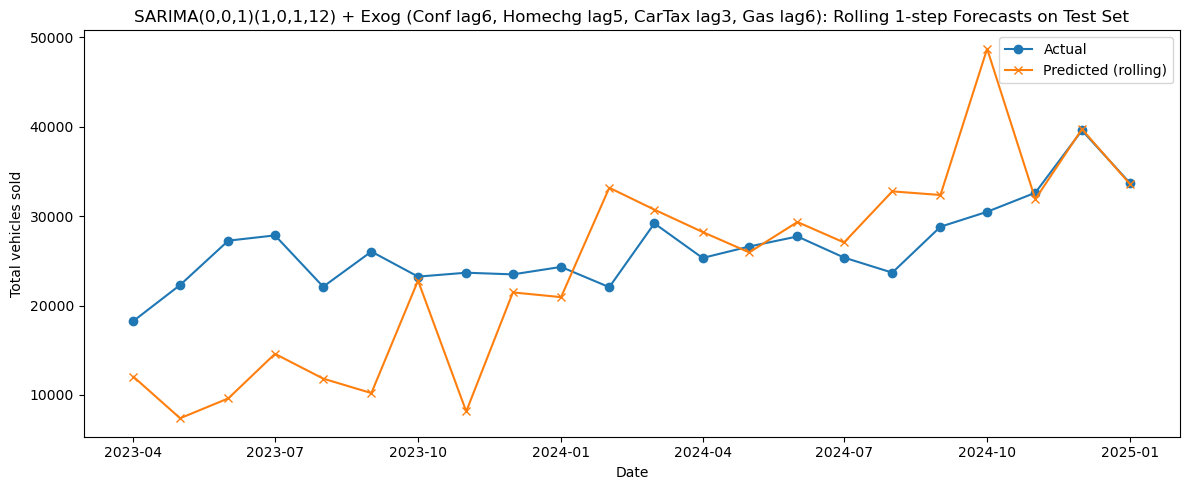

Test RMSE (rolling): 9365.78
Test MAPE (rolling): 27.55%


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# BoxCox-transformed features
conf_bc = boxcox_all['Consumer confidence (E)']
homechg_bc = boxcox_all['Home charging (G)']
car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc = boxcox_all[target]

# Rolling (walk-forward) test set prediction
history_y = list(target_bc[:val_end])
history_conf = list(conf_bc[:val_end])
history_homechg = list(homechg_bc[:val_end])
history_tax = list(car_tax_bc[:val_end])
history_gas = list(gas_bc[:val_end])

test_bc = target_bc[val_end:]
test_conf = conf_bc[val_end:]
test_homechg = homechg_bc[val_end:]
test_tax = car_tax_bc[val_end:]
test_gas = gas_bc[val_end:]

predictions_bc = []

for t in range(len(test_bc)):
    # Prepare lagged exogenous for current history (lags: 6, 5, 3, 6)
    conf_hist = np.array(history_conf)
    homechg_hist = np.array(history_homechg)
    tax_hist = np.array(history_tax)
    gas_hist = np.array(history_gas)

    conf_hist_lag6 = np.roll(conf_hist, 6)
    conf_hist_lag6[:6] = np.nan
    homechg_hist_lag5 = np.roll(homechg_hist, 5)
    homechg_hist_lag5[:5] = np.nan
    tax_hist_lag3 = np.roll(tax_hist, 3)
    tax_hist_lag3[:3] = np.nan
    gas_hist_lag6 = np.roll(gas_hist, 6)
    gas_hist_lag6[:6] = np.nan

    # Align all (drop first 6)
    y_hist = np.array(history_y)[6:]
    conf_hist_lag6 = conf_hist_lag6[6:]
    homechg_hist_lag5 = homechg_hist_lag5[6:]
    tax_hist_lag3 = tax_hist_lag3[6:]
    gas_hist_lag6 = gas_hist_lag6[6:]
    exog_hist = np.column_stack([conf_hist_lag6, homechg_hist_lag5, tax_hist_lag3, gas_hist_lag6])

    # Fit model on all history up to t
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(0, 0, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)

    # Prepare exogenous for next step (use last lags from history + current test)
    conf_exog_full = np.concatenate([conf_hist[-6:], [test_conf[t]]])
    homechg_exog_full = np.concatenate([homechg_hist[-5:], [test_homechg[t]]])
    tax_exog_full = np.concatenate([tax_hist[-3:], [test_tax[t]]])
    gas_exog_full = np.concatenate([gas_hist[-6:], [test_gas[t]]])
    conf_exog_lag6 = np.roll(conf_exog_full, 6)[6:]
    homechg_exog_lag5 = np.roll(homechg_exog_full, 5)[5:]
    tax_exog_lag3 = np.roll(tax_exog_full, 3)[3:]
    gas_exog_lag6 = np.roll(gas_exog_full, 6)[6:]
    exog_next = np.column_stack([conf_exog_lag6, homechg_exog_lag5, tax_exog_lag3, gas_exog_lag6])

    yhat = fitted_model.forecast(steps=1, exog=exog_next)[0]
    predictions_bc.append(yhat)

    # Update history
    history_y.append(test_bc[t])
    history_conf.append(test_conf[t])
    history_homechg.append(test_homechg[t])
    history_tax.append(test_tax[t])
    history_gas.append(test_gas[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

test_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_test.values

# Plot actual vs predicted (rolling)
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][val_end:], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][val_end:], test_forecast_orig_rolling, label='Predicted (rolling)', marker='x')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Exog (Conf lag6, Homechg lag5, CarTax lag3, Gas lag6): Rolling 1-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling
rmse_rolling = np.sqrt(mean_squared_error(actuals, test_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, test_forecast_orig_rolling)
print(f"Test RMSE (rolling): {rmse_rolling:.2f}")
print(f"Test MAPE (rolling): {mape_rolling:.2%}")

### 3 step

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

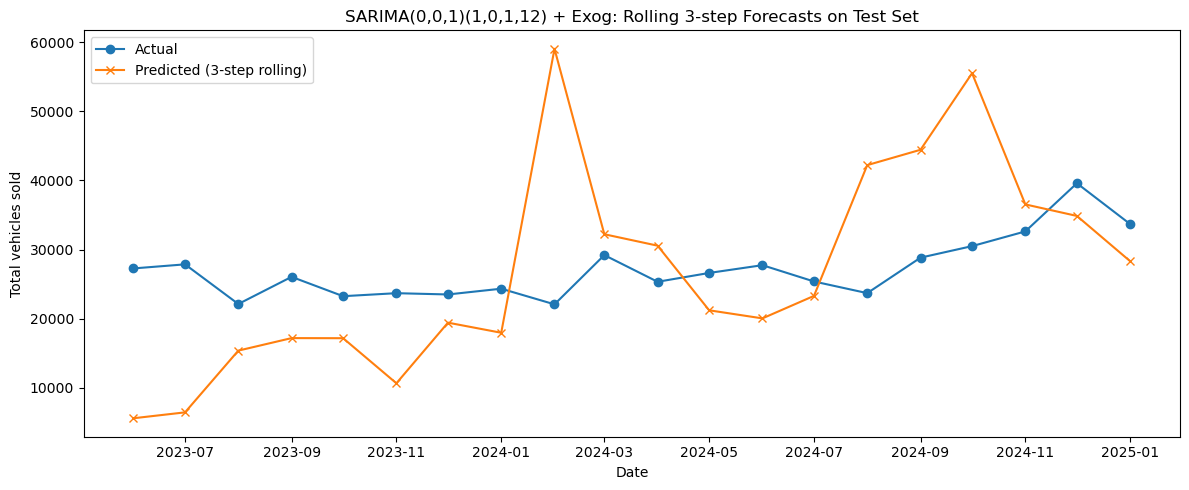

Test RMSE (3-step rolling): 14317.08
Test MAPE (3-step rolling): 42.78%


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# BoxCox-transformed features
conf_bc = boxcox_all['Consumer confidence (E)']
homechg_bc = boxcox_all['Home charging (G)']
car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc = boxcox_all[target]

# Rolling (walk-forward) test set prediction for 3-step ahead
history_y = list(target_bc[:val_end])
history_conf = list(conf_bc[:val_end])
history_homechg = list(homechg_bc[:val_end])
history_tax = list(car_tax_bc[:val_end])
history_gas = list(gas_bc[:val_end])

test_bc = target_bc[val_end:]
test_conf = conf_bc[val_end:]
test_homechg = homechg_bc[val_end:]
test_tax = car_tax_bc[val_end:]
test_gas = gas_bc[val_end:]

horizon = 3
predictions_bc = []

t = 0
while t <= len(test_bc) - horizon:
    # Prepare lagged exogenous for current history (lags: 6, 5, 3, 6)
    conf_hist = np.array(history_conf)
    homechg_hist = np.array(history_homechg)
    tax_hist = np.array(history_tax)
    gas_hist = np.array(history_gas)

    conf_hist_lag6 = np.roll(conf_hist, 6)
    conf_hist_lag6[:6] = np.nan
    homechg_hist_lag5 = np.roll(homechg_hist, 5)
    homechg_hist_lag5[:5] = np.nan
    tax_hist_lag3 = np.roll(tax_hist, 3)
    tax_hist_lag3[:3] = np.nan
    gas_hist_lag6 = np.roll(gas_hist, 6)
    gas_hist_lag6[:6] = np.nan

    # Align all (drop first 6)
    y_hist = np.array(history_y)[6:]
    conf_hist_lag6 = conf_hist_lag6[6:]
    homechg_hist_lag5 = homechg_hist_lag5[6:]
    tax_hist_lag3 = tax_hist_lag3[6:]
    gas_hist_lag6 = gas_hist_lag6[6:]
    exog_hist = np.column_stack([conf_hist_lag6, homechg_hist_lag5, tax_hist_lag3, gas_hist_lag6])

    # Fit model on all history up to t
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(0, 0, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)

    # Prepare exogenous for next 3 steps
    preds = []
    temp_history_y = history_y.copy()
    temp_history_conf = history_conf.copy()
    temp_history_homechg = history_homechg.copy()
    temp_history_tax = history_tax.copy()
    temp_history_gas = history_gas.copy()

    for step in range(horizon):
        idx = t + step
        # Use actual exog for each step (recursive for y)
        conf_exog_full = np.concatenate([np.array(temp_history_conf)[-6:], [test_conf[idx]]])
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-5:], [test_homechg[idx]]])
        tax_exog_full = np.concatenate([np.array(temp_history_tax)[-3:], [test_tax[idx]]])
        gas_exog_full = np.concatenate([np.array(temp_history_gas)[-6:], [test_gas[idx]]])
        conf_exog_lag6 = np.roll(conf_exog_full, 6)[6:]
        homechg_exog_lag5 = np.roll(homechg_exog_full, 5)[5:]
        tax_exog_lag3 = np.roll(tax_exog_full, 3)[3:]
        gas_exog_lag6 = np.roll(gas_exog_full, 6)[6:]
        exog_next = np.column_stack([conf_exog_lag6, homechg_exog_lag5, tax_exog_lag3, gas_exog_lag6])

        yhat = fitted_model.forecast(steps=1, exog=exog_next)[0]
        preds.append(yhat)

        # Update temp histories with prediction for recursive forecasting
        temp_history_y.append(yhat)
        temp_history_conf.append(test_conf[idx])
        temp_history_homechg.append(test_homechg[idx])
        temp_history_tax.append(test_tax[idx])
        temp_history_gas.append(test_gas[idx])

    predictions_bc.append(preds[-1])  # Only keep the 3rd step prediction
    # Update real histories with actuals (not predictions)
    history_y.append(test_bc[t])
    history_conf.append(test_conf[t])
    history_homechg.append(test_homechg[t])
    history_tax.append(test_tax[t])
    history_gas.append(test_gas[t])
    t += 1

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

# Align actuals for 3-step ahead (start at t=2)
actuals = y_test.values[horizon-1:]
test_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift

# Plot actual vs predicted (rolling 3-step ahead)
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][val_end+horizon-1:], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][val_end+horizon-1:], test_forecast_orig_rolling, label='Predicted (3-step rolling)', marker='x')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Exog: Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, test_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, test_forecast_orig_rolling)
print(f"Test RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Test MAPE (3-step rolling): {mape_rolling:.2%}")

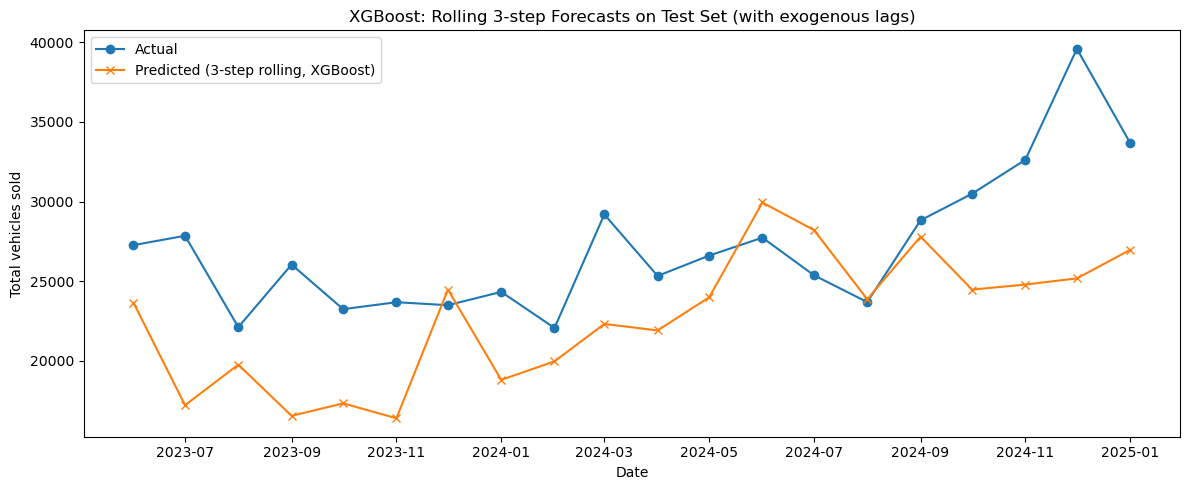

Test RMSE (3-step rolling, XGBoost): 6232.53
Test MAPE (3-step rolling, XGBoost): 18.09%


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# BoxCox-transformed features
conf_bc = boxcox_all['Consumer confidence (E)']
homechg_bc = boxcox_all['Home charging (G)']
car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc = boxcox_all[target]

# Rolling (walk-forward) test set prediction for 3-step ahead using XGBoost with exogenous lags
history_y = list(target_bc[:val_end])
history_conf = list(conf_bc[:val_end])
history_homechg = list(homechg_bc[:val_end])
history_tax = list(car_tax_bc[:val_end])
history_gas = list(gas_bc[:val_end])

test_bc = target_bc[val_end:]
test_conf = conf_bc[val_end:]
test_homechg = homechg_bc[val_end:]
test_tax = car_tax_bc[val_end:]
test_gas = gas_bc[val_end:]

horizon = 3
predictions_bc = []

def make_lagged_row(hist_y, hist_conf, hist_homechg, hist_tax, hist_gas):
    # Lags: target (1,2,3,12), conf (lag6), homechg (lag5), tax (lag3), gas (lag6)
    row = []
    for lag in [1,2,3,12]:
        row.append(hist_y[-lag])
    row.append(hist_conf[-6])
    row.append(hist_homechg[-5])
    row.append(hist_tax[-3])
    row.append(hist_gas[-6])
    return np.array(row)

t = 0
while t <= len(test_bc) - horizon:
    # Build rolling training set from history (drop first 12 for lag safety)
    min_lag = 12
    X_hist, y_hist = [], []
    for i in range(min_lag, len(history_y)):
        X_hist.append(make_lagged_row(
            history_y[:i], history_conf[:i], history_homechg[:i], history_tax[:i], history_gas[:i]
        ))
        y_hist.append(history_y[i])
    X_hist = np.array(X_hist)
    y_hist = np.array(y_hist)
    # Fit XGBoost
    model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, objective='reg:squarederror')
    model.fit(X_hist, y_hist)

    # Recursive 3-step forecast
    preds = []
    temp_history_y = history_y.copy()
    temp_history_conf = history_conf.copy()
    temp_history_homechg = history_homechg.copy()
    temp_history_tax = history_tax.copy()
    temp_history_gas = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        # For exog, append current test value to history for lag calculation
        next_conf = np.append(temp_history_conf, test_conf[idx])
        next_homechg = np.append(temp_history_homechg, test_homechg[idx])
        next_tax = np.append(temp_history_tax, test_tax[idx])
        next_gas = np.append(temp_history_gas, test_gas[idx])
        feats = []
        for lag in [1,2,3,12]:
            feats.append(temp_history_y[-lag])
        feats.append(next_conf[-6])
        feats.append(next_homechg[-5])
        feats.append(next_tax[-3])
        feats.append(next_gas[-6])
        feats = np.array(feats).reshape(1, -1)
        yhat = model.predict(feats)[0]
        preds.append(yhat)
        # Update temp histories with prediction for recursive forecasting
        temp_history_y.append(yhat)
        temp_history_conf.append(test_conf[idx])
        temp_history_homechg.append(test_homechg[idx])
        temp_history_tax.append(test_tax[idx])
        temp_history_gas.append(test_gas[idx])
    predictions_bc.append(preds[-1])  # Only keep the 3rd step prediction

    # Update real histories with actuals (not predictions)
    history_y.append(test_bc[t])
    history_conf.append(test_conf[t])
    history_homechg.append(test_homechg[t])
    history_tax.append(test_tax[t])
    history_gas.append(test_gas[t])
    t += 1

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

# Align actuals for 3-step ahead (start at t=2)
actuals = y_test.values[horizon-1:]
test_forecast_orig_rolling = inv_boxcox(np.array(predictions_bc), lam) - shift

# Plot actual vs predicted (rolling 3-step ahead)
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][val_end+horizon-1:], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][val_end+horizon-1:], test_forecast_orig_rolling, label='Predicted (3-step rolling, XGBoost)', marker='x')
plt.title('XGBoost: Rolling 3-step Forecasts on Test Set (with exogenous lags)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for rolling 3-step
rmse_rolling = np.sqrt(mean_squared_error(actuals, test_forecast_orig_rolling))
mape_rolling = mean_absolute_percentage_error(actuals, test_forecast_orig_rolling)
print(f"Test RMSE (3-step rolling, XGBoost): {rmse_rolling:.2f}")
print(f"Test MAPE (3-step rolling, XGBoost): {mape_rolling:.2%}")